# 📊 Predicción de Ingresos con Datos del Censo

**Haciendo Economía 2 – Parcial 2**

---

## 🎯 Objetivo
En este parcial utilizaremos datos del censo para **predecir si una persona gana más o menos de 50.000 dólares al año**.  
El propósito es comparar el desempeño de dos enfoques distintos:

1. **Modelo Logit (baseline)**  
2. **Redes Neuronales Profundas (Deep Learning)**

Más allá de obtener un buen ajuste, el interés está en conocer **qué tan útiles son los datos del censo para predecir los ingresos de las personas** y saber **que tan bueno es un modelo de redes neuronales en comparación a nuestro modelo de base**.

---



## 0. Setup inicial
Iniciamos cargando las librerías importantes y montamos google drive para poder acceder a los datos.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Recolección y procesamiento de datos



### 1.1 Carga de datos

Procedemos a cargar y probar los datos de entrenamiento y prueba.

In [ ]:
"""
DATASET: Adult income dataset
Link: https://archive.ics.uci.edu/dataset/2/adult

Descripción: Nos permite predecir si los ingresos anuales de un individuo exceden
los 50k dolares usando datos del censo.

Variables principales:
- age: Edad
- workclass: Tipo de empleador
- fnlwgt: Peso final
- education: Nivel educativo
- education-num: Años de educación
- marital-status: Estado civil
- occupation: Ocupación
- relationship: Relación familiar
- race: Raza
- sex: Sexo
- capital-gain: Ganancia de capital
- capital-loss: Pérdida de capital
- hours-per-week: Horas por semana
- native-country: País de origen
- income: Ingresos (<=50K, >50K)


Total de registros disponibles = 16,281
"""

# Carga de datos de prueba
adult_test = pd.read_csv(
    "/content/drive/MyDrive/Parcial 2 HE2/datos/adult.test",
    sep=',',
    skiprows=1,
    header=None,
    names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
)

# Revisamos los datos de prueba
print("Información del dataset de prueba cargado:")
print(f"Dimensiones: {adult_test.shape}")
print(f"Columnas: {list(adult_test.columns)}")
print("\nDistribución de la variable objetivo:")
print(adult_test['income'].value_counts(normalize=True))

# Carga de datos de entreno
adult_train = pd.read_csv(
    "/content/drive/MyDrive/Parcial 2 HE2/datos/adult.data",
    sep=',',
    header=None,
    names=['age',
     'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
)

# Revisamos los datos de entreno
print("\nInformación del dataset de entrenamiento cargado:")
print(f"Dimensiones: {adult_train.shape}")
print(f"Columnas: {list(adult_train.columns)}")
print("\nDistribución de la variable objetivo:")
print(adult_train['income'].value_counts(normalize=True))

Información del dataset de prueba cargado:
Dimensiones: (16281, 15)
Columnas: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

Distribución de la variable objetivo:
income
<=50K.    0.763774
>50K.     0.236226
Name: proportion, dtype: float64

Información del dataset de entrenamiento cargado:
Dimensiones: (32561, 15)
Columnas: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

Distribución de la variable objetivo:
income
<=50K    0.75919
>50K     0.24081
Name: proportion, dtype: float64


Ahora dividimos los datos de prueba en un split de 50-50. Procedemos entonces a revisar la distribución de la variable objetivo.

### 1.2 Split de datos

In [ ]:

# Creamos una variable objetivo
target = "income"

# Separamos los datos de prueba
X_test = adult_test.drop(target, axis = 1)
y_test = adult_test[[target]]

X_train = adult_train.drop(target, axis = 1)
y_train = adult_train[[target]]

# Dividimos los datos en entrenamiento y prueba
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

# Distribución de la variable objetivo
print("\nDistribución de la variable objetivo en el split de entrenamiento:")
print(y_train['income'].value_counts(normalize=True))
print("\nDistribución de la variable objetivo en el split de validación:")
print(y_val['income'].value_counts(normalize=True))



Distribución de la variable objetivo en el split de entrenamiento:
income
<=50K    0.759459
>50K     0.240541
Name: proportion, dtype: float64

Distribución de la variable objetivo en el split de validación:
income
<=50K    0.758921
>50K     0.241079
Name: proportion, dtype: float64


Note que la distribución de los datos se asimila cercanamente a los datos de entrenamiento.

### 1.3 Análisis exploratorio de datos
En este análisis buscamos entender las distribuciones de los datos y la calidad de estos. De esta forma, podemos conocer que tantos missing values hay (para saber la relevancia de estos y la necesidad ajustarlos), al igual que las modificaciones que tenemos que hacer a alguas variables.

In [ ]:
# Buscamos la cantidad de missing values ("?") en las bases de entrenamiento y validación:
print("Missing values:")

print("Variables explicativas")
print(f"Cantidad de missing values en el split de entrenamiento: {X_train.isin([' ?']).sum().sum()}")
print(f"Porcentaje de missing values en el split de entrenamiento: {X_train.isin([' ?']).sum().sum() / X_train.size * 100:.2f}%")
print("")

print("Variable explicada")

print(f"Cantidad de missing values en el split de entrenamiento: {y_train.isin([' ?']).sum().sum()}")
print(f"Porcentaje de missing values en el split de entrenamiento: {y_train.isin([' ?']).sum().sum() / y_train.size * 100:.2f}%")

Missing values:
Variables explicativas
Cantidad de missing values en el split de entrenamiento: 2106
Porcentaje de missing values en el split de entrenamiento: 0.92%

Variable explicada
Cantidad de missing values en el split de entrenamiento: 0
Porcentaje de missing values en el split de entrenamiento: 0.00%


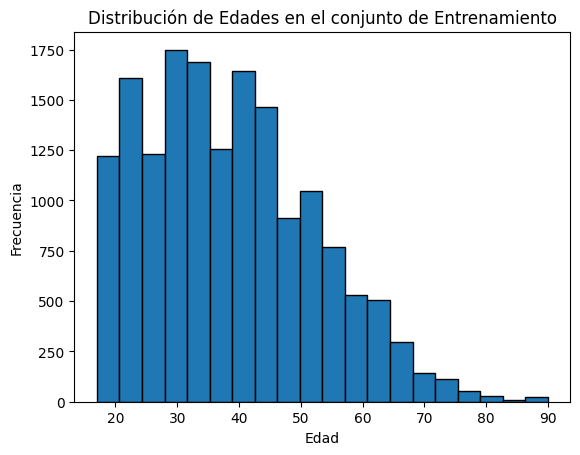

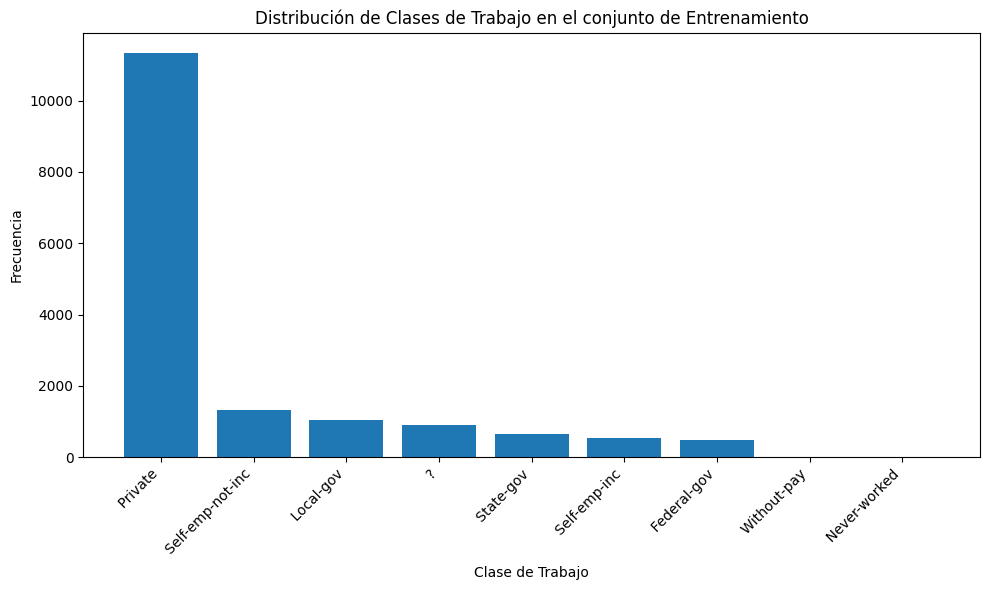

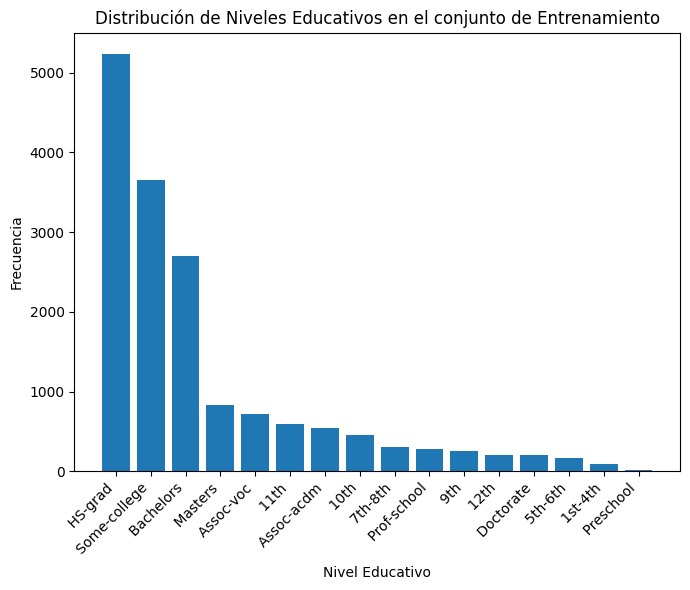

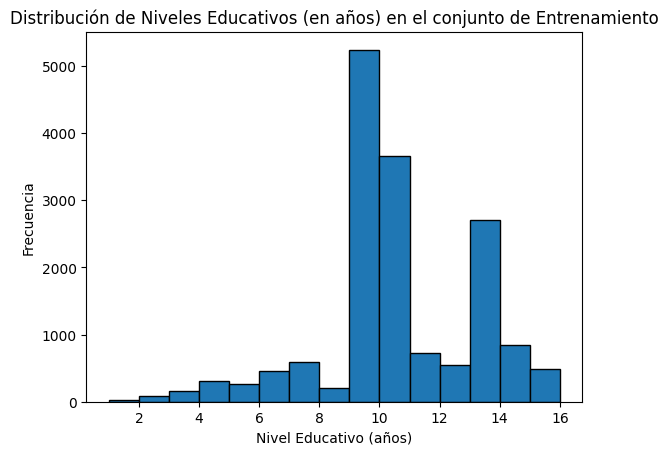

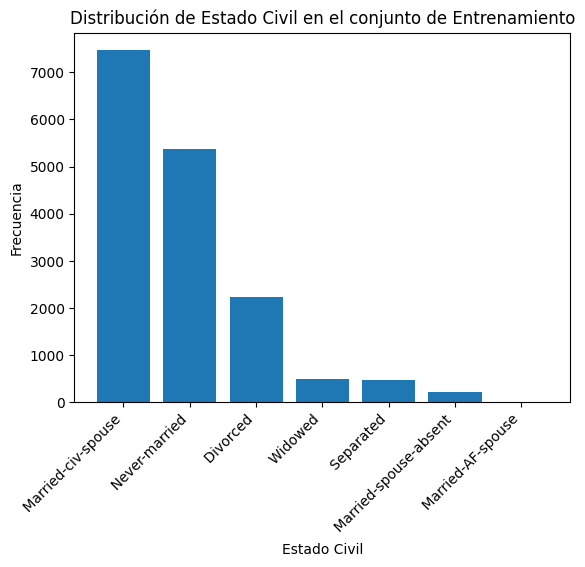

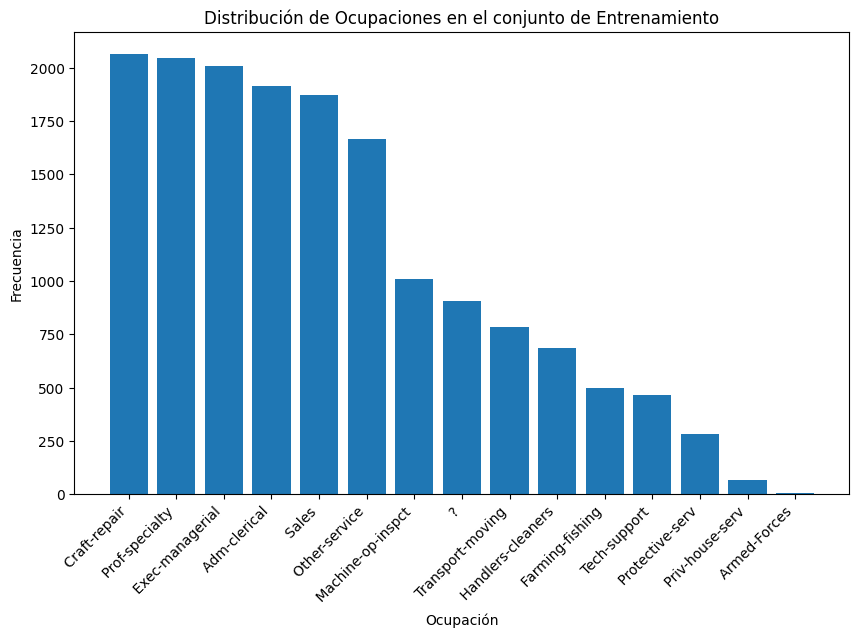

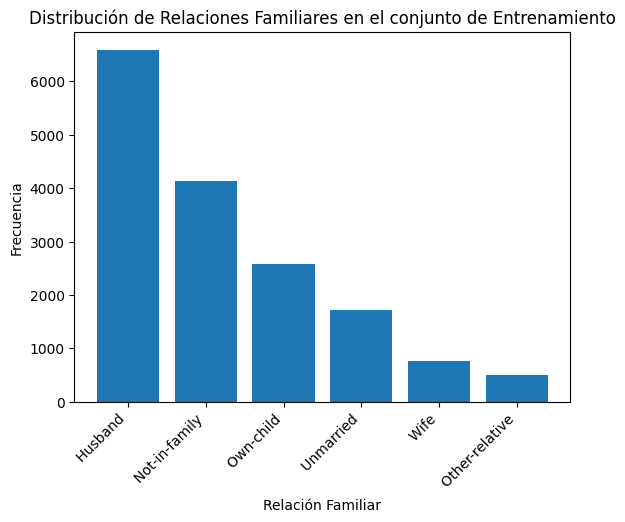

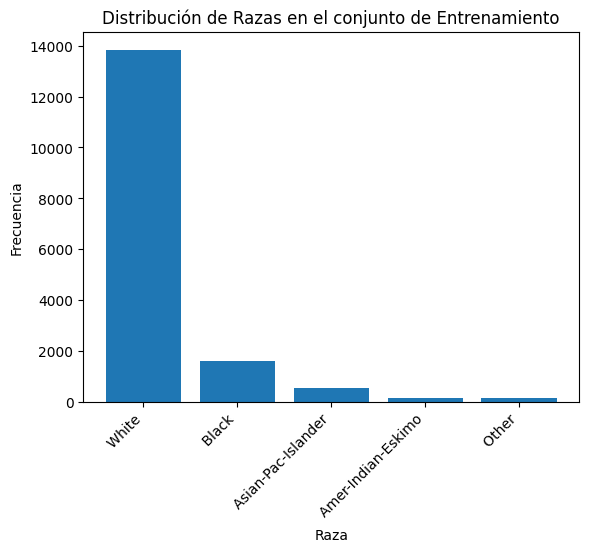

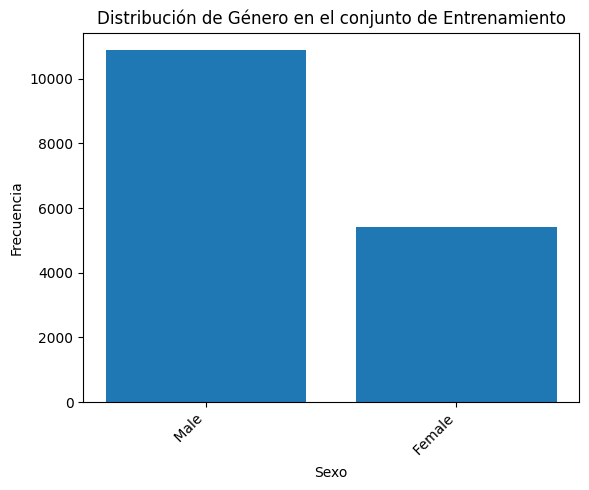

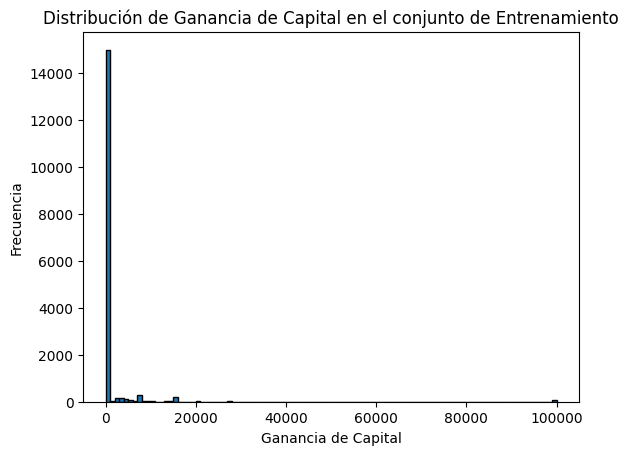

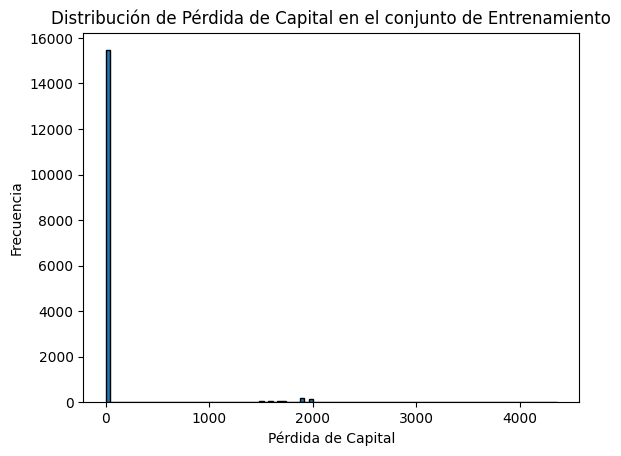

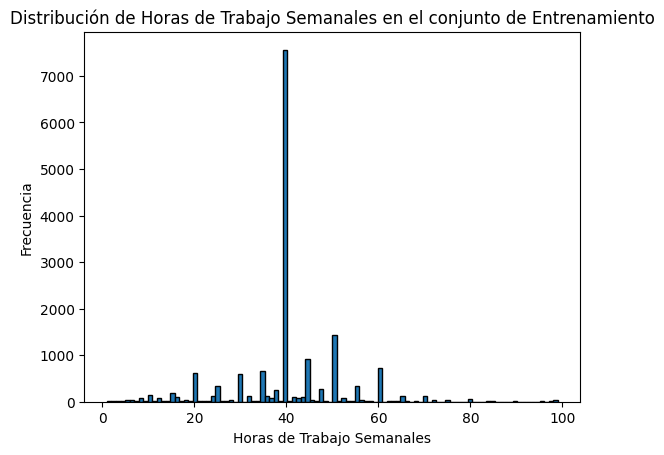

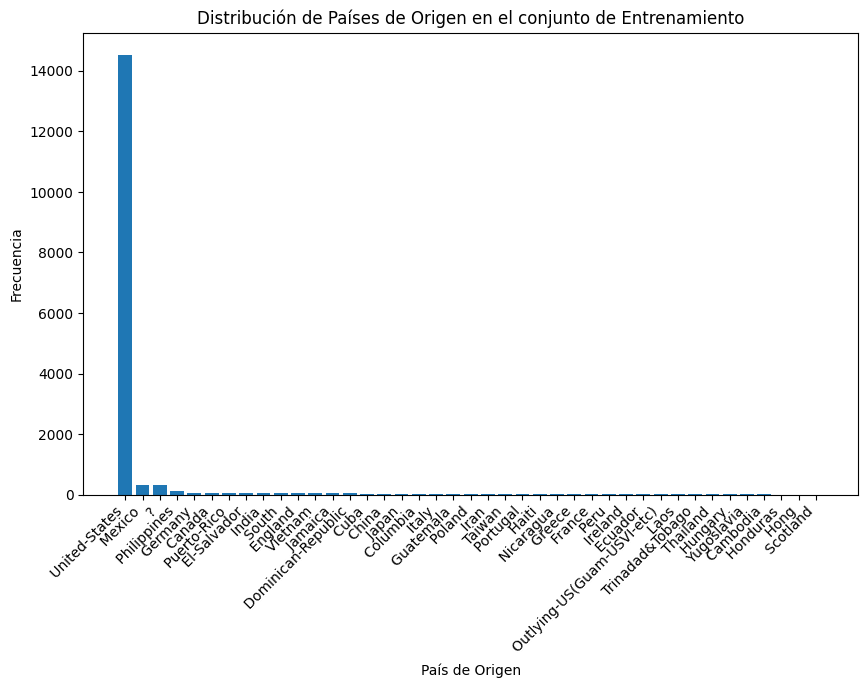

In [ ]:
### Visualización gráfica de los datos

# Distribución de edades
fig, ax = plt.subplots()
ax.hist(X_train['age'], bins=20, edgecolor='black')
ax.set_title('Distribución de Edades en el conjunto de Entrenamiento')
ax.set_xlabel('Edad')
ax.set_ylabel('Frecuencia')
plt.show()

# Distribución de clases de trabajo (categorica)
workclass_counts = X_train['workclass'].value_counts()
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(workclass_counts.index, workclass_counts.values)
ax.set_title('Distribución de Clases de Trabajo en el conjunto de Entrenamiento')
ax.set_xlabel('Clase de Trabajo')
ax.set_ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Disrtibucion de clases de educación(categorica)
fig, ax = plt.subplots(figsize=(7, 6))
education_counts = X_train['education'].value_counts()
ax.bar(education_counts.index, education_counts.values)
ax.set_title('Distribución de Niveles Educativos en el conjunto de Entrenamiento')
ax.set_xlabel('Nivel Educativo')
ax.set_ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Distribución de educación numérica
fig, ax = plt.subplots()
ax.hist(X_train['education-num'], bins=15, edgecolor='black')
ax.set_title('Distribución de Niveles Educativos (en años) en el conjunto de Entrenamiento')
ax.set_xlabel('Nivel Educativo (años)')
ax.set_ylabel('Frecuencia')
plt.show()

# Distribución de status martial
marital_status_counts = X_train['marital-status'].value_counts() # Obtener conteos para barras
fig, ax = plt.subplots()
ax.bar(marital_status_counts.index, marital_status_counts.values) # Usar bar para datos categóricos
ax.set_title('Distribución de Estado Civil en el conjunto de Entrenamiento')
ax.set_xlabel('Estado Civil')
ax.set_ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.show()

# Distribución de ocupación
fig, ax = plt.subplots(figsize=(10, 6))
occupation_counts = X_train['occupation'].value_counts()
ax.bar(occupation_counts.index, occupation_counts.values)
ax.set_title('Distribución de Ocupaciones en el conjunto de Entrenamiento')
ax.set_xlabel('Ocupación')
ax.set_ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.show()

# Distribución de relaciones
fig, ax = plt.subplots()
relationship_counts = X_train['relationship'].value_counts()
ax.bar(relationship_counts.index, relationship_counts.values)
ax.set_title('Distribución de Relaciones Familiares en el conjunto de Entrenamiento')
ax.set_xlabel('Relación Familiar')
ax.set_ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.show()

# Distribución de raza
fig, ax = plt.subplots()
race_counts = X_train['race'].value_counts()
ax.bar(race_counts.index, race_counts.values)
ax.set_title('Distribución de Razas en el conjunto de Entrenamiento')
ax.set_xlabel('Raza')
ax.set_ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.show()

# Distribución de sexo
fig, ax = plt.subplots()
sex_counts = X_train['sex'].value_counts()
ax.bar(sex_counts.index, sex_counts.values)
ax.set_title('Distribución de Género en el conjunto de Entrenamiento')
ax.set_xlabel('Sexo')
ax.set_ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.show()

# Distribución de ganancias de capital
fig, ax = plt.subplots()
ax.hist(X_train['capital-gain'], bins=100, edgecolor='black')
ax.set_title('Distribución de Ganancia de Capital en el conjunto de Entrenamiento')
ax.set_xlabel('Ganancia de Capital')
ax.set_ylabel('Frecuencia')
plt.show()

# Distribución de pérdidas de capital
fig, ax = plt.subplots()
ax.hist(X_train['capital-loss'], bins=100, edgecolor='black')
ax.set_title('Distribución de Pérdida de Capital en el conjunto de Entrenamiento')
ax.set_xlabel('Pérdida de Capital')
ax.set_ylabel('Frecuencia')
plt.show()

# Distribución de horas de trabajo semanales
fig, ax = plt.subplots()
ax.hist(X_train['hours-per-week'], bins=100, edgecolor='black')
ax.set_title('Distribución de Horas de Trabajo Semanales en el conjunto de Entrenamiento')
ax.set_xlabel('Horas de Trabajo Semanales')
ax.set_ylabel('Frecuencia')
plt.show()

# Distribución de países de origen
fig, ax = plt.subplots(figsize=(10, 6))
native_country_counts = X_train['native-country'].value_counts()
ax.bar(native_country_counts.index, native_country_counts.values)
ax.set_title('Distribución de Países de Origen en el conjunto de Entrenamiento')
ax.set_xlabel('País de Origen')
ax.set_ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.show()

### 1.4 Procesamiento de datos

Iniciamos imputando los valores faltantes con la moda de cada variable donde falta un dato.

In [ ]:
# Imputación de valores faltantes con la moda

# Reemplazamos ' ?' con NaN para usar pandas y sklearn
X_train = X_train.replace(' ?', pd.NA)
X_val = X_val.replace(' ?', pd.NA)
X_test = X_test.replace(' ?', pd.NA)

# Imputamos los valores faltantes con la moda del conjunto de entrenamiento
for column in X_train.columns:
    if X_train[column].isnull().any():
        mode_value = X_train[column].mode()[0]
        X_train[column] = X_train[column].fillna(mode_value)
        # Aplicamos la misma moda al conjunto de validación y de prueba
        if X_val[column].isnull().any():
            X_val[column] = X_val[column].fillna(mode_value)
        if X_test[column].isnull().any():
            X_test[column] = X_test[column].fillna(mode_value)


print("Dimensiones después de imputar valores faltantes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")

Dimensiones después de imputar valores faltantes:
X_train: (16280, 14)
y_train: (16280, 1)
X_val: (16281, 14)
y_val: (16281, 1)


Ahora, procedemos a transformar nuestras variables de capital. Combinamos las variables `capital-gain` y `capital-loss` en una nueva variable `net-capital-gain` para capturar la ganancia neta de capital y reducir el desbalance de ceros.

Columnas después de la transformación:
Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'hours-per-week', 'native-country', 'net-capital-gain'],
      dtype='object')
Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'hours-per-week', 'native-country', 'net-capital-gain'],
      dtype='object')


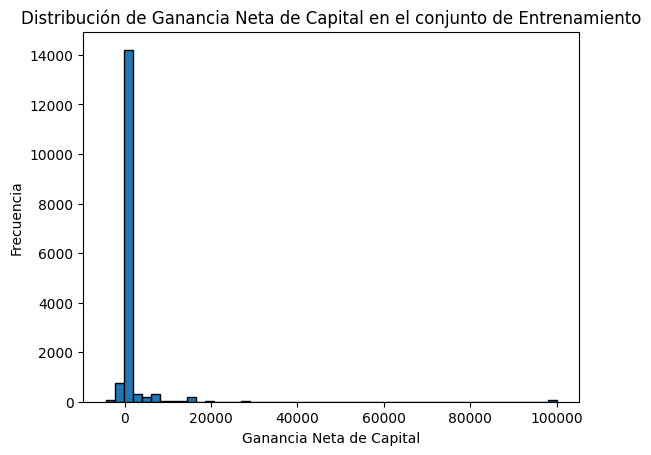

In [ ]:
# Creamos la variable 'net-capital-gain'
X_train['net-capital-gain'] = X_train['capital-gain'] - X_train['capital-loss']
X_val['net-capital-gain'] = X_val['capital-gain'] - X_val['capital-loss']
X_test['net-capital-gain'] = X_test['capital-gain'] - X_test['capital-loss']

# Eliminamos las variables reemplazadas
X_train = X_train.drop(['capital-gain', 'capital-loss'], axis=1)
X_val = X_val.drop(['capital-gain', 'capital-loss'], axis=1)
X_test = X_test.drop(['capital-gain', 'capital-loss'], axis=1)

# Revisamos
print("Columnas después de la transformación:")
print(X_train.columns)
print(X_val.columns)

# Para revisar también visualizamos la distribución
fig, ax = plt.subplots()
ax.hist(X_train['net-capital-gain'], bins=50, edgecolor='black')
ax.set_title('Distribución de Ganancia Neta de Capital en el conjunto de Entrenamiento')
ax.set_xlabel('Ganancia Neta de Capital')
ax.set_ylabel('Frecuencia')
plt.show()

Ahora transformamos la variable `native-country` en una variable binaria para agrupar los países con baja frecuencia en una categoría 'Migrant' y reducir el riesgo de sobreajuste.

Columnas después de la transformación de nacionalidad:
Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'hours-per-week', 'net-capital-gain', 'is-us-citizen'],
      dtype='object')
Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'hours-per-week', 'net-capital-gain', 'is-us-citizen'],
      dtype='object')


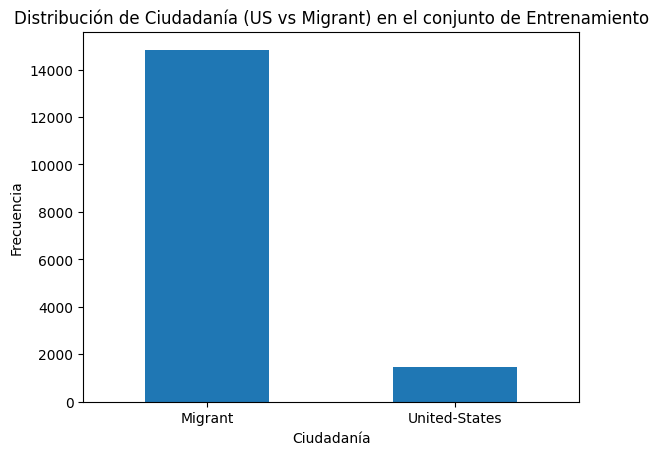

In [ ]:
# Creamos la nueva variable binaria 'is-us-citizen'
X_train['is-us-citizen'] = X_train['native-country'].apply(lambda x: 1 if x == ' United-States' else 0)
X_val['is-us-citizen'] = X_val['native-country'].apply(lambda x: 1 if x == ' United-States' else 0)
X_test['is-us-citizen'] = X_test['native-country'].apply(lambda x: 1 if x == ' United-States' else 0)

# Eliminamos la columna original
X_train = X_train.drop('native-country', axis=1)
X_val = X_val.drop('native-country', axis=1)
X_test = X_test.drop('native-country', axis=1)

# Revisamos
print("Columnas después de la transformación de nacionalidad:")
print(X_train.columns)
print(X_val.columns)

# Para revisar también visualizamos la distribución
fig, ax = plt.subplots()
X_train['is-us-citizen'].value_counts().plot(kind='bar', ax=ax)
ax.set_title('Distribución de Ciudadanía (US vs Migrant) en el conjunto de Entrenamiento')
ax.set_xlabel('Ciudadanía')
ax.set_ylabel('Frecuencia')
plt.xticks([0, 1], ['Migrant', 'United-States'], rotation=0)
plt.show()

Procedemos a realizar un one hot encoding para transformas nuestras vaariables categóricas en variables binarias.

In [ ]:
### Encoding para X
# Separamos las columnas categoricas y numericas con selectdtypes
categorical_cols = X_train.select_dtypes(include='object').columns
numerical_cols = X_train.select_dtypes(include=np.number).columns

# Iniciamos el encoder

# Recomendaciones de la IA que implementamos:
# handle_unknown='ignore' es útil si el conjunto de validación tiene categorías que no están en el entrenamiento
# sparse_output=False devuelve un array denso en lugar de una matriz dispersa
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Lo ajustamos solo a los datos de entreno
X_train_categorical_encoded = encoder.fit_transform(X_train[categorical_cols])
X_val_categorical_encoded = encoder.transform(X_val[categorical_cols])
X_test_categorical_encoded = encoder.transform(X_test[categorical_cols])

# Re-convertimos de arrays a df
X_train_categorical_encoded_df = pd.DataFrame(X_train_categorical_encoded, index=X_train.index, columns=encoder.get_feature_names_out(categorical_cols))
X_val_categorical_encoded_df = pd.DataFrame(X_val_categorical_encoded, index=X_val.index, columns=encoder.get_feature_names_out(categorical_cols))
X_test_categorical_encoded_df = pd.DataFrame(X_test_categorical_encoded, index=X_test.index, columns=encoder.get_feature_names_out(categorical_cols))

# Unimos todo
X_train_processed = pd.concat([X_train[numerical_cols], X_train_categorical_encoded_df], axis=1)
X_val_processed = pd.concat([X_val[numerical_cols], X_val_categorical_encoded_df], axis=1)
X_test_processed = pd.concat([X_test[numerical_cols], X_test_categorical_encoded_df], axis=1)

### Encoding para Y
# Mapeamos las etiquetas de string a numéricas (0 y 1)
# Asumimos que '<=50K' será 0 y '>50K.' o '>50K' será 1
y_train_numeric = y_train['income'].apply(lambda x: 1 if '>50K' in x else 0)
y_val_numeric = y_val['income'].apply(lambda x: 1 if '>50K' in x else 0)
y_test_numeric = y_test['income'].apply(lambda x: 1 if '>50K' in x else 0)

# Convertir a DataFrame para mantener consistencia si es necesario, o usar como Series
y_train_processed = pd.DataFrame(y_train_numeric, columns=['income'])
y_val_processed = pd.DataFrame(y_val_numeric, columns=['income'])
y_test_processed = pd.DataFrame(y_test_numeric, columns=['income'])

# Revisamos dimensiones
print("Dimensiones después del One-Hot Encoding (usando Sklearn):")
print(f"X_train_processed: {X_train_processed.shape}")
print(f"X_val_processed: {X_val_processed.shape}")
print(f"y_train_processed (Numeric): {y_train_processed.shape}")
print(f"y_val_processed (Numeric): {y_val_processed.shape}")

# Mostramos las primeras filas de los datos
print("\nPrimeras filas de X_train_processed:")
display(X_train_processed.head())
print("\nPrimeras filas de X_val_processed:")
display(X_val_processed.head())
print("\nPrimeras filas de y_train_processed (Numeric):")
display(y_train_processed.head())
print("\nPrimeras filas de y_val_processed (Numeric):")
display(y_val_processed.head())


Dimensiones después del One-Hot Encoding (usando Sklearn):
X_train_processed: (16280, 64)
X_val_processed: (16281, 64)
y_train_processed (Numeric): (16280, 1)
y_val_processed (Numeric): (16281, 1)

Primeras filas de X_train_processed:


,age,fnlwgt,education-num,hours-per-week,net-capital-gain,is-us-citizen,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male
10923,30,213722,9,40,0,1,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
12431,43,64631,9,40,0,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
32551,32,34066,6,40,0,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
29677,30,209691,4,40,0,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
29854,35,316141,10,40,7443,1,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0



Primeras filas de X_val_processed:


,age,fnlwgt,education-num,hours-per-week,net-capital-gain,is-us-citizen,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male
14160,27,160178,10,38,0,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
27048,45,50567,9,40,0,1,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
28868,29,185908,13,55,0,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5667,30,190040,13,40,0,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
7827,29,189346,10,50,2202,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0



Primeras filas de y_train_processed (Numeric):


,income
10923,0
12431,0
32551,0
29677,0
29854,0



Primeras filas de y_val_processed (Numeric):


,income
14160,0
27048,0
28868,1
5667,0
7827,0


In [ ]:
print("Columnas en X_train_processed:")
print(X_train_processed.columns.tolist())

print("\nColumnas en X_val_processed:")
print(X_val_processed.columns.tolist())

Columnas en X_train_processed:
['age', 'fnlwgt', 'education-num', 'hours-per-week', 'net-capital-gain', 'is-us-citizen', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Never-worked', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_ 10th', 'education_ 11th', 'education_ 12th', 'education_ 1st-4th', 'education_ 5th-6th', 'education_ 7th-8th', 'education_ 9th', 'education_ Assoc-acdm', 'education_ Assoc-voc', 'education_ Bachelors', 'education_ Doctorate', 'education_ HS-grad', 'education_ Masters', 'education_ Preschool', 'education_ Prof-school', 'education_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ Adm-clerical', 'occupation_ Armed-Forces', 'occupation_ Craft-repai

Finalmente, estandarizamos las variables numéricas para asegurar que tengan una escala similar, lo cual es importante para el buen desempeño de los modelos, especialmente las redes neuronales.

In [ ]:
# Identificamos las columnas numericas y excluimos las binarias
numerical_cols = X_train_processed.select_dtypes(include=np.number).columns.tolist()
binary_cols = [col for col in numerical_cols if X_train_processed[col].nunique() == 2]
numerical_cols_to_scale = [col for col in numerical_cols if col not in binary_cols]
# La IA nos ayudó a crear el código que separa las columnas

# Iniciamos el StandardScaler
scaler = StandardScaler()

# Lo ajustamos solamente a los datos de entrenamiento
X_train_processed[numerical_cols_to_scale] = scaler.fit_transform(X_train_processed[numerical_cols_to_scale])
X_val_processed[numerical_cols_to_scale] = scaler.transform(X_val_processed[numerical_cols_to_scale])
X_test_processed[numerical_cols_to_scale] = scaler.transform(X_test_processed[numerical_cols_to_scale])

# Revisamos
print("Datos estandarizados:")
print("\nPrimeras filas de X_train_processed después de la estandarización:")
display(X_train_processed.head())
print("\nPrimeras filas de X_val_processed después de la estandarización:")
display(X_val_processed.head())

Datos estandarizados:

Primeras filas de X_train_processed después de la estandarización:


,age,fnlwgt,education-num,hours-per-week,net-capital-gain,is-us-citizen,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male
10923,-0.623686,0.228834,-0.425702,-0.037953,-0.132902,1,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
12431,0.328398,-1.182955,-0.425702,-0.037953,-0.132902,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
32551,-0.477212,-1.472385,-1.597636,-0.037953,-0.132902,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
29677,-0.623686,0.190663,-2.378925,-0.037953,-0.132902,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
29854,-0.257500,1.198671,-0.035057,-0.037953,0.920129,1,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0



Primeras filas de X_val_processed después de la estandarización:


,age,fnlwgt,education-num,hours-per-week,net-capital-gain,is-us-citizen,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male
14160,-0.843398,-0.278191,-0.035057,-0.199828,-0.132902,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
27048,0.474872,-1.316131,-0.425702,-0.037953,-0.132902,1,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
28868,-0.696923,-0.034546,1.136877,1.176107,-0.132902,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5667,-0.623686,0.004582,1.136877,-0.037953,-0.132902,1,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
7827,-0.696923,-0.001990,-0.035057,0.771420,0.178636,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


## 2. Desarrollo de algoritmos
### 2.1 Modelo Baseline

In [ ]:
# Empezamos con una regresión logística como modelo base. Esto nos permite tener un punto de referencia antes de usar redes neuronales
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train_processed,y_train_processed)

# evaluamos el modelo en entrenamiento y validación

for name, (X,y) in [('train',(X_train_processed, y_train_processed)), ('Val',(X_val_processed,y_val_processed))]:
  y_pred = logreg.predict(X)
  print(f"=== {name} Métricas (Regresión Logística) ===")
  print("Exactitud:", accuracy_score(y, y_pred))
  print("Precisión:", precision_score(y, y_pred))
  print("Recall:", recall_score(y, y_pred))
  print("F1:", f1_score(y, y_pred))
  print()




/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


=== train Métricas (Regresión Logística) ===
Exactitud: 0.846068796068796
Precisión: 0.722397476340694
Recall: 0.5847803881511746
F1: 0.646344905447361

=== Val Métricas (Regresión Logística) ===
Exactitud: 0.847798046803022
Precisión: 0.7218644587549832
Recall: 0.5997452229299363
F1: 0.6551628165878096



### 2.2 Modelo de Redes Neuronales

#### 2.2.1 Arquitectura base de la red
Creamos una arquitectura generalizada, que podremos cambiar más adelante con facilidad, cambiando únicamente los parametros de la función. Antes de crear la arquitectura, habilitamos el uso de un GPU.

In [ ]:
# Verificamos si hay una GPU y la usamos
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

Usando dispositivo: cuda


In [ ]:
# Arquitectura de MLP

class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_neurons, output_size,
        activation: type[nn.Module] = nn.ReLU,   # <- incluimos activación modificable (ReLu es la usual)
        dropout_p: float | None = None,          # <- Para hacer el dropout despues
        use_logits_output: bool = True           # <- Así obtenemos las eqiquetas
    ):
        super(MLP, self).__init__()
        layers = []

        # Capa de input
        layers.append(nn.Linear(input_size, hidden_neurons))
        layers.append(activation())
        if dropout_p:
            layers.append(nn.Dropout(dropout_p))

        # Capas ocultas
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_neurons, hidden_neurons))
            layers.append(activation())
            if dropout_p:
                layers.append(nn.Dropout(dropout_p))

        # Capa de output
        layers.append(nn.Linear(hidden_neurons, output_size))
        if not use_logits_output:
            layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Seed
torch.manual_seed(45)
if torch.cuda.is_available():
    torch.cuda.manual_seed(45)


# Hiperparametros
input_size = 64
hidden_layers = 6
hidden_neurons = 256
output_size = 1
activation = nn.ReLU
dropout_p = None
use_logits_output = True

learning_rate = 0.001
batch_size = 1024
epochs = 50

model = MLP(
    input_size=input_size,
    hidden_layers=hidden_layers,
    hidden_neurons=hidden_neurons,
    output_size=output_size,
    activation=activation,        # Aca se pueden cambiar las activaciones a otras como nn.LeakyReLU, nn.GELU, etc.
    dropout_p=dropout_p,            # Aca se modifica el dropout
    use_logits_output=use_logits_output,  # Aca podemos pasar el logit a valores binarios
).to(device) # Mover el modelo al dispositivo (GPU si está disponible)

#### 2.2.2 Definimos función de perdida y un optimizador

Usamos Adam Optimization, pues la literatura sugiere que este es el optimizador más veloz y eficiente para la mayoróia de los casos (Gerón, 2019). De igual forma, usamos la entropía cruzada que se usa usualmente en este tipo de modelos.

In [ ]:
# Definir funcion de pérdida y optimizador
# Usamos BCEWithLogitsLoss para clasificación binaria con logits de un solo neurona de salida
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate) # Usamos un optimizador que converge más rapido, como AdamW

####

#### 2.2.3 Entrenamiento y validación
Iniciamos organizando los datos en un formato que nos permite realizar particiones fácilmente entre los datos para crear las redes neuronales.

In [ ]:
# Creamos los datasets que usaremos con nuestra NN
# Convertimos los DataFrames a arrays y luego a tensores
train_dataset = TensorDataset(
    torch.Tensor(X_train_processed.values),
    torch.Tensor(y_train_processed.values).squeeze().long() # Usamos .squeeze().long() para convertir a tensor 1D de tipo long
)
val_dataset = TensorDataset(
    torch.Tensor(X_val_processed.values),
    torch.Tensor(y_val_processed.values).squeeze().long() # Usamos .squeeze().long() para convertir a tensor 1D de tipo long
)
test_dataset = TensorDataset(
    torch.Tensor(X_test_processed.values),
    torch.Tensor(y_test_processed.values).squeeze().long() # Usamos .squeeze().long() para convertir a tensor 1D de tipo long
)


# Creamos loaders para para hacer particiones con los datos
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Con los loaders creados, pasamos a hacer un loop de entrenamiento. El loop nos permite hacer batches de distintos tipos y como output tiene las funciones de perdidas, para hacer una validación de las predicciones.

In [ ]:
# Listas para almacenar las pérdidas y métricas por época
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []


### Loop de entrenamiento

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    train_predictions = []
    train_labels = []

    for batch_x, batch_y in train_loader:
        # Movemos datos al GPU
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        predictions = model(batch_x)

        loss = criterion(predictions, batch_y.float().unsqueeze(1)) # .float() y .unsqueeze(1) para compatibilidad

        # Hacemos el backwards propagation para actualizar los parámetros
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_x.size(0)

        # Calcular entrenamiento accuracy y recoger predicciones/labels para F1
        # Asegurarnos de que es 1D antes de convertir a numpy y list
        predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
        train_total += batch_y.size(0)
        train_correct += (predicted_classes == batch_y.view(-1)).sum().item()

        # Convertir a lista antes de extender
        train_predictions.extend(predicted_classes.cpu().numpy().tolist())
        train_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct / train_total
    train_f1 = f1_score(train_labels, train_predictions)

    # Guardamos las metricas
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_f1_scores.append(train_f1)


    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            # Movemos datos al GPU
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions = model(batch_x)
            loss = criterion(predictions, batch_y.float().unsqueeze(1)) # .float() y .unsqueeze(1) para compatibilidad
            val_loss += loss.item() * batch_x.size(0)

            # Calcular validación accuracy y recoger predicciones/labels para F1
            # Asegurarnos de que es 1D antes de convertir a numpy y list
            predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
            val_total += batch_y.size(0)
            val_correct += (predicted_classes == batch_y.view(-1)).sum().item()

            # Convertir a lista antes de extender
            val_predictions.extend(predicted_classes.cpu().numpy().tolist())
            val_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    val_loss /= len(val_loader.dataset)
    val_accuracy = val_correct / val_total
    val_f1 = f1_score(val_labels, val_predictions)

    # Guardamos las metricas
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)


    print(f"Epoca {epoch+1}: train_loss={train_loss:.4f}, train_accuracy={train_accuracy:.4f}, train_f1={train_f1:.4f}, val_loss={val_loss:.4f}, val_accuracy={val_accuracy:.4f}, val_f1={val_f1:.4f}")

Epoca 1: train_loss=0.5800, train_accuracy=0.7262, train_f1=0.0976, val_loss=0.4555, val_accuracy=0.7589, val_f1=0.0000
Epoca 2: train_loss=0.3964, train_accuracy=0.7692, train_f1=0.1265, val_loss=0.3688, val_accuracy=0.8358, val_f1=0.6577
Epoca 3: train_loss=0.3421, train_accuracy=0.8388, train_f1=0.6556, val_loss=0.3328, val_accuracy=0.8419, val_f1=0.5972
Epoca 4: train_loss=0.3198, train_accuracy=0.8486, train_f1=0.6367, val_loss=0.3217, val_accuracy=0.8526, val_f1=0.6612
Epoca 5: train_loss=0.3127, train_accuracy=0.8532, train_f1=0.6612, val_loss=0.3202, val_accuracy=0.8546, val_f1=0.6779
Epoca 6: train_loss=0.3085, train_accuracy=0.8557, train_f1=0.6680, val_loss=0.3231, val_accuracy=0.8499, val_f1=0.6292
Epoca 7: train_loss=0.3028, train_accuracy=0.8580, train_f1=0.6774, val_loss=0.3187, val_accuracy=0.8539, val_f1=0.6699
Epoca 8: train_loss=0.2988, train_accuracy=0.8601, train_f1=0.6771, val_loss=0.3189, val_accuracy=0.8525, val_f1=0.6597
Epoca 9: train_loss=0.2978, train_accura

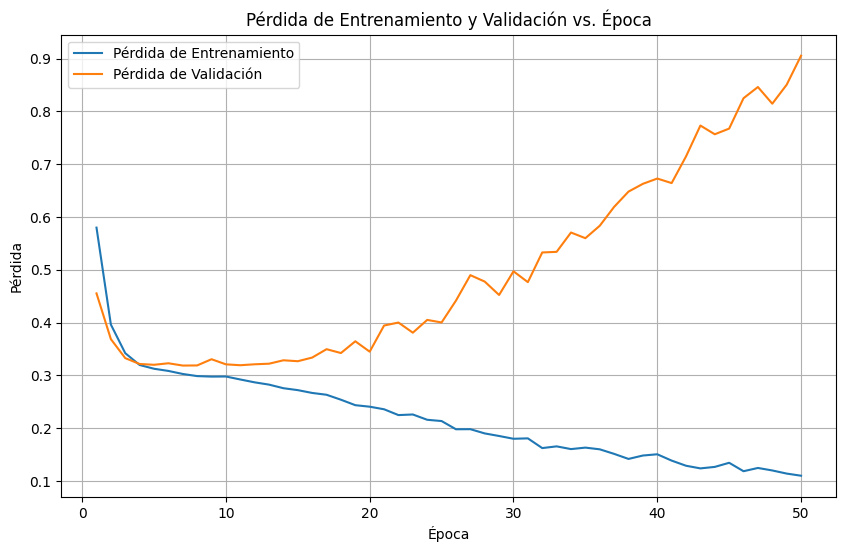

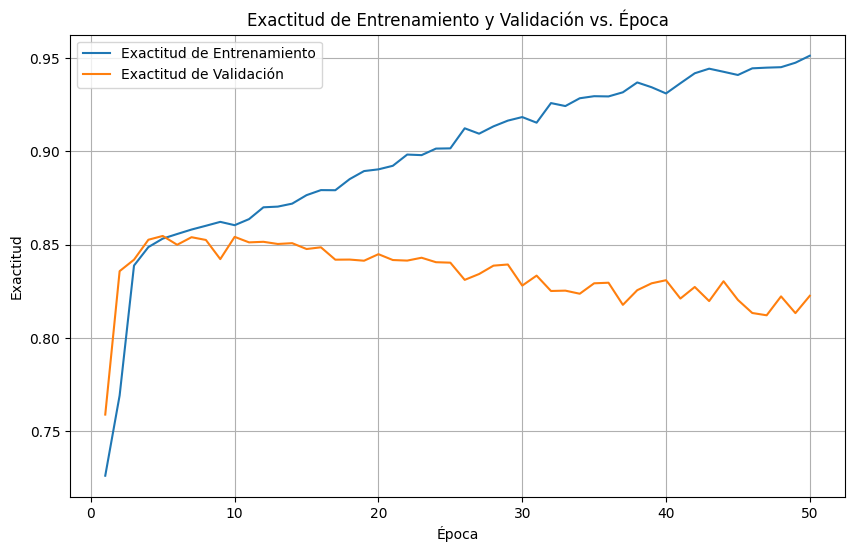

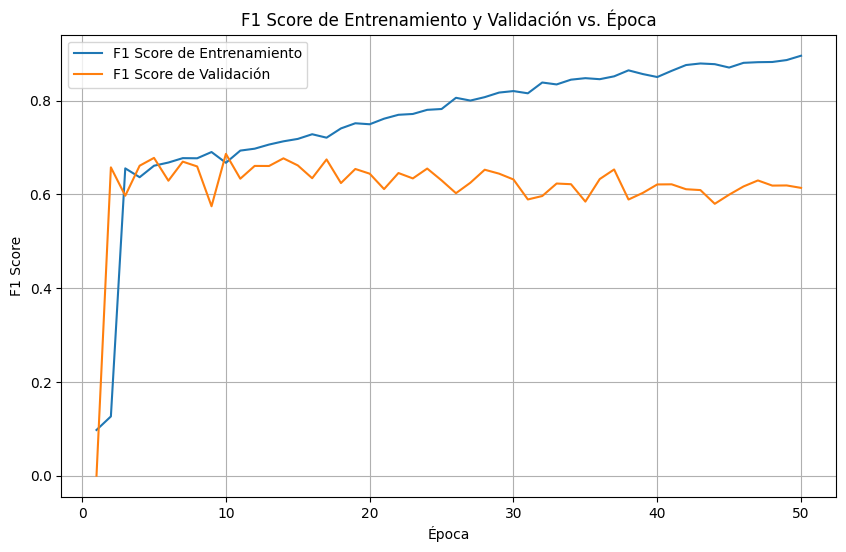

In [ ]:
# Graficar las pérdidas de entrenamiento y validación
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Pérdida de Entrenamiento')
plt.plot(range(1, epochs + 1), val_losses, label='Pérdida de Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación vs. Época')
plt.legend()
plt.grid(True)
plt.show()

# Graficar Accuracy y F1 Score también
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Exactitud de Entrenamiento')
plt.plot(range(1, epochs + 1), val_accuracies, label='Exactitud de Validación')
plt.xlabel('Época')
plt.ylabel('Exactitud')
plt.title('Exactitud de Entrenamiento y Validación vs. Época')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_f1_scores, label='F1 Score de Entrenamiento')
plt.plot(range(1, epochs + 1), val_f1_scores, label='F1 Score de Validación')
plt.xlabel('Época')
plt.ylabel('F1 Score')
plt.title('F1 Score de Entrenamiento y Validación vs. Época')
plt.legend()
plt.grid(True)
plt.show()

### 2.2.4 Experimentos con los datos

En esta sección probamos distintos cambios a nuestro modelo base, con el proposito de encontrar la mejor versión del modelo. Realizaremos cuatro cambios. Uno donde duplicamos la cantidad de neuronas por capas y la cantidad de capas. Otro donde duplicamos la cantidad de capas y dividimos en dos la cantidad de neuronas por capa. Otro donde duplicamos la cantidad de neuronas por capa y dividimos por dos la cantidad de capas. Finalmente, tomamos el mejor modelo y probamos un cambio más: cambiar la función de activación. En los experimentos usamos herramientas de IA, que nos permitieron hacer versiones del mismo codigo del modelo base pero con modificaciones pequeñas.

#### Experimento 1
Comparamos el modelo original con uno que duplica la cantidad de neuronas por capa y otro que las reduce a la mitad.

In [ ]:
# Doble de neuronas

# Hiperparametros
input_size = 64
hidden_layers = 6
hidden_neurons = 512
output_size = 1
activation = nn.ReLU
dropout_p = None
use_logits_output = True

learning_rate = 0.001
batch_size = 64
epochs = 50

model_exp1_double_neurons = MLP(
    input_size=input_size,
    hidden_layers=hidden_layers,
    hidden_neurons=hidden_neurons,
    output_size=output_size,
    activation=activation,        # Aca se pueden cambiar las activaciones a otras como nn.LeakyReLU, nn.GELU, etc.
    dropout_p=dropout_p,            # Aca se modifica el dropout
    use_logits_output=use_logits_output,  # Aca podemos pasar el logit a valores binarios
).to(device) # Mover el modelo al dispositivo (GPU si está disponible)

In [ ]:
# Listas para almacenar las pérdidas y métricas por época para el Experimento 1: Doble de neuronas
train_losses_exp1_double_neurons = []
val_losses_exp1_double_neurons = []
train_accuracies_exp1_double_neurons = []
val_accuracies_exp1_double_neurons = []
train_f1_scores_exp1_double_neurons = []
val_f1_scores_exp1_double_neurons = []

# Definir optimizer for model_exp1_double_neurons
optimizer_exp1_double_neurons = torch.optim.AdamW(model_exp1_double_neurons.parameters(), lr=learning_rate)


### Loop de entrenamiento para el modelo de Experimento 1: Doble de neuronas

for epoch in range(epochs):
    model_exp1_double_neurons.train() # Usar el modelo de experimento 1 con doble de neuronas
    train_loss_exp1_double_neurons = 0
    train_correct_exp1_double_neurons = 0
    train_total_exp1_double_neurons = 0
    train_predictions_exp1_double_neurons = []
    train_labels_exp1_double_neurons = []

    for batch_x, batch_y in train_loader:
        # Movemos datos al GPU
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        predictions = model_exp1_double_neurons(batch_x) # Usar el modelo de experimento 1 con doble de neuronas

        loss = criterion(predictions, batch_y.float().unsqueeze(1)) # .float() y .unsqueeze(1) para compatibilidad

        # Hacemos el backwards propagation para actualizar los parámetros
        optimizer_exp1_double_neurons.zero_grad() # Usar el optimizador para model_exp1_double_neurons
        loss.backward()
        optimizer_exp1_double_neurons.step()

        train_loss_exp1_double_neurons += loss.item() * batch_x.size(0)

        # Calcular entrenamiento accuracy y recoger predicciones/labels para F1
        # Asegurarnos de que es 1D antes de convertir a numpy y list
        predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
        train_total_exp1_double_neurons += batch_y.size(0)
        train_correct_exp1_double_neurons += (predicted_classes == batch_y.view(-1)).sum().item()

        # Convertir a lista antes de extender
        train_predictions_exp1_double_neurons.extend(predicted_classes.cpu().numpy().tolist())
        train_labels_exp1_double_neurons.extend(batch_y.view(-1).cpu().numpy().tolist())

    train_loss_exp1_double_neurons /= len(train_loader.dataset)
    train_accuracy_exp1_double_neurons = train_correct_exp1_double_neurons / train_total_exp1_double_neurons
    train_f1_exp1_double_neurons = f1_score(train_labels_exp1_double_neurons, train_predictions_exp1_double_neurons)

    # Guardamos las metricas
    train_losses_exp1_double_neurons.append(train_loss_exp1_double_neurons)
    train_accuracies_exp1_double_neurons.append(train_accuracy_exp1_double_neurons)
    train_f1_scores_exp1_double_neurons.append(train_f1_exp1_double_neurons)


    model_exp1_double_neurons.eval() # Usar el modelo de experimento 1 con doble de neuronas
    val_loss_exp1_double_neurons = 0
    val_correct_exp1_double_neurons = 0
    val_total_exp1_double_neurons = 0
    val_predictions_exp1_double_neurons = []
    val_labels_exp1_double_neurons = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            # Movemos datos al GPU
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions = model_exp1_double_neurons(batch_x) # Usar el modelo de experimento 1 con doble de neuronas
            loss = criterion(predictions, batch_y.float().unsqueeze(1)) # .float() y .unsqueeze(1) para compatibilidad
            val_loss_exp1_double_neurons += loss.item() * batch_x.size(0)

            # Calcular validación accuracy y recoger predicciones/labels para F1
            # Asegurarnos de que es 1D antes de convertir a numpy y list
            predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
            val_total_exp1_double_neurons += batch_y.size(0)
            val_correct_exp1_double_neurons += (predicted_classes == batch_y.view(-1)).sum().item()

            # Convertir a lista antes de extender
            val_predictions_exp1_double_neurons.extend(predicted_classes.cpu().numpy().tolist())
            val_labels_exp1_double_neurons.extend(batch_y.view(-1).cpu().numpy().tolist())

    val_loss_exp1_double_neurons /= len(val_loader.dataset)
    val_accuracy_exp1_double_neurons = val_correct_exp1_double_neurons / val_total_exp1_double_neurons
    val_f1_exp1_double_neurons = f1_score(val_labels_exp1_double_neurons, val_predictions_exp1_double_neurons)

    # Guardamos las metricas
    val_losses_exp1_double_neurons.append(val_loss_exp1_double_neurons)
    val_accuracies_exp1_double_neurons.append(val_accuracy_exp1_double_neurons)
    val_f1_scores_exp1_double_neurons.append(val_f1_exp1_double_neurons)


    print(f"Epoca {epoch+1}: train_loss={train_loss_exp1_double_neurons:.4f}, train_accuracy={train_accuracy_exp1_double_neurons:.4f}, train_f1={train_f1_exp1_double_neurons:.4f}, val_loss={val_loss_exp1_double_neurons:.4f}, val_accuracy={val_accuracy_exp1_double_neurons:.4f}, val_f1={val_f1_exp1_double_neurons:.4f}")

Epoca 1: train_loss=0.5220, train_accuracy=0.7595, train_f1=0.0000, val_loss=0.3852, val_accuracy=0.7589, val_f1=0.0000
Epoca 2: train_loss=0.3665, train_accuracy=0.8030, train_f1=0.4707, val_loss=0.3426, val_accuracy=0.8425, val_f1=0.6725
Epoca 3: train_loss=0.3290, train_accuracy=0.8441, train_f1=0.6230, val_loss=0.3284, val_accuracy=0.8431, val_f1=0.5996
Epoca 4: train_loss=0.3152, train_accuracy=0.8534, train_f1=0.6534, val_loss=0.3235, val_accuracy=0.8534, val_f1=0.6718
Epoca 5: train_loss=0.3090, train_accuracy=0.8561, train_f1=0.6652, val_loss=0.3201, val_accuracy=0.8542, val_f1=0.6737
Epoca 6: train_loss=0.3022, train_accuracy=0.8604, train_f1=0.6848, val_loss=0.3200, val_accuracy=0.8503, val_f1=0.6379
Epoca 7: train_loss=0.3001, train_accuracy=0.8596, train_f1=0.6708, val_loss=0.3189, val_accuracy=0.8522, val_f1=0.6596
Epoca 8: train_loss=0.2940, train_accuracy=0.8620, train_f1=0.6800, val_loss=0.3215, val_accuracy=0.8536, val_f1=0.6726
Epoca 9: train_loss=0.2883, train_accura

In [ ]:
import torch.nn as nn

# Hiperparametros para el Experimento 1: Mitad de neuronas
input_size = 64
hidden_layers_exp1_half_neurons = 6
hidden_neurons_exp1_half_neurons = 128 # Mitad de neuronas
output_size = 1
activation = nn.ReLU
dropout_p = None
use_logits_output = True

# Seed
torch.manual_seed(45)
if torch.cuda.is_available():
    torch.cuda.manual_seed(45)

model_exp1_half_neurons = MLP(
    input_size=input_size,
    hidden_layers=hidden_layers_exp1_half_neurons,
    hidden_neurons=hidden_neurons_exp1_half_neurons,
    output_size=output_size,
    activation=activation,
    dropout_p=dropout_p,
    use_logits_output=use_logits_output,
).to(device)

In [ ]:
# Listas para almacenar las pérdidas y métricas por época para el Experimento 1: Mitad de neuronas
train_losses_exp1_half_neurons = []
val_losses_exp1_half_neurons = []
train_accuracies_exp1_half_neurons = []
val_accuracies_exp1_half_neurons = []
train_f1_scores_exp1_half_neurons = []
val_f1_scores_exp1_half_neurons = []

# Definir optimizer for model_exp1_half_neurons
optimizer_exp1_half_neurons = torch.optim.AdamW(model_exp1_half_neurons.parameters(), lr=learning_rate)


### Loop de entrenamiento para el modelo de Experimento 1: Mitad de neuronas

for epoch in range(epochs):
    model_exp1_half_neurons.train() # Usar el modelo de experimento 1 con mitad de neuronas
    train_loss_exp1_half_neurons = 0
    train_correct_exp1_half_neurons = 0
    train_total_exp1_half_neurons = 0
    train_predictions_exp1_half_neurons = []
    train_labels_exp1_half_neurons = []

    for batch_x, batch_y in train_loader:
        # Movemos datos al GPU
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        predictions = model_exp1_half_neurons(batch_x) # Usar el modelo de experimento 1 con mitad de neuronas

        loss = criterion(predictions, batch_y.float().unsqueeze(1)) # .float() y .unsqueeze(1) para compatibilidad

        # Hacemos el backwards propagation para actualizar los parámetros
        optimizer_exp1_half_neurons.zero_grad() # Usar el optimizador para model_exp1_half_neurons
        loss.backward()
        optimizer_exp1_half_neurons.step()

        train_loss_exp1_half_neurons += loss.item() * batch_x.size(0)

        # Calcular entrenamiento accuracy y recoger predicciones/labels para F1
        # Asegurarnos de que es 1D antes de convertir a numpy y list
        predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
        train_total_exp1_half_neurons += batch_y.size(0)
        train_correct_exp1_half_neurons += (predicted_classes == batch_y.view(-1)).sum().item()

        # Convertir a lista antes de extender
        train_predictions_exp1_half_neurons.extend(predicted_classes.cpu().numpy().tolist())
        train_labels_exp1_half_neurons.extend(batch_y.view(-1).cpu().numpy().tolist())

    train_loss_exp1_half_neurons /= len(train_loader.dataset)
    train_accuracy_exp1_half_neurons = train_correct_exp1_half_neurons / train_total_exp1_half_neurons
    train_f1_exp1_half_neurons = f1_score(train_labels_exp1_half_neurons, train_predictions_exp1_half_neurons)

    # Guardamos las metricas
    train_losses_exp1_half_neurons.append(train_loss_exp1_half_neurons)
    train_accuracies_exp1_half_neurons.append(train_accuracy_exp1_half_neurons)
    train_f1_scores_exp1_half_neurons.append(train_f1_exp1_half_neurons)


    model_exp1_half_neurons.eval() # Usar el modelo de experimento 1 con mitad de neuronas
    val_loss_exp1_half_neurons = 0
    val_correct_exp1_half_neurons = 0
    val_total_exp1_half_neurons = 0
    val_predictions_exp1_half_neurons = []
    val_labels_exp1_half_neurons = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            # Movemos datos al GPU
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions = model_exp1_half_neurons(batch_x) # Usar el modelo de experimento 1 con mitad de neuronas
            loss = criterion(predictions, batch_y.float().unsqueeze(1)) # .float() y .unsqueeze(1) para compatibilidad
            val_loss_exp1_half_neurons += loss.item() * batch_x.size(0)

            # Calcular validación accuracy y recoger predicciones/labels para F1
            # Asegurarnos de que es 1D antes de convertir a numpy y list
            predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
            val_total_exp1_half_neurons += batch_y.size(0)
            val_correct_exp1_half_neurons += (predicted_classes == batch_y.view(-1)).sum().item()

            # Convertir a lista antes de extender
            val_predictions_exp1_half_neurons.extend(predicted_classes.cpu().numpy().tolist())
            val_labels_exp1_half_neurons.extend(batch_y.view(-1).cpu().numpy().tolist())

    val_loss_exp1_half_neurons /= len(val_loader.dataset)
    val_accuracy_exp1_half_neurons = val_correct_exp1_half_neurons / val_total_exp1_half_neurons
    val_f1_exp1_half_neurons = f1_score(val_labels_exp1_half_neurons, val_predictions_exp1_half_neurons)

    # Guardamos las metricas
    val_losses_exp1_half_neurons.append(val_loss_exp1_half_neurons)
    val_accuracies_exp1_half_neurons.append(val_accuracy_exp1_half_neurons)
    val_f1_scores_exp1_half_neurons.append(val_f1_exp1_half_neurons)


    print(f"Epoca {epoch+1}: train_loss={train_loss_exp1_half_neurons:.4f}, train_accuracy={train_accuracy_exp1_half_neurons:.4f}, train_f1={train_f1_exp1_half_neurons:.4f}, val_loss={val_loss_exp1_half_neurons:.4f}, val_accuracy={val_accuracy_exp1_half_neurons:.4f}, val_f1={val_f1_exp1_half_neurons:.4f}")

Epoca 1: train_loss=0.6293, train_accuracy=0.6942, train_f1=0.1670, val_loss=0.5199, val_accuracy=0.7589, val_f1=0.0000
Epoca 2: train_loss=0.4522, train_accuracy=0.7595, train_f1=0.0000, val_loss=0.3874, val_accuracy=0.7589, val_f1=0.0000
Epoca 3: train_loss=0.3717, train_accuracy=0.7891, train_f1=0.3806, val_loss=0.3625, val_accuracy=0.8280, val_f1=0.6729
Epoca 4: train_loss=0.3441, train_accuracy=0.8377, train_f1=0.6596, val_loss=0.3336, val_accuracy=0.8445, val_f1=0.6737
Epoca 5: train_loss=0.3233, train_accuracy=0.8488, train_f1=0.6626, val_loss=0.3235, val_accuracy=0.8528, val_f1=0.6712
Epoca 6: train_loss=0.3153, train_accuracy=0.8523, train_f1=0.6676, val_loss=0.3237, val_accuracy=0.8530, val_f1=0.6604
Epoca 7: train_loss=0.3115, train_accuracy=0.8555, train_f1=0.6676, val_loss=0.3202, val_accuracy=0.8546, val_f1=0.6760
Epoca 8: train_loss=0.3061, train_accuracy=0.8581, train_f1=0.6788, val_loss=0.3208, val_accuracy=0.8546, val_f1=0.6837
Epoca 9: train_loss=0.3032, train_accura

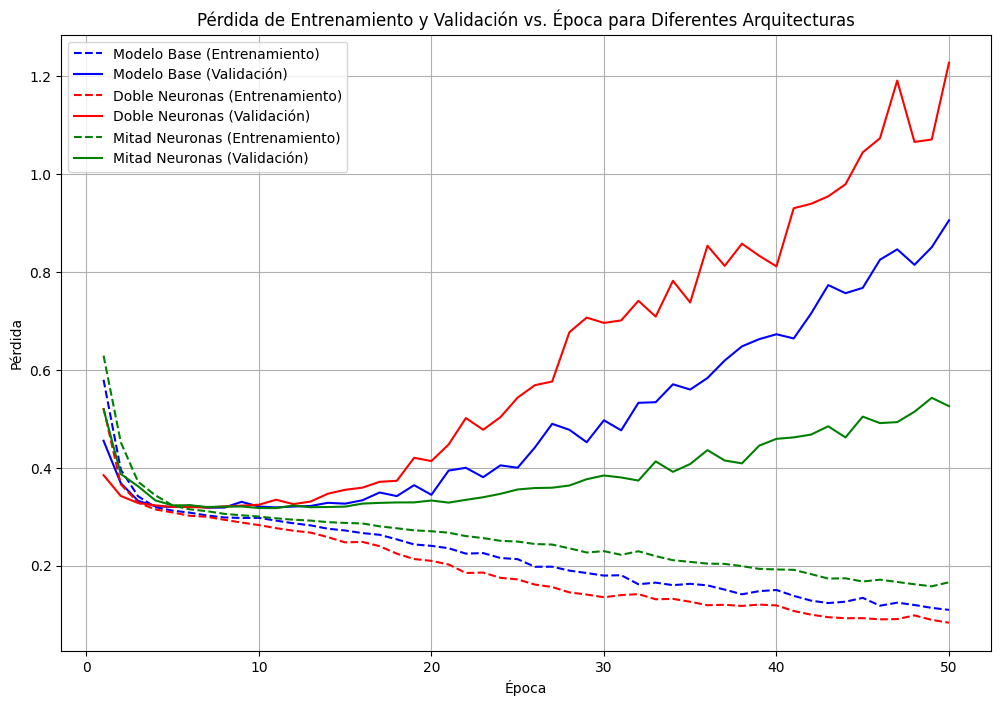

In [ ]:
# Graficar las pérdidas de entrenamiento y validación para los tres modelos
plt.figure(figsize=(12, 8))
plt.plot(range(1, epochs + 1), train_losses, label='Modelo Base (Entrenamiento)', linestyle='--', color='blue')
plt.plot(range(1, epochs + 1), val_losses, label='Modelo Base (Validación)', color='blue')
plt.plot(range(1, epochs + 1), train_losses_exp1_double_neurons, label='Doble Neuronas (Entrenamiento)', linestyle='--', color='red')
plt.plot(range(1, epochs + 1), val_losses_exp1_double_neurons, label='Doble Neuronas (Validación)', color='red')
plt.plot(range(1, epochs + 1), train_losses_exp1_half_neurons, label='Mitad Neuronas (Entrenamiento)', linestyle='--', color='green')
plt.plot(range(1, epochs + 1), val_losses_exp1_half_neurons, label='Mitad Neuronas (Validación)', color='green')

plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación vs. Época para Diferentes Arquitecturas')
plt.legend()
plt.grid(True)
plt.show()

Comparamos el modelo original con el modelo con el doble y la mitad de neuronas.

In [ ]:
# Calcular el mínimo error de entrenamiento para cada modelo
min_train_loss_base = min(train_losses)
min_train_loss_double_neurons = min(train_losses_exp1_double_neurons)
min_train_loss_half_neurons = min(train_losses_exp1_half_neurons)

print(f"Mínimo error de entrenamiento del Modelo Base: {min_train_loss_base:.4f}")
print(f"Mínimo error de entrenamiento del Modelo con Doble Neuronas: {min_train_loss_double_neurons:.4f}")
print(f"Mínimo error de entrenamiento del Modelo con Mitad de Neuronas: {min_train_loss_half_neurons:.4f}")

# Determinar qué modelo tiene el menor mínimo error de entrenamiento
if min_train_loss_base <= min_train_loss_double_neurons and min_train_loss_base <= min_train_loss_half_neurons:
    print("\nEl Modelo Base tiene el menor mínimo error de entrenamiento.")
elif min_train_loss_double_neurons <= min_train_loss_base and min_train_loss_double_neurons <= min_train_loss_half_neurons:
    print("\nEl Modelo con Doble Neuronas tiene el menor mínimo error de entrenamiento.")
else:
    print("\nEl Modelo con Mitad de Neuronas tiene el menor mínimo error de entrenamiento.")

Mínimo error de entrenamiento del Modelo Base: 0.1100
Mínimo error de entrenamiento del Modelo con Doble Neuronas: 0.0838
Mínimo error de entrenamiento del Modelo con Mitad de Neuronas: 0.1582

El Modelo con Doble Neuronas tiene el menor mínimo error de entrenamiento.


#### Experimento 2
Comparamos el modelo original con uno que duplica la cantidad de capas y otro que las reduce a la mitad, manteniendo constante la cantidad de neuronas.

In [ ]:
# Doble de capas

# Hiperparametros para el Experimento 2: Doble de capas
input_size = 64
hidden_layers_exp2_double_layers = 12
hidden_neurons = 256
output_size = 1
activation = nn.ReLU
dropout_p = None
use_logits_output = True

learning_rate = 0.001
batch_size = 1024 # Usar el batch size original
epochs = 50

# Seed
torch.manual_seed(45)
if torch.cuda.is_available():
    torch.cuda.manual_seed(45)

model_exp2_double_layers = MLP(
    input_size=input_size,
    hidden_layers=hidden_layers_exp2_double_layers,
    hidden_neurons=hidden_neurons,
    output_size=output_size,
    activation=activation,
    dropout_p=dropout_p,
    use_logits_output=use_logits_output,
).to(device)

print("Model Experiment 2 (Double Layers) created:")
print(model_exp2_double_layers)

Model Experiment 2 (Double Layers) created:
MLP(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=256, bias=True)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): ReLU()
    (14): Linear(in_features=256, out_features=256, bias=True)
    (15): ReLU()
    (16): Linear(in_features=256, out_features=256, bias=True)
    (17): ReLU()
    (18): Linear(in_features=256, out_features=256, bias=True)
    (19): ReLU()
    (20): Linear(in_features=256, out_features=256, bias=True)
    (21): ReLU()
    (22): Linear(in_features=256, out_features=256, bias=Tr

In [ ]:
# Listas para almacenar las pérdidas y métricas por época para el Experimento 2: Doble de capas
train_losses_exp2_double_layers = []
val_losses_exp2_double_layers = []
train_accuracies_exp2_double_layers = []
val_accuracies_exp2_double_layers = []
train_f1_scores_exp2_double_layers = []
val_f1_scores_exp2_double_layers = []

# Definir optimizer for model_exp2_double_layers
optimizer_exp2_double_layers = torch.optim.AdamW(model_exp2_double_layers.parameters(), lr=learning_rate)


### Loop de entrenamiento para el modelo de Experimento 2: Doble de capas

for epoch in range(epochs):
    model_exp2_double_layers.train() # Usar el modelo de experimento 2 con doble de capas
    train_loss_exp2_double_layers = 0
    train_correct_exp2_double_layers = 0
    train_total_exp2_double_layers = 0
    train_predictions_exp2_double_layers = []
    train_labels_exp2_double_layers = []

    for batch_x, batch_y in train_loader:
        # Movemos datos al GPU
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        predictions = model_exp2_double_layers(batch_x) # Usar el modelo de experimento 2 con doble de capas

        loss = criterion(predictions, batch_y.float().unsqueeze(1)) # .float() y .unsqueeze(1) para compatibilidad

        # Hacemos el backwards propagation para actualizar los parámetros
        optimizer_exp2_double_layers.zero_grad() # Usar el optimizador para model_exp2_double_layers
        loss.backward()
        optimizer_exp2_double_layers.step()

        train_loss_exp2_double_layers += loss.item() * batch_x.size(0)

        # Calcular entrenamiento accuracy y recoger predicciones/labels para F1
        # Asegurarnos de que es 1D antes de convertir a numpy y list
        predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
        train_total_exp2_double_layers += batch_y.size(0)
        train_correct_exp2_double_layers += (predicted_classes == batch_y.view(-1)).sum().item()

        # Convertir a lista antes de extender
        train_predictions_exp2_double_layers.extend(predicted_classes.cpu().numpy().tolist())
        train_labels_exp2_double_layers.extend(batch_y.view(-1).cpu().numpy().tolist())


    train_loss_exp2_double_layers /= len(train_loader.dataset)
    train_accuracy_exp2_double_layers = train_correct_exp2_double_layers / train_total_exp2_double_layers
    train_f1_exp2_double_layers = f1_score(train_labels_exp2_double_layers, train_predictions_exp2_double_layers)

    # Guardamos las metricas
    train_losses_exp2_double_layers.append(train_loss_exp2_double_layers)
    train_accuracies_exp2_double_layers.append(train_accuracy_exp2_double_layers)
    train_f1_scores_exp2_double_layers.append(train_f1_exp2_double_layers)

    model_exp2_double_layers.eval() # Usar el modelo de experimento 2 con doble de capas
    val_loss_exp2_double_layers = 0
    val_correct_exp2_double_layers = 0
    val_total_exp2_double_layers = 0
    val_predictions_exp2_double_layers = []
    val_labels_exp2_double_layers = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            # Movemos datos al GPU
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions = model_exp2_double_layers(batch_x) # Usar el modelo de experimento 2 con doble de capas
            loss = criterion(predictions, batch_y.float().unsqueeze(1)) # .float() y .unsqueeze(1) para compatibilidad
            val_loss_exp2_double_layers += loss.item() * batch_x.size(0)

            # Calcular validación accuracy y recoger predicciones/labels para F1
            # Asegurarnos de que es 1D antes de convertir a numpy y list
            predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
            val_total_exp2_double_layers += batch_y.size(0)
            val_correct_exp2_double_layers += (predicted_classes == batch_y.view(-1)).sum().item()

            # Convertir a lista antes de extender
            val_predictions_exp2_double_layers.extend(predicted_classes.cpu().numpy().tolist())
            val_labels_exp2_double_layers.extend(batch_y.view(-1).cpu().numpy().tolist())


    val_loss_exp2_double_layers /= len(val_loader.dataset)
    val_accuracy_exp2_double_layers = val_correct_exp2_double_layers / val_total_exp2_double_layers
    val_f1_exp2_double_layers = f1_score(val_labels_exp2_double_layers, val_predictions_exp2_double_layers)

    # Guardamos las metricas
    val_losses_exp2_double_layers.append(val_loss_exp2_double_layers)
    val_accuracies_exp2_double_layers.append(val_accuracy_exp2_double_layers)
    val_f1_scores_exp2_double_layers.append(val_f1_exp2_double_layers)


    print(f"Epoca {epoch+1}: train_loss={train_loss_exp2_double_layers:.4f}, train_accuracy={train_accuracy_exp2_double_layers:.4f}, train_f1={train_f1_exp2_double_layers:.4f}, val_loss={val_loss_exp2_double_layers:.4f}, val_accuracy={val_accuracy_exp2_double_layers:.4f}, val_f1={val_f1_exp2_double_layers:.4f}")

Epoca 1: train_loss=0.5990, train_accuracy=0.7595, train_f1=0.0000, val_loss=0.5088, val_accuracy=0.7589, val_f1=0.0000
Epoca 2: train_loss=0.4253, train_accuracy=0.7595, train_f1=0.0000, val_loss=0.3859, val_accuracy=0.7589, val_f1=0.0000
Epoca 3: train_loss=0.3689, train_accuracy=0.7596, train_f1=0.0010, val_loss=0.3602, val_accuracy=0.7844, val_f1=0.2026
Epoca 4: train_loss=0.3345, train_accuracy=0.8413, train_f1=0.6402, val_loss=0.3316, val_accuracy=0.8506, val_f1=0.6840
Epoca 5: train_loss=0.3171, train_accuracy=0.8529, train_f1=0.6625, val_loss=0.3204, val_accuracy=0.8538, val_f1=0.6700
Epoca 6: train_loss=0.3101, train_accuracy=0.8539, train_f1=0.6644, val_loss=0.3338, val_accuracy=0.8546, val_f1=0.6653
Epoca 7: train_loss=0.3068, train_accuracy=0.8561, train_f1=0.6721, val_loss=0.3261, val_accuracy=0.8495, val_f1=0.6317
Epoca 8: train_loss=0.3032, train_accuracy=0.8588, train_f1=0.6754, val_loss=0.3218, val_accuracy=0.8546, val_f1=0.6732
Epoca 9: train_loss=0.3002, train_accura

In [ ]:
# Mitad de capas

# Hiperparametros para el Experimento 2: Mitad de capas
input_size = 64
hidden_layers_exp2_half_layers = 3 # Mitad de capas
hidden_neurons = 256 # Mantener neuronas originales
output_size = 1
activation = nn.ReLU
dropout_p = None
use_logits_output = True

# Seed
torch.manual_seed(45)
if torch.cuda.is_available():
    torch.cuda.manual_seed(45)

model_exp2_half_layers = MLP(
    input_size=input_size,
    hidden_layers=hidden_layers_exp2_half_layers,
    hidden_neurons=hidden_neurons,
    output_size=output_size,
    activation=activation,
    dropout_p=dropout_p,
    use_logits_output=use_logits_output,
).to(device)

In [ ]:
# Listas para almacenar las pérdidas y métricas por época para el Experimento 2: Mitad de capas
train_losses_exp2_half_layers = []
val_losses_exp2_half_layers = []
train_accuracies_exp2_half_layers = []
val_accuracies_exp2_half_layers = []
train_f1_scores_exp2_half_layers = []
val_f1_scores_exp2_half_layers = []

# Definir optimizer for model_exp2_half_layers
optimizer_exp2_half_layers = torch.optim.AdamW(model_exp2_half_layers.parameters(), lr=learning_rate)

### Loop de entrenamiento para el modelo de Experimento 2: Mitad de capas

for epoch in range(epochs):
    model_exp2_half_layers.train() # Usar el modelo de experimento 2 con mitad de capas
    train_loss_exp2_half_layers = 0
    train_correct_exp2_half_layers = 0
    train_total_exp2_half_layers = 0
    train_predictions_exp2_half_layers = []
    train_labels_exp2_half_layers = []

    for batch_x, batch_y in train_loader:
        # Movemos datos al GPU
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        predictions = model_exp2_half_layers(batch_x) # Usar el modelo de experimento 2 con mitad de capas

        loss = criterion(predictions, batch_y.float().unsqueeze(1)) # .float() y .unsqueeze(1) para compatibilidad

        # Hacemos el backwards propagation para actualizar los parámetros
        optimizer_exp2_half_layers.zero_grad() # Usar el optimizador para model_exp2_half_layers
        loss.backward()
        optimizer_exp2_half_layers.step()

        train_loss_exp2_half_layers += loss.item() * batch_x.size(0)

        # Calcular entrenamiento accuracy y recoger predicciones/labels para F1
        # Asegurarnos de que es 1D antes de convertir a numpy y list
        predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
        train_total_exp2_half_layers += batch_y.size(0)
        train_correct_exp2_half_layers += (predicted_classes == batch_y.view(-1)).sum().item()

        # Convertir a lista antes de extender
        train_predictions_exp2_half_layers.extend(predicted_classes.cpu().numpy().tolist())
        train_labels_exp2_half_layers.extend(batch_y.view(-1).cpu().numpy().tolist())

    train_loss_exp2_half_layers /= len(train_loader.dataset)
    train_accuracy_exp2_half_layers = train_correct_exp2_half_layers / train_total_exp2_half_layers
    train_f1_exp2_half_layers = f1_score(train_labels_exp2_half_layers, train_predictions_exp2_half_layers)

    # Guardamos las metricas
    train_losses_exp2_half_layers.append(train_loss_exp2_half_layers)
    train_accuracies_exp2_half_layers.append(train_accuracy_exp2_half_layers)
    train_f1_scores_exp2_half_layers.append(train_f1_exp2_half_layers)

    model_exp2_half_layers.eval() # Usar el modelo de experimento 2 con mitad de capas
    val_loss_exp2_half_layers = 0
    val_correct_exp2_half_layers = 0
    val_total_exp2_half_layers = 0
    val_predictions_exp2_half_layers = []
    val_labels_exp2_half_layers = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            # Movemos datos al GPU
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions = model_exp2_half_layers(batch_x) # Usar el modelo de experimento 2 con mitad de capas
            loss = criterion(predictions, batch_y.float().unsqueeze(1)) # .float() y .unsqueeze(1) para compatibilidad
            val_loss_exp2_half_layers += loss.item() * batch_x.size(0)

            # Calcular validación accuracy y recoger predicciones/labels para F1
            # Asegurarnos de que es 1D antes de convertir a numpy y list
            predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
            val_total_exp2_half_layers += batch_y.size(0)
            val_correct_exp2_half_layers += (predicted_classes == batch_y.view(-1)).sum().item()

            # Convertir a lista antes de extender
            val_predictions_exp2_half_layers.extend(predicted_classes.cpu().numpy().tolist())
            val_labels_exp2_half_layers.extend(batch_y.view(-1).cpu().numpy().tolist())


    val_loss_exp2_half_layers /= len(val_loader.dataset)
    val_accuracy_exp2_half_layers = val_correct_exp2_half_layers / val_total_exp2_half_layers
    val_f1_exp2_half_layers = f1_score(val_labels_exp2_half_layers, val_predictions_exp2_half_layers)

    # Guardamos las metricas
    val_losses_exp2_half_layers.append(val_loss_exp2_half_layers)
    val_accuracies_exp2_half_layers.append(val_accuracy_exp2_half_layers)
    val_f1_scores_exp2_half_layers.append(val_f1_exp2_half_layers)


    print(f"Epoca {epoch+1}: train_loss={train_loss_exp2_half_layers:.4f}, train_accuracy={train_accuracy_exp2_half_layers:.4f}, train_f1={train_f1_exp2_half_layers:.4f}, val_loss={val_loss_exp2_half_layers:.4f}, val_accuracy={val_accuracy_exp2_half_layers:.4f}, val_f1={val_f1_exp2_half_layers:.4f}")

Epoca 1: train_loss=0.5324, train_accuracy=0.7615, train_f1=0.0187, val_loss=0.3910, val_accuracy=0.8074, val_f1=0.3863
Epoca 2: train_loss=0.3612, train_accuracy=0.8246, train_f1=0.6196, val_loss=0.3456, val_accuracy=0.8417, val_f1=0.6744
Epoca 3: train_loss=0.3297, train_accuracy=0.8439, train_f1=0.6610, val_loss=0.3265, val_accuracy=0.8507, val_f1=0.6757
Epoca 4: train_loss=0.3185, train_accuracy=0.8500, train_f1=0.6615, val_loss=0.3216, val_accuracy=0.8546, val_f1=0.6804
Epoca 5: train_loss=0.3136, train_accuracy=0.8539, train_f1=0.6733, val_loss=0.3239, val_accuracy=0.8530, val_f1=0.6597
Epoca 6: train_loss=0.3082, train_accuracy=0.8553, train_f1=0.6758, val_loss=0.3205, val_accuracy=0.8525, val_f1=0.6878
Epoca 7: train_loss=0.3042, train_accuracy=0.8566, train_f1=0.6784, val_loss=0.3197, val_accuracy=0.8547, val_f1=0.6713
Epoca 8: train_loss=0.3016, train_accuracy=0.8578, train_f1=0.6846, val_loss=0.3226, val_accuracy=0.8483, val_f1=0.6894
Epoca 9: train_loss=0.2984, train_accura

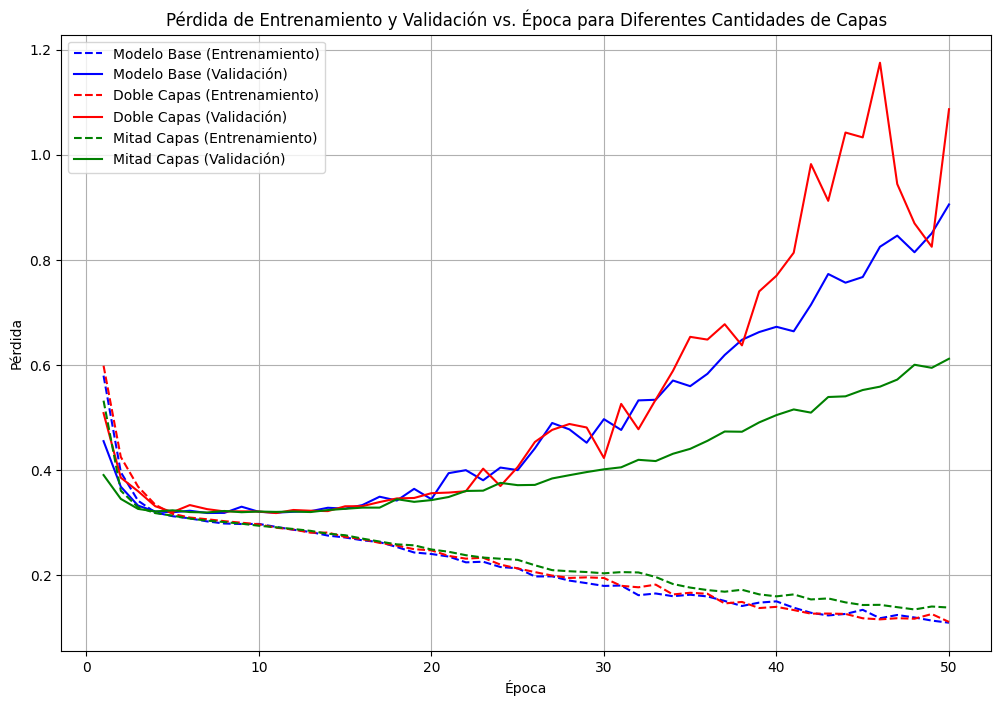

In [ ]:
# Graficar las pérdidas de entrenamiento y validación para los tres modelos del Experimento 2
plt.figure(figsize=(12, 8))
plt.plot(range(1, epochs + 1), train_losses, label='Modelo Base (Entrenamiento)', linestyle='--', color='blue')
plt.plot(range(1, epochs + 1), val_losses, label='Modelo Base (Validación)', color='blue')
plt.plot(range(1, epochs + 1), train_losses_exp2_double_layers, label='Doble Capas (Entrenamiento)', linestyle='--', color='red')
plt.plot(range(1, epochs + 1), val_losses_exp2_double_layers, label='Doble Capas (Validación)', color='red')
plt.plot(range(1, epochs + 1), train_losses_exp2_half_layers, label='Mitad Capas (Entrenamiento)', linestyle='--', color='green')
plt.plot(range(1, epochs + 1), val_losses_exp2_half_layers, label='Mitad Capas (Validación)', color='green')

plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación vs. Época para Diferentes Cantidades de Capas')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calcular el mínimo error de entrenamiento para cada modelo del Experimento 2
min_train_loss_base = min(train_losses)
min_train_loss_double_layers = min(train_losses_exp2_double_layers)
min_train_loss_half_layers = min(train_losses_exp2_half_layers)

print(f"Mínimo error de entrenamiento del Modelo Base: {min_train_loss_base:.4f}")
print(f"Mínimo error de entrenamiento del Modelo con Doble Capas: {min_train_loss_double_layers:.4f}")
print(f"Mínimo error de entrenamiento del Modelo con Mitad de Capas: {min_train_loss_half_layers:.4f}")

# Determinar qué modelo tiene el menor mínimo error de entrenamiento en el Experimento 2
if min_train_loss_base <= min_train_loss_double_layers and min_train_loss_base <= min_train_loss_half_layers:
    print("\nEl Modelo Base tiene el menor mínimo error de entrenamiento en el Experimento 2.")
elif min_train_loss_double_layers <= min_train_loss_base and min_train_loss_double_layers <= min_train_loss_half_layers:
    print("\nEl Modelo con Doble Capas tiene el menor mínimo error de entrenamiento en el Experimento 2.")
else:
    print("\nEl Modelo con Mitad de Capas tiene el menor mínimo error de entrenamiento en el Experimento 2.")

Mínimo error de entrenamiento del Modelo Base: 0.1100
Mínimo error de entrenamiento del Modelo con Doble Capas: 0.1115
Mínimo error de entrenamiento del Modelo con Mitad de Capas: 0.1353

El Modelo Base tiene el menor mínimo error de entrenamiento en el Experimento 2.


#### Experimento 3
Comparamos el modelo original con uno que duplica el tamaño del batch y otro que lo reduce a la mitad, manteniendo constante la cantidad de capas y neuronas.

In [ ]:
# Doble de batch size

# Hiperparametros para el Experimento 3: Doble de batch size
input_size = 64
hidden_layers = 6
hidden_neurons = 256
output_size = 1
activation = nn.ReLU
dropout_p = None
use_logits_output = True

learning_rate = 0.001
batch_size_exp3_double_batch = 2048 # Doble de batch size
epochs = 50

# Seed
torch.manual_seed(45)
if torch.cuda.is_available():
    torch.cuda.manual_seed(45)

model_exp3_double_batch = MLP(
    input_size=input_size,
    hidden_layers=hidden_layers,
    hidden_neurons=hidden_neurons,
    output_size=output_size,
    activation=activation,
    dropout_p=dropout_p,
    use_logits_output=use_logits_output,
).to(device)

print("Model Experiment 3 (Double Batch Size) created:")
print(model_exp3_double_batch)

# Definir optimizer for model_exp3_double_batch
optimizer_exp3_double_batch = torch.optim.AdamW(model_exp3_double_batch.parameters(), lr=learning_rate)

# Crear DataLoader con el nuevo batch size
train_loader_exp3_double_batch = DataLoader(train_dataset, batch_size=batch_size_exp3_double_batch, shuffle=True)
val_loader_exp3_double_batch = DataLoader(val_dataset, batch_size=batch_size_exp3_double_batch)

Model Experiment 3 (Double Batch Size) created:
MLP(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=256, bias=True)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [ ]:
# Listas para almacenar las pérdidas y métricas por época para el Experimento 3: Doble de batch size
train_losses_exp3_double_batch = []
val_losses_exp3_double_batch = []
train_accuracies_exp3_double_batch = []
val_accuracies_exp3_double_batch = []
train_f1_scores_exp3_double_batch = []
val_f1_scores_exp3_double_batch = []

### Loop de entrenamiento para el modelo de Experimento 3: Doble de batch size

for epoch in range(epochs):
    model_exp3_double_batch.train() # Usar el modelo de experimento 3 con doble de batch size
    train_loss_exp3_double_batch = 0
    train_correct_exp3_double_batch = 0
    train_total_exp3_double_batch = 0
    train_predictions_exp3_double_batch = []
    train_labels_exp3_double_batch = []

    for batch_x, batch_y in train_loader_exp3_double_batch: # Usar el DataLoader con doble batch size
        # Movemos datos al GPU
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        predictions = model_exp3_double_batch(batch_x) # Usar el modelo de experimento 3 con doble de batch size

        loss = criterion(predictions, batch_y.float().unsqueeze(1)) # .float() y .unsqueeze(1) para compatibilidad

        # Hacemos el backwards propagation para actualizar los parámetros
        optimizer_exp3_double_batch.zero_grad() # Usar el optimizador para model_exp3_double_batch
        loss.backward()
        optimizer_exp3_double_batch.step()

        train_loss_exp3_double_batch += loss.item() * batch_x.size(0)

        # Calcular entrenamiento accuracy y recoger predicciones/labels para F1
        # Asegurarnos de que es 1D antes de convertir a numpy y list
        predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
        train_total_exp3_double_batch += batch_y.size(0)
        train_correct_exp3_double_batch += (predicted_classes == batch_y.view(-1)).sum().item()

        # Convertir a lista antes de extender
        train_predictions_exp3_double_batch.extend(predicted_classes.cpu().numpy().tolist())
        train_labels_exp3_double_batch.extend(batch_y.view(-1).cpu().numpy().tolist())


    train_loss_exp3_double_batch /= len(train_loader_exp3_double_batch.dataset) # Usar el DataLoader con doble batch size
    train_accuracy_exp3_double_batch = train_correct_exp3_double_batch / train_total_exp3_double_batch
    train_f1_exp3_double_batch = f1_score(train_labels_exp3_double_batch, train_predictions_exp3_double_batch)

    # Guardamos las metricas
    train_losses_exp3_double_batch.append(train_loss_exp3_double_batch)
    train_accuracies_exp3_double_batch.append(train_accuracy_exp3_double_batch)
    train_f1_scores_exp3_double_batch.append(train_f1_exp3_double_batch)

    model_exp3_double_batch.eval() # Usar el modelo de experimento 3 con doble de batch size
    val_loss_exp3_double_batch = 0
    val_correct_exp3_double_batch = 0
    val_total_exp3_double_batch = 0
    val_predictions_exp3_double_batch = []
    val_labels_exp3_double_batch = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader_exp3_double_batch: # Usar el DataLoader con doble batch size
            # Movemos datos al GPU
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions = model_exp3_double_batch(batch_x) # Usar el modelo de experimento 3 con doble de batch size
            loss = criterion(predictions, batch_y.float().unsqueeze(1)) # .float() y .unsqueeze(1) para compatibilidad
            val_loss_exp3_double_batch += loss.item() * batch_x.size(0)

            # Calcular validación accuracy y recoger predicciones/labels para F1
            # Asegurarnos de que es 1D antes de convertir a numpy y list
            predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
            val_total_exp3_double_batch += batch_y.size(0)
            val_correct_exp3_double_batch += (predicted_classes == batch_y.view(-1)).sum().item()

            # Convertir a lista antes de extender
            val_predictions_exp3_double_batch.extend(predicted_classes.cpu().numpy().tolist())
            val_labels_exp3_double_batch.extend(batch_y.view(-1).cpu().numpy().tolist())


    val_loss_exp3_double_batch /= len(val_loader_exp3_double_batch.dataset) # Usar el DataLoader con doble batch size
    val_accuracy_exp3_double_batch = val_correct_exp3_double_batch / val_total_exp3_double_batch
    val_f1_exp3_double_batch = f1_score(val_labels_exp3_double_batch, val_predictions_exp3_double_batch)

    # Guardamos las metricas
    val_losses_exp3_double_batch.append(val_loss_exp3_double_batch)
    val_accuracies_exp3_double_batch.append(val_accuracy_exp3_double_batch)
    val_f1_scores_exp3_double_batch.append(val_f1_exp3_double_batch)


    print(f"Epoca {epoch+1}: train_loss={train_loss_exp3_double_batch:.4f}, train_accuracy={train_accuracy_exp3_double_batch:.4f}, train_f1={train_f1_exp3_double_batch:.4f}, val_loss={val_loss_exp3_double_batch:.4f}, val_accuracy={val_accuracy_exp3_double_batch:.4f}, val_f1={val_f1_exp3_double_batch:.4f}")

Epoca 1: train_loss=0.6527, train_accuracy=0.6909, train_f1=0.1563, val_loss=0.5423, val_accuracy=0.7589, val_f1=0.0000
Epoca 2: train_loss=0.5042, train_accuracy=0.7595, train_f1=0.0000, val_loss=0.4431, val_accuracy=0.7589, val_f1=0.0000
Epoca 3: train_loss=0.4006, train_accuracy=0.7595, train_f1=0.0000, val_loss=0.3802, val_accuracy=0.7643, val_f1=0.0439
Epoca 4: train_loss=0.3726, train_accuracy=0.7912, train_f1=0.3654, val_loss=0.3670, val_accuracy=0.8358, val_f1=0.6691
Epoca 5: train_loss=0.3453, train_accuracy=0.8353, train_f1=0.6658, val_loss=0.3322, val_accuracy=0.8458, val_f1=0.6633
Epoca 6: train_loss=0.3249, train_accuracy=0.8452, train_f1=0.6375, val_loss=0.3278, val_accuracy=0.8444, val_f1=0.6083
Epoca 7: train_loss=0.3175, train_accuracy=0.8491, train_f1=0.6370, val_loss=0.3242, val_accuracy=0.8523, val_f1=0.6574
Epoca 8: train_loss=0.3126, train_accuracy=0.8537, train_f1=0.6709, val_loss=0.3220, val_accuracy=0.8534, val_f1=0.6664
Epoca 9: train_loss=0.3084, train_accura

In [ ]:
# Mitad de batch size

# Hiperparametros para el Experimento 3: Mitad de batch size
input_size = 64
hidden_layers = 6
hidden_neurons = 256
output_size = 1
activation = nn.ReLU
dropout_p = None
use_logits_output = True

learning_rate = 0.001
batch_size_exp3_half_batch = 512 # Mitad de batch size
epochs = 50

# Seed
torch.manual_seed(45)
if torch.cuda.is_available():
    torch.cuda.manual_seed(45)

model_exp3_half_batch = MLP(
    input_size=input_size,
    hidden_layers=hidden_layers,
    hidden_neurons=hidden_neurons,
    output_size=output_size,
    activation=activation,
    dropout_p=dropout_p,
    use_logits_output=use_logits_output,
).to(device)


# Definir optimizer for model_exp3_half_batch
optimizer_exp3_half_batch = torch.optim.AdamW(model_exp3_half_batch.parameters(), lr=learning_rate)

# Crear DataLoader con el nuevo batch size
train_loader_exp3_half_batch = DataLoader(train_dataset, batch_size=batch_size_exp3_half_batch, shuffle=True)
val_loader_exp3_half_batch = DataLoader(val_dataset, batch_size=batch_size_exp3_half_batch)

In [ ]:
# Listas para almacenar las pérdidas y métricas por época para el Experimento 3: Mitad de batch size
train_losses_exp3_half_batch = []
val_losses_exp3_half_batch = []
train_accuracies_exp3_half_batch = []
val_accuracies_exp3_half_batch = []
train_f1_scores_exp3_half_batch = []
val_f1_scores_exp3_half_batch = []

### Loop de entrenamiento para el modelo de Experimento 3: Mitad de batch size

for epoch in range(epochs):
    model_exp3_half_batch.train() # Usar el modelo de experimento 3 con mitad de batch size
    train_loss_exp3_half_batch = 0
    train_correct_exp3_half_batch = 0
    train_total_exp3_half_batch = 0
    train_predictions_exp3_half_batch = []
    train_labels_exp3_half_batch = []

    for batch_x, batch_y in train_loader_exp3_half_batch: # Usar el DataLoader con mitad de batch size
        # Movemos datos al GPU
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        predictions = model_exp3_half_batch(batch_x) # Usar el modelo de experimento 3 con mitad de batch size

        loss = criterion(predictions, batch_y.float().unsqueeze(1)) # .float() y .unsqueeze(1) para compatibilidad

        # Hacemos el backwards propagation para actualizar los parámetros
        optimizer_exp3_half_batch.zero_grad() # Usar el optimizador para model_exp3_half_batch
        loss.backward()
        optimizer_exp3_half_batch.step()

        train_loss_exp3_half_batch += loss.item() * batch_x.size(0)

        # Calcular entrenamiento accuracy y recoger predicciones/labels para F1
        # Asegurarnos de que es 1D antes de convertir a numpy y list
        predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
        train_total_exp3_half_batch += batch_y.size(0)
        train_correct_exp3_half_batch += (predicted_classes == batch_y.view(-1)).sum().item()

        # Convertir a lista antes de extender
        train_predictions_exp3_half_batch.extend(predicted_classes.cpu().numpy().tolist())
        train_labels_exp3_half_batch.extend(batch_y.view(-1).cpu().numpy().tolist())


    train_loss_exp3_half_batch /= len(train_loader_exp3_half_batch.dataset) # Usar el DataLoader con mitad de batch size
    train_accuracy_exp3_half_batch = train_correct_exp3_half_batch / train_total_exp3_half_batch
    train_f1_exp3_half_batch = f1_score(train_labels_exp3_half_batch, train_predictions_exp3_half_batch)

    # Guardamos las metricas
    train_losses_exp3_half_batch.append(train_loss_exp3_half_batch)
    train_accuracies_exp3_half_batch.append(train_accuracy_exp3_half_batch)
    train_f1_scores_exp3_half_batch.append(train_f1_exp3_half_batch)

    model_exp3_half_batch.eval() # Usar el modelo de experimento 3 con mitad de batch size
    val_loss_exp3_half_batch = 0
    val_correct_exp3_half_batch = 0
    val_total_exp3_half_batch = 0
    val_predictions_exp3_half_batch = []
    val_labels_exp3_half_batch = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader_exp3_half_batch: # Usar el DataLoader con mitad de batch size
            # Movemos datos al GPU
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions = model_exp3_half_batch(batch_x) # Usar el modelo de experimento 3 con mitad de batch size
            loss = criterion(predictions, batch_y.float().unsqueeze(1)) # .float() y .unsqueeze(1) para compatibilidad
            val_loss_exp3_half_batch += loss.item() * batch_x.size(0)

            # Calcular validación accuracy y recoger predicciones/labels para F1
            # Asegurarnos de que es 1D antes de convertir a numpy y list
            predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
            val_total_exp3_half_batch += batch_y.size(0)
            val_correct_exp3_half_batch += (predicted_classes == batch_y.view(-1)).sum().item()

            # Convertir a lista antes de extender
            val_predictions_exp3_half_batch.extend(predicted_classes.cpu().numpy().tolist())
            val_labels_exp3_half_batch.extend(batch_y.view(-1).cpu().numpy().tolist())


    val_loss_exp3_half_batch /= len(val_loader_exp3_half_batch.dataset) # Usar el DataLoader con mitad de batch size
    val_accuracy_exp3_half_batch = val_correct_exp3_half_batch / val_total_exp3_half_batch
    val_f1_exp3_half_batch = f1_score(val_labels_exp3_half_batch, val_predictions_exp3_half_batch)

    # Guardamos las metricas
    val_losses_exp3_half_batch.append(val_loss_exp3_half_batch)
    val_accuracies_exp3_half_batch.append(val_accuracy_exp3_half_batch)
    val_f1_scores_exp3_half_batch.append(val_f1_exp3_half_batch)


    print(f"Epoca {epoch+1}: train_loss={train_loss_exp3_half_batch:.4f}, train_accuracy={train_accuracy_exp3_half_batch:.4f}, train_f1={train_f1_exp3_half_batch:.4f}, val_loss={val_loss_exp3_half_batch:.4f}, val_accuracy={val_accuracy_exp3_half_batch:.4f}, val_f1={val_f1_exp3_half_batch:.4f}")

Epoca 1: train_loss=0.4924, train_accuracy=0.7416, train_f1=0.0565, val_loss=0.3723, val_accuracy=0.8174, val_f1=0.4823
Epoca 2: train_loss=0.3370, train_accuracy=0.8379, train_f1=0.6369, val_loss=0.3289, val_accuracy=0.8455, val_f1=0.6086
Epoca 3: train_loss=0.3166, train_accuracy=0.8509, train_f1=0.6480, val_loss=0.3221, val_accuracy=0.8536, val_f1=0.6757
Epoca 4: train_loss=0.3082, train_accuracy=0.8547, train_f1=0.6682, val_loss=0.3205, val_accuracy=0.8498, val_f1=0.6346
Epoca 5: train_loss=0.3026, train_accuracy=0.8582, train_f1=0.6710, val_loss=0.3213, val_accuracy=0.8525, val_f1=0.6655
Epoca 6: train_loss=0.3045, train_accuracy=0.8588, train_f1=0.6615, val_loss=0.3195, val_accuracy=0.8565, val_f1=0.6773
Epoca 7: train_loss=0.2972, train_accuracy=0.8633, train_f1=0.6866, val_loss=0.3240, val_accuracy=0.8487, val_f1=0.6189
Epoca 8: train_loss=0.2894, train_accuracy=0.8666, train_f1=0.6879, val_loss=0.3242, val_accuracy=0.8509, val_f1=0.6679
Epoca 9: train_loss=0.2839, train_accura

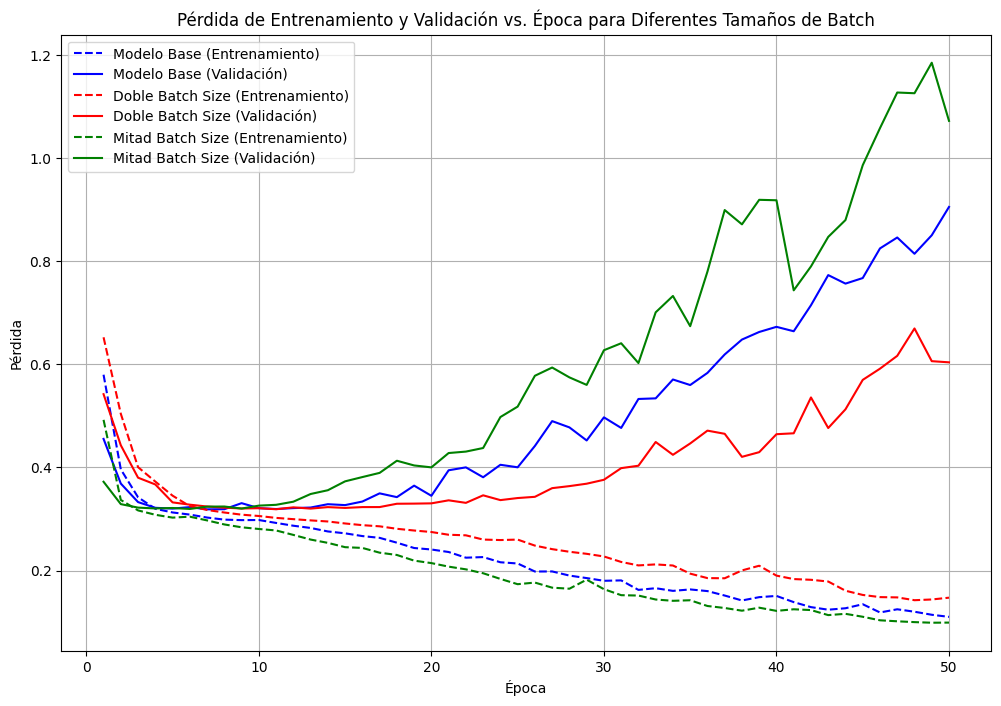

In [ ]:
# Graficar las pérdidas de entrenamiento y validación para los tres modelos del Experimento 3
plt.figure(figsize=(12, 8))
plt.plot(range(1, epochs + 1), train_losses, label='Modelo Base (Entrenamiento)', linestyle='--', color='blue')
plt.plot(range(1, epochs + 1), val_losses, label='Modelo Base (Validación)', color='blue')
plt.plot(range(1, epochs + 1), train_losses_exp3_double_batch, label='Doble Batch Size (Entrenamiento)', linestyle='--', color='red')
plt.plot(range(1, epochs + 1), val_losses_exp3_double_batch, label='Doble Batch Size (Validación)', color='red')
plt.plot(range(1, epochs + 1), train_losses_exp3_half_batch, label='Mitad Batch Size (Entrenamiento)', linestyle='--', color='green')
plt.plot(range(1, epochs + 1), val_losses_exp3_half_batch, label='Mitad Batch Size (Validación)', color='green')

plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación vs. Época para Diferentes Tamaños de Batch')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calcular el mínimo error de entrenamiento para cada modelo del Experimento 3
min_train_loss_base = min(train_losses)
min_train_loss_double_batch = min(train_losses_exp3_double_batch)
min_train_loss_half_batch = min(train_losses_exp3_half_batch)

print(f"Mínimo error de entrenamiento del Modelo Base: {min_train_loss_base:.4f}")
print(f"Mínimo error de entrenamiento del Modelo con Doble Batch Size: {min_train_loss_double_batch:.4f}")
print(f"Mínimo error de entrenamiento del Modelo con Mitad Batch Size: {min_train_loss_half_batch:.4f}")

# Determinar qué modelo tiene el menor mínimo error de entrenamiento en el Experimento 3
if min_train_loss_base <= min_train_loss_double_batch and min_train_loss_base <= min_train_loss_half_batch:
    print("\nEl Modelo Base tiene el menor mínimo error de entrenamiento en el Experimento 3.")
elif min_train_loss_double_batch <= min_train_loss_base and min_train_loss_double_batch <= min_train_loss_half_batch:
    print("\nEl Modelo con Doble Batch Size tiene el menor mínimo error de entrenamiento en el Experimento 3.")
else:
    print("\nEl Modelo con Mitad Batch Size tiene el menor mínimo error de entrenamiento en el Experimento 3.")

Mínimo error de entrenamiento del Modelo Base: 0.1100
Mínimo error de entrenamiento del Modelo con Doble Batch Size: 0.1424
Mínimo error de entrenamiento del Modelo con Mitad Batch Size: 0.0987

El Modelo con Mitad Batch Size tiene el menor mínimo error de entrenamiento en el Experimento 3.


#### Experimento 4
Comparamos el modelo original con uno que tiene el doble del learning rate y otro con la mitad, manteniendo constante la cantidad de capas, neuronas y tamaño de batch.

In [ ]:
# Doble de learning rate

# Hiperparametros para el Experimento 4: Doble de learning rate
input_size = 64
hidden_layers = 6
hidden_neurons = 256
output_size = 1
activation = nn.ReLU
dropout_p = None
use_logits_output = True

learning_rate_exp4_double_lr = 0.002 # Doble de learning rate
batch_size = 1024 # Mantener batch size original
epochs = 50

# Seed
torch.manual_seed(45)
if torch.cuda.is_available():
    torch.cuda.manual_seed(45)

model_exp4_double_lr = MLP(
    input_size=input_size,
    hidden_layers=hidden_layers,
    hidden_neurons=hidden_neurons,
    output_size=output_size,
    activation=activation,
    dropout_p=dropout_p,
    use_logits_output=use_logits_output,
).to(device)

print("Model Experiment 4 (Double Learning Rate) created:")
print(model_exp4_double_lr)

# Definir optimizer for model_exp4_double_lr
optimizer_exp4_double_lr = torch.optim.AdamW(model_exp4_double_lr.parameters(), lr=learning_rate_exp4_double_lr)

Model Experiment 4 (Double Learning Rate) created:
MLP(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=256, bias=True)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [ ]:
# Listas para almacenar las pérdidas y métricas por época para el Experimento 4: Doble de learning rate
train_losses_exp4_double_lr = []
val_losses_exp4_double_lr = []
train_accuracies_exp4_double_lr = []
val_accuracies_exp4_double_lr = []
train_f1_scores_exp4_double_lr = []
val_f1_scores_exp4_double_lr = []

### Loop de entrenamiento para el modelo de Experimento 4: Doble de learning rate

for epoch in range(epochs):
    model_exp4_double_lr.train() # Usar el modelo de experimento 4 con doble de learning rate
    train_loss_exp4_double_lr = 0
    train_correct_exp4_double_lr = 0
    train_total_exp4_double_lr = 0
    train_predictions_exp4_double_lr = []
    train_labels_exp4_double_lr = []

    for batch_x, batch_y in train_loader:
        # Movemos datos al GPU
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        predictions = model_exp4_double_lr(batch_x) # Usar el modelo de experimento 4 con doble de learning rate

        loss = criterion(predictions, batch_y.float().unsqueeze(1)) # .float() y .unsqueeze(1) para compatibilidad

        # Hacemos el backwards propagation para actualizar los parámetros
        optimizer_exp4_double_lr.zero_grad() # Usar el optimizador para model_exp4_double_lr
        loss.backward()
        optimizer_exp4_double_lr.step()

        train_loss_exp4_double_lr += loss.item() * batch_x.size(0)

        # Calcular entrenamiento accuracy y recoger predicciones/labels para F1
        # Asegurarnos de que es 1D antes de convertir a numpy y list
        predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
        train_total_exp4_double_lr += batch_y.size(0)
        train_correct_exp4_double_lr += (predicted_classes == batch_y.view(-1)).sum().item()

        # Convertir a lista antes de extender
        train_predictions_exp4_double_lr.extend(predicted_classes.cpu().numpy().tolist())
        train_labels_exp4_double_lr.extend(batch_y.view(-1).cpu().numpy().tolist())


    train_loss_exp4_double_lr /= len(train_loader.dataset)
    train_accuracy_exp4_double_lr = train_correct_exp4_double_lr / train_total_exp4_double_lr
    train_f1_exp4_double_lr = f1_score(train_labels_exp4_double_lr, train_predictions_exp4_double_lr)

    # Guardamos las metricas
    train_losses_exp4_double_lr.append(train_loss_exp4_double_lr)
    train_accuracies_exp4_double_lr.append(train_accuracy_exp4_double_lr)
    train_f1_scores_exp4_double_lr.append(train_f1_exp4_double_lr)

    model_exp4_double_lr.eval() # Usar el modelo de experimento 4 con doble de learning rate
    val_loss_exp4_double_lr = 0
    val_correct_exp4_double_lr = 0
    val_total_exp4_double_lr = 0
    val_predictions_exp4_double_lr = []
    val_labels_exp4_double_lr = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            # Movemos datos al GPU
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions = model_exp4_double_lr(batch_x) # Usar el modelo de experimento 4 con doble de learning rate
            loss = criterion(predictions, batch_y.float().unsqueeze(1)) # .float() y .unsqueeze(1) para compatibilidad
            val_loss_exp4_double_lr += loss.item() * batch_x.size(0)

            # Calcular validación accuracy y recoger predicciones/labels para F1
            # Asegurarnos de que es 1D antes de convertir a numpy y list
            predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
            val_total_exp4_double_lr += batch_y.size(0)
            val_correct_exp4_double_lr += (predicted_classes == batch_y.view(-1)).sum().item()

            # Convertir a lista antes de extender
            val_predictions_exp4_double_lr.extend(predicted_classes.cpu().numpy().tolist())
            val_labels_exp4_double_lr.extend(batch_y.view(-1).cpu().numpy().tolist())


    val_loss_exp4_double_lr /= len(val_loader.dataset)
    val_accuracy_exp4_double_lr = val_correct_exp4_double_lr / val_total_exp4_double_lr
    val_f1_exp4_double_lr = f1_score(val_labels_exp4_double_lr, val_predictions_exp4_double_lr)

    # Guardamos las metricas
    val_losses_exp4_double_lr.append(val_loss_exp4_double_lr)
    val_accuracies_exp4_double_lr.append(val_accuracy_exp4_double_lr)
    val_f1_scores_exp4_double_lr.append(val_f1_exp4_double_lr)


    print(f"Epoca {epoch+1}: train_loss={train_loss_exp4_double_lr:.4f}, train_accuracy={train_accuracy_exp4_double_lr:.4f}, train_f1={train_f1_exp4_double_lr:.4f}, val_loss={val_loss_exp4_double_lr:.4f}, val_accuracy={val_accuracy_exp4_double_lr:.4f}, val_f1={val_f1_exp4_double_lr:.4f}")

Epoca 1: train_loss=0.5087, train_accuracy=0.7262, train_f1=0.0976, val_loss=0.3863, val_accuracy=0.7589, val_f1=0.0000
Epoca 2: train_loss=0.3612, train_accuracy=0.8058, train_f1=0.4983, val_loss=0.3400, val_accuracy=0.8490, val_f1=0.6594
Epoca 3: train_loss=0.3246, train_accuracy=0.8458, train_f1=0.6159, val_loss=0.3224, val_accuracy=0.8541, val_f1=0.6754
Epoca 4: train_loss=0.3178, train_accuracy=0.8524, train_f1=0.6635, val_loss=0.3222, val_accuracy=0.8555, val_f1=0.6697
Epoca 5: train_loss=0.3096, train_accuracy=0.8554, train_f1=0.6653, val_loss=0.3220, val_accuracy=0.8520, val_f1=0.6872
Epoca 6: train_loss=0.3035, train_accuracy=0.8587, train_f1=0.6799, val_loss=0.3207, val_accuracy=0.8525, val_f1=0.6551
Epoca 7: train_loss=0.2972, train_accuracy=0.8614, train_f1=0.6874, val_loss=0.3203, val_accuracy=0.8531, val_f1=0.6645
Epoca 8: train_loss=0.2932, train_accuracy=0.8647, train_f1=0.6891, val_loss=0.3201, val_accuracy=0.8531, val_f1=0.6632
Epoca 9: train_loss=0.2896, train_accura

In [ ]:
# Mitad de learning rate

# Hiperparametros para el Experimento 4: Mitad de learning rate
input_size = 64
hidden_layers = 6
hidden_neurons = 256
output_size = 1
activation = nn.ReLU
dropout_p = None
use_logits_output = True

learning_rate_exp4_half_lr = 0.0005 # Mitad de learning rate
batch_size = 1024 # Mantener batch size original
epochs = 50

# Seed
torch.manual_seed(45)
if torch.cuda.is_available():
    torch.cuda.manual_seed(45)

model_exp4_half_lr = MLP(
    input_size=input_size,
    hidden_layers=hidden_layers,
    hidden_neurons=hidden_neurons,
    output_size=output_size,
    activation=activation,
    dropout_p=dropout_p,
    use_logits_output=use_logits_output,
).to(device)


# Definir optimizer for model_exp4_half_lr
optimizer_exp4_half_lr = torch.optim.AdamW(model_exp4_half_lr.parameters(), lr=learning_rate_exp4_half_lr)

In [ ]:
# Listas para almacenar las pérdidas y métricas por época para el Experimento 4: Mitad de learning rate
train_losses_exp4_half_lr = []
val_losses_exp4_half_lr = []
train_accuracies_exp4_half_lr = []
val_accuracies_exp4_half_lr = []
train_f1_scores_exp4_half_lr = []
val_f1_scores_exp4_half_lr = []

### Loop de entrenamiento para el modelo de Experimento 4: Mitad de learning rate

for epoch in range(epochs):
    model_exp4_half_lr.train() # Usar el modelo de experimento 4 con mitad de learning rate
    train_loss_exp4_half_lr = 0
    train_correct_exp4_half_lr = 0
    train_total_exp4_half_lr = 0
    train_predictions_exp4_half_lr = []
    train_labels_exp4_half_lr = []

    for batch_x, batch_y in train_loader:
        # Movemos datos al GPU
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        predictions = model_exp4_half_lr(batch_x) # Usar el modelo de experimento 4 con mitad de learning rate

        loss = criterion(predictions, batch_y.float().unsqueeze(1)) # .float() y .unsqueeze(1) para compatibilidad

        # Hacemos el backwards propagation para actualizar los parámetros
        optimizer_exp4_half_lr.zero_grad() # Usar el optimizador para model_exp4_half_lr
        loss.backward()
        optimizer_exp4_half_lr.step()

        train_loss_exp4_half_lr += loss.item() * batch_x.size(0)

        # Calcular entrenamiento accuracy y recoger predicciones/labels para F1
        # Asegurarnos de que es 1D antes de convertir a numpy y list
        predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
        train_total_exp4_half_lr += batch_y.size(0)
        train_correct_exp4_half_lr += (predicted_classes == batch_y.view(-1)).sum().item()

        # Convertir a lista antes de extender
        train_predictions_exp4_half_lr.extend(predicted_classes.cpu().numpy().tolist())
        train_labels_exp4_half_lr.extend(batch_y.view(-1).cpu().numpy().tolist())


    train_loss_exp4_half_lr /= len(train_loader.dataset)
    train_accuracy_exp4_half_lr = train_correct_exp4_half_lr / train_total_exp4_half_lr
    train_f1_exp4_half_lr = f1_score(train_labels_exp4_half_lr, train_predictions_exp4_half_lr)

    # Guardamos las metricas
    train_losses_exp4_half_lr.append(train_loss_exp4_half_lr)
    train_accuracies_exp4_half_lr.append(train_accuracy_exp4_half_lr)
    train_f1_scores_exp4_half_lr.append(train_f1_exp4_half_lr)

    model_exp4_half_lr.eval() # Usar el modelo de experimento 4 con mitad de learning rate
    val_loss_exp4_half_lr = 0
    val_correct_exp4_half_lr = 0
    val_total_exp4_half_lr = 0
    val_predictions_exp4_half_lr = []
    val_labels_exp4_half_lr = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            # Movemos datos al GPU
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions = model_exp4_half_lr(batch_x) # Usar el modelo de experimento 4 con mitad de learning rate
            loss = criterion(predictions, batch_y.float().unsqueeze(1)) # .float() y .unsqueeze(1) para compatibilidad
            val_loss_exp4_half_lr += loss.item() * batch_x.size(0)

            # Calcular validación accuracy y recoger predicciones/labels para F1
            # Asegurarnos de que es 1D antes de convertir a numpy y list
            predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
            val_total_exp4_half_lr += batch_y.size(0)
            val_correct_exp4_half_lr += (predicted_classes == batch_y.view(-1)).sum().item()

            # Convertir a lista antes de extender
            val_predictions_exp4_half_lr.extend(predicted_classes.cpu().numpy().tolist())
            val_labels_exp4_half_lr.extend(batch_y.view(-1).cpu().numpy().tolist())


    val_loss_exp4_half_lr /= len(val_loader.dataset)
    val_accuracy_exp4_half_lr = val_correct_exp4_half_lr / val_total_exp4_half_lr
    val_f1_exp4_half_lr = f1_score(val_labels_exp4_half_lr, val_predictions_exp4_half_lr)

    # Guardamos las metricas
    val_losses_exp4_half_lr.append(val_loss_exp4_half_lr)
    val_accuracies_exp4_half_lr.append(val_accuracy_exp4_half_lr)
    val_f1_scores_exp4_half_lr.append(val_f1_exp4_half_lr)


    print(f"Epoca {epoch+1}: train_loss={train_loss_exp4_half_lr:.4f}, train_accuracy={train_accuracy_exp4_half_lr:.4f}, train_f1={train_f1_exp4_half_lr:.4f}, val_loss={val_loss_exp4_half_lr:.4f}, val_accuracy={val_accuracy_exp4_half_lr:.4f}, val_f1={val_f1_exp4_half_lr:.4f}")

Epoca 1: train_loss=0.6417, train_accuracy=0.6978, train_f1=0.1543, val_loss=0.5283, val_accuracy=0.7589, val_f1=0.0000
Epoca 2: train_loss=0.4649, train_accuracy=0.7595, train_f1=0.0000, val_loss=0.3907, val_accuracy=0.7589, val_f1=0.0000
Epoca 3: train_loss=0.3741, train_accuracy=0.7825, train_f1=0.3028, val_loss=0.3628, val_accuracy=0.8313, val_f1=0.6686
Epoca 4: train_loss=0.3424, train_accuracy=0.8372, train_f1=0.6634, val_loss=0.3296, val_accuracy=0.8484, val_f1=0.6585
Epoca 5: train_loss=0.3236, train_accuracy=0.8479, train_f1=0.6433, val_loss=0.3248, val_accuracy=0.8526, val_f1=0.6791
Epoca 6: train_loss=0.3147, train_accuracy=0.8534, train_f1=0.6681, val_loss=0.3242, val_accuracy=0.8515, val_f1=0.6407
Epoca 7: train_loss=0.3092, train_accuracy=0.8539, train_f1=0.6655, val_loss=0.3205, val_accuracy=0.8544, val_f1=0.6783
Epoca 8: train_loss=0.3060, train_accuracy=0.8562, train_f1=0.6721, val_loss=0.3211, val_accuracy=0.8541, val_f1=0.6644
Epoca 9: train_loss=0.3055, train_accura

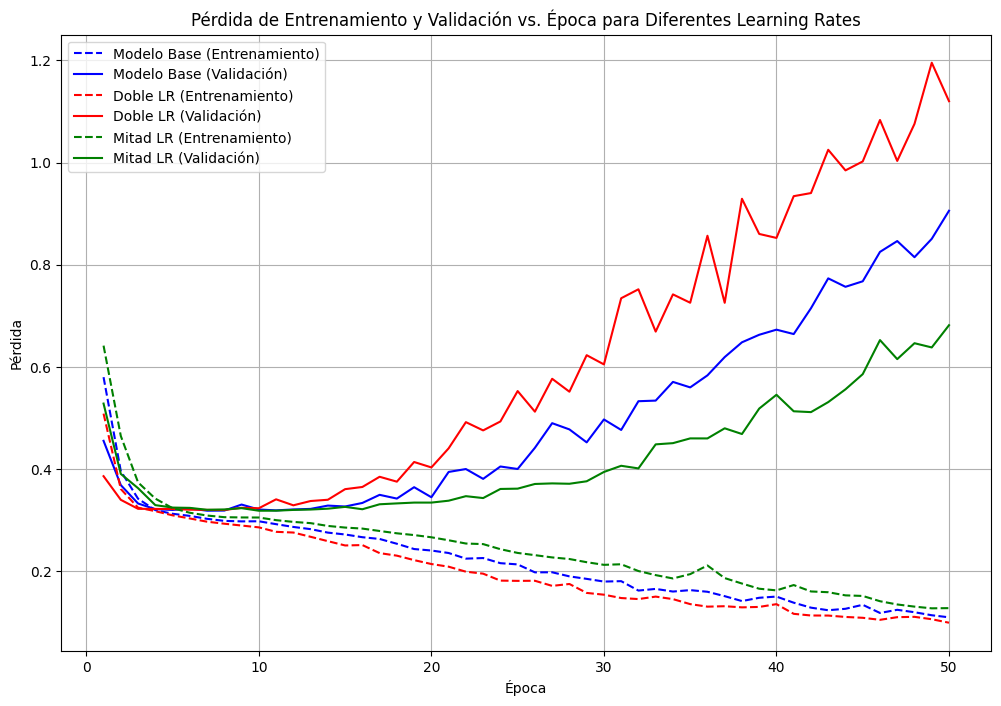

In [ ]:
# Graficar las pérdidas de entrenamiento y validación para los tres modelos del Experimento 4
plt.figure(figsize=(12, 8))
plt.plot(range(1, epochs + 1), train_losses, label='Modelo Base (Entrenamiento)', linestyle='--', color='blue')
plt.plot(range(1, epochs + 1), val_losses, label='Modelo Base (Validación)', color='blue')
plt.plot(range(1, epochs + 1), train_losses_exp4_double_lr, label='Doble LR (Entrenamiento)', linestyle='--', color='red')
plt.plot(range(1, epochs + 1), val_losses_exp4_double_lr, label='Doble LR (Validación)', color='red')
plt.plot(range(1, epochs + 1), train_losses_exp4_half_lr, label='Mitad LR (Entrenamiento)', linestyle='--', color='green')
plt.plot(range(1, epochs + 1), val_losses_exp4_half_lr, label='Mitad LR (Validación)', color='green')

plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación vs. Época para Diferentes Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calcular el mínimo error de entrenamiento para cada modelo del Experimento 4
min_train_loss_base = min(train_losses)
min_train_loss_double_lr = min(train_losses_exp4_double_lr)
min_train_loss_half_lr = min(train_losses_exp4_half_lr)

print(f"Mínimo error de entrenamiento del Modelo Base: {min_train_loss_base:.4f}")
print(f"Mínimo error de entrenamiento del Modelo con Doble LR: {min_train_loss_double_lr:.4f}")
print(f"Mínimo error de entrenamiento del Modelo con Mitad LR: {min_train_loss_half_lr:.4f}")

# Determinar qué modelo tiene el menor mínimo error de entrenamiento en el Experimento 4
if min_train_loss_base <= min_train_loss_double_lr and min_train_loss_base <= min_train_loss_half_lr:
    print("\nEl Modelo Base tiene el menor mínimo error de entrenamiento en el Experimento 4.")
elif min_train_loss_double_lr <= min_train_loss_base and min_train_loss_double_lr <= min_train_loss_half_lr:
    print("\nEl Modelo con Doble LR tiene el menor mínimo error de entrenamiento en el Experimento 4.")
else:
    print("\nEl Modelo con Mitad LR tiene el menor mínimo error de entrenamiento en el Experimento 4.")

Mínimo error de entrenamiento del Modelo Base: 0.1100
Mínimo error de entrenamiento del Modelo con Doble LR: 0.0995
Mínimo error de entrenamiento del Modelo con Mitad LR: 0.1276

El Modelo con Doble LR tiene el menor mínimo error de entrenamiento en el Experimento 4.


#### Experimento 5
Comparamos el modelo original (con ReLU) con dos modelos que utilizan diferentes funciones de activación en las capas ocultas: LeakyReLU y ELU, manteniendo constantes la cantidad de capas, neuronas, tamaño de batch y learning rate.

In [ ]:
import torch.nn as nn

# Modelo con LeakyReLU

# Hiperparametros para el Experimento 5: LeakyReLU
input_size = 64
hidden_layers = 6
hidden_neurons = 256
output_size = 1
activation_exp5_leakyrelu = nn.LeakyReLU # Cambiar la función de activación a LeakyReLU
dropout_p = None
use_logits_output = True

learning_rate = 0.001
batch_size = 1024 # Mantener batch size original
epochs = 50

# Seed
torch.manual_seed(45)
if torch.cuda.is_available():
    torch.cuda.manual_seed(45)

model_exp5_leakyrelu = MLP(
    input_size=input_size,
    hidden_layers=hidden_layers,
    hidden_neurons=hidden_neurons,
    output_size=output_size,
    activation=activation_exp5_leakyrelu,
    dropout_p=dropout_p,
    use_logits_output=use_logits_output,
).to(device)

print("Model Experiment 5 (LeakyReLU) created:")
print(model_exp5_leakyrelu)

# Definir optimizer for model_exp5_leakyrelu
optimizer_exp5_leakyrelu = torch.optim.AdamW(model_exp5_leakyrelu.parameters(), lr=learning_rate)

Model Experiment 5 (LeakyReLU) created:
MLP(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=256, out_features=256, bias=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [ ]:
# Listas para almacenar las pérdidas y métricas por época para el Experimento 5: LeakyReLU
train_losses_exp5_leakyrelu = []
val_losses_exp5_leakyrelu = []
train_accuracies_exp5_leakyrelu = []
val_accuracies_exp5_leakyrelu = []
train_f1_scores_exp5_leakyrelu = []
val_f1_scores_exp5_leakyrelu = []

### Loop de entrenamiento para el modelo de Experimento 5: LeakyReLU

for epoch in range(epochs):
    model_exp5_leakyrelu.train()
    train_loss_exp5_leakyrelu = 0
    train_correct_exp5_leakyrelu = 0
    train_total_exp5_leakyrelu = 0
    train_predictions_exp5_leakyrelu = []
    train_labels_exp5_leakyrelu = []

    for batch_x, batch_y in train_loader:
        # Movemos datos al GPU
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        predictions = model_exp5_leakyrelu(batch_x)

        loss = criterion(predictions, batch_y.float().unsqueeze(1))

        # Hacemos el backwards propagation para actualizar los parámetros
        optimizer_exp5_leakyrelu.zero_grad()
        loss.backward()
        optimizer_exp5_leakyrelu.step()

        train_loss_exp5_leakyrelu += loss.item() * batch_x.size(0)

        # Calcular entrenamiento accuracy y recoger predicciones/labels para F1
        predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
        train_total_exp5_leakyrelu += batch_y.size(0)
        train_correct_exp5_leakyrelu += (predicted_classes == batch_y.view(-1)).sum().item()

        train_predictions_exp5_leakyrelu.extend(predicted_classes.cpu().numpy().tolist())
        train_labels_exp5_leakyrelu.extend(batch_y.view(-1).cpu().numpy().tolist())


    train_loss_exp5_leakyrelu /= len(train_loader.dataset)
    train_accuracy_exp5_leakyrelu = train_correct_exp5_leakyrelu / train_total_exp5_leakyrelu
    train_f1_exp5_leakyrelu = f1_score(train_labels_exp5_leakyrelu, train_predictions_exp5_leakyrelu)

    # Guardamos las metricas
    train_losses_exp5_leakyrelu.append(train_loss_exp5_leakyrelu)
    train_accuracies_exp5_leakyrelu.append(train_accuracy_exp5_leakyrelu)
    train_f1_scores_exp5_leakyrelu.append(train_f1_exp5_leakyrelu)

    model_exp5_leakyrelu.eval()
    val_loss_exp5_leakyrelu = 0
    val_correct_exp5_leakyrelu = 0
    val_total_exp5_leakyrelu = 0
    val_predictions_exp5_leakyrelu = []
    val_labels_exp5_leakyrelu = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            # Movemos datos al GPU
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions = model_exp5_leakyrelu(batch_x)
            loss = criterion(predictions, batch_y.float().unsqueeze(1))
            val_loss_exp5_leakyrelu += loss.item() * batch_x.size(0)

            # Calcular validación accuracy y recoger predicciones/labels para F1
            predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
            val_total_exp5_leakyrelu += batch_y.size(0)
            val_correct_exp5_leakyrelu += (predicted_classes == batch_y.view(-1)).sum().item()

            val_predictions_exp5_leakyrelu.extend(predicted_classes.cpu().numpy().tolist())
            val_labels_exp5_leakyrelu.extend(batch_y.view(-1).cpu().numpy().tolist())


    val_loss_exp5_leakyrelu /= len(val_loader.dataset)
    val_accuracy_exp5_leakyrelu = val_correct_exp5_leakyrelu / val_total_exp5_leakyrelu
    val_f1_exp5_leakyrelu = f1_score(val_labels_exp5_leakyrelu, val_predictions_exp5_leakyrelu)

    # Guardamos las metricas
    val_losses_exp5_leakyrelu.append(val_loss_exp5_leakyrelu)
    val_accuracies_exp5_leakyrelu.append(val_accuracy_exp5_leakyrelu)
    val_f1_scores_exp5_leakyrelu.append(val_f1_exp5_leakyrelu)


    print(f"Epoca {epoch+1}: train_loss={train_loss_exp5_leakyrelu:.4f}, train_accuracy={train_accuracy_exp5_leakyrelu:.4f}, train_f1={train_f1_exp5_leakyrelu:.4f}, val_loss={val_loss_exp5_leakyrelu:.4f}, val_accuracy={val_accuracy_exp5_leakyrelu:.4f}, val_f1={val_f1_exp5_leakyrelu:.4f}")

Epoca 1: train_loss=0.5712, train_accuracy=0.7262, train_f1=0.0976, val_loss=0.4350, val_accuracy=0.7589, val_f1=0.0000
Epoca 2: train_loss=0.3814, train_accuracy=0.7875, train_f1=0.4774, val_loss=0.3431, val_accuracy=0.8416, val_f1=0.6481
Epoca 3: train_loss=0.3290, train_accuracy=0.8434, train_f1=0.6176, val_loss=0.3269, val_accuracy=0.8439, val_f1=0.6058
Epoca 4: train_loss=0.3178, train_accuracy=0.8495, train_f1=0.6453, val_loss=0.3233, val_accuracy=0.8530, val_f1=0.6545
Epoca 5: train_loss=0.3107, train_accuracy=0.8543, train_f1=0.6578, val_loss=0.3229, val_accuracy=0.8536, val_f1=0.6834
Epoca 6: train_loss=0.3098, train_accuracy=0.8541, train_f1=0.6626, val_loss=0.3258, val_accuracy=0.8471, val_f1=0.6089
Epoca 7: train_loss=0.3032, train_accuracy=0.8569, train_f1=0.6687, val_loss=0.3184, val_accuracy=0.8549, val_f1=0.6702
Epoca 8: train_loss=0.2984, train_accuracy=0.8588, train_f1=0.6741, val_loss=0.3204, val_accuracy=0.8520, val_f1=0.6504
Epoca 9: train_loss=0.2975, train_accura

In [ ]:
# Modelo con ELU

# Hiperparametros para el Experimento 5: ELU
input_size = 64
hidden_layers = 6
hidden_neurons = 256
output_size = 1
activation_exp5_elu = nn.ELU # Cambiar la función de activación a ELU
dropout_p = None
use_logits_output = True

learning_rate = 0.001
batch_size = 1024 # Mantener batch size original
epochs = 50

# Seed
torch.manual_seed(45)
if torch.cuda.is_available():
    torch.cuda.manual_seed(45)

model_exp5_elu = MLP(
    input_size=input_size,
    hidden_layers=hidden_layers,
    hidden_neurons=hidden_neurons,
    output_size=output_size,
    activation=activation_exp5_elu,
    dropout_p=dropout_p,
    use_logits_output=use_logits_output,
).to(device)

# Definir optimizer for model_exp5_elu
optimizer_exp5_elu = torch.optim.AdamW(model_exp5_elu.parameters(), lr=learning_rate)

In [ ]:
# Listas para almacenar las pérdidas y métricas por época para el Experimento 5: ELU
train_losses_exp5_elu = []
val_losses_exp5_elu = []
train_accuracies_exp5_elu = []
val_accuracies_exp5_elu = []
train_f1_scores_exp5_elu = []
val_f1_scores_exp5_elu = []

### Loop de entrenamiento para el modelo de Experimento 5: ELU

for epoch in range(epochs):
    model_exp5_elu.train()
    train_loss_exp5_elu = 0
    train_correct_exp5_elu = 0
    train_total_exp5_elu = 0
    train_predictions_exp5_elu = []
    train_labels_exp5_elu = []

    for batch_x, batch_y in train_loader:
        # Movemos datos al GPU
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        predictions = model_exp5_elu(batch_x)

        loss = criterion(predictions, batch_y.float().unsqueeze(1))

        # Hacemos el backwards propagation para actualizar los parámetros
        optimizer_exp5_elu.zero_grad()
        loss.backward()
        optimizer_exp5_elu.step()

        train_loss_exp5_elu += loss.item() * batch_x.size(0)

        # Calcular entrenamiento accuracy y recoger predicciones/labels para F1
        predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
        train_total_exp5_elu += batch_y.size(0)
        train_correct_exp5_elu += (predicted_classes == batch_y.view(-1)).sum().item()

        train_predictions_exp5_elu.extend(predicted_classes.cpu().numpy().tolist())
        train_labels_exp5_elu.extend(batch_y.view(-1).cpu().numpy().tolist())


    train_loss_exp5_elu /= len(train_loader.dataset)
    train_accuracy_exp5_elu = train_correct_exp5_elu / train_total_exp5_elu
    train_f1_exp5_elu = f1_score(train_labels_exp5_elu, train_predictions_exp5_elu)

    # Guardamos las metricas
    train_losses_exp5_elu.append(train_loss_exp5_elu)
    train_accuracies_exp5_elu.append(train_accuracy_exp5_elu)
    train_f1_scores_exp5_elu.append(train_f1_exp5_elu)


    model_exp5_elu.eval()
    val_loss_exp5_elu = 0
    val_correct_exp5_elu = 0
    val_total_exp5_elu = 0
    val_predictions_exp5_elu = []
    val_labels_exp5_elu = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            # Movemos datos al GPU
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions = model_exp5_elu(batch_x)
            loss = criterion(predictions, batch_y.float().unsqueeze(1))
            val_loss_exp5_elu += loss.item() * batch_x.size(0)

            # Calcular validación accuracy y recoger predicciones/labels para F1
            predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
            val_total_exp5_elu += batch_y.size(0)
            val_correct_exp5_elu += (predicted_classes == batch_y.view(-1)).sum().item()

            val_predictions_exp5_elu.extend(predicted_classes.cpu().numpy().tolist())
            val_labels_exp5_elu.extend(batch_y.view(-1).cpu().numpy().tolist())


    val_loss_exp5_elu /= len(val_loader.dataset)
    val_accuracy_exp5_elu = val_correct_exp5_elu / val_total_exp5_elu
    val_f1_exp5_elu = f1_score(val_labels_exp5_elu, val_predictions_exp5_elu)

    # Guardamos las metricas
    val_losses_exp5_elu.append(val_loss_exp5_elu)
    val_accuracies_exp5_elu.append(val_accuracy_exp5_elu)
    val_f1_scores_exp5_elu.append(val_f1_exp5_elu)


    print(f"Epoca {epoch+1}: train_loss={train_loss_exp5_elu:.4f}, train_accuracy={train_accuracy_exp5_elu:.4f}, train_f1={train_f1_exp5_elu:.4f}, val_loss={val_loss_exp5_elu:.4f}, val_accuracy={val_accuracy_exp5_elu:.4f}, val_f1={val_f1_exp5_elu:.4f}")

Epoca 1: train_loss=0.4545, train_accuracy=0.7661, train_f1=0.4480, val_loss=0.3518, val_accuracy=0.8358, val_f1=0.5865
Epoca 2: train_loss=0.3379, train_accuracy=0.8440, train_f1=0.6524, val_loss=0.3384, val_accuracy=0.8455, val_f1=0.6689
Epoca 3: train_loss=0.3334, train_accuracy=0.8446, train_f1=0.6608, val_loss=0.3322, val_accuracy=0.8464, val_f1=0.6703
Epoca 4: train_loss=0.3266, train_accuracy=0.8461, train_f1=0.6602, val_loss=0.3304, val_accuracy=0.8491, val_f1=0.6554
Epoca 5: train_loss=0.3264, train_accuracy=0.8460, train_f1=0.6585, val_loss=0.3321, val_accuracy=0.8454, val_f1=0.6735
Epoca 6: train_loss=0.3257, train_accuracy=0.8464, train_f1=0.6590, val_loss=0.3316, val_accuracy=0.8455, val_f1=0.6262
Epoca 7: train_loss=0.3236, train_accuracy=0.8493, train_f1=0.6640, val_loss=0.3275, val_accuracy=0.8482, val_f1=0.6579
Epoca 8: train_loss=0.3218, train_accuracy=0.8500, train_f1=0.6578, val_loss=0.3260, val_accuracy=0.8491, val_f1=0.6509
Epoca 9: train_loss=0.3210, train_accura

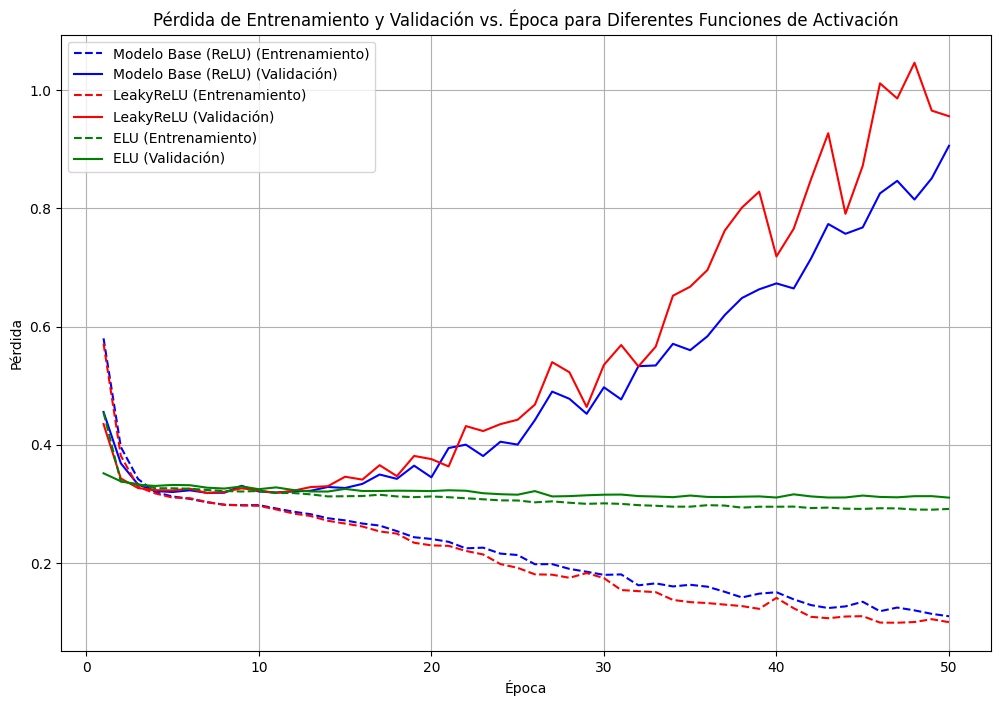

In [ ]:
# Graficar las pérdidas de entrenamiento y validación para los tres modelos del Experimento 5
plt.figure(figsize=(12, 8))
plt.plot(range(1, epochs + 1), train_losses, label='Modelo Base (ReLU) (Entrenamiento)', linestyle='--', color='blue')
plt.plot(range(1, epochs + 1), val_losses, label='Modelo Base (ReLU) (Validación)', color='blue')
plt.plot(range(1, epochs + 1), train_losses_exp5_leakyrelu, label='LeakyReLU (Entrenamiento)', linestyle='--', color='red')
plt.plot(range(1, epochs + 1), val_losses_exp5_leakyrelu, label='LeakyReLU (Validación)', color='red')
plt.plot(range(1, epochs + 1), train_losses_exp5_elu, label='ELU (Entrenamiento)', linestyle='--', color='green')
plt.plot(range(1, epochs + 1), val_losses_exp5_elu, label='ELU (Validación)', color='green')

plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación vs. Época para Diferentes Funciones de Activación')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calcular el mínimo error de entrenamiento para cada modelo del Experimento 5
min_train_loss_base = min(train_losses)
min_train_loss_leakyrelu = min(train_losses_exp5_leakyrelu)
min_train_loss_elu = min(train_losses_exp5_elu)


print(f"Mínimo error de entrenamiento del Modelo Base (ReLU): {min_train_loss_base:.4f}")
print(f"Mínimo error de entrenamiento del Modelo con LeakyReLU: {min_train_loss_leakyrelu:.4f}")
print(f"Mínimo error de entrenamiento del Modelo con ELU: {min_train_loss_elu:.4f}")


# Determinar qué modelo tiene el menor mínimo error de entrenamiento en el Experimento 5
if min_train_loss_base <= min_train_loss_leakyrelu and min_train_loss_base <= min_train_loss_elu:
    print("\nEl Modelo Base (ReLU) tiene el menor mínimo error de entrenamiento en el Experimento 5.")
elif min_train_loss_leakyrelu <= min_train_loss_base and min_train_loss_leakyrelu <= min_train_loss_elu:
    print("\nEl Modelo con LeakyReLU tiene el menor mínimo error de entrenamiento en el Experimento 5.")
else:
    print("\nEl Modelo con ELU tiene el menor mínimo error de entrenamiento en el Experimento 5.")

Mínimo error de entrenamiento del Modelo Base (ReLU): 0.1100
Mínimo error de entrenamiento del Modelo con LeakyReLU: 0.0991
Mínimo error de entrenamiento del Modelo con ELU: 0.2903

El Modelo con LeakyReLU tiene el menor mínimo error de entrenamiento en el Experimento 5.


# 2.2.5 Implementación de técnicas de regularización: Dropout y EarlyStopping

En esta sección se implementan dos técnicas de regularización con el objetivo de mejorar la capacidad de generalización del modelo y reducir el sobreajuste. Dropout se incorpora dentro de la arquitectura del MLP, desactivando aleatoriamente neuronas durante el entrenamiento. EarlyStopping se aplica en el ciclo de entrenamiento para detenerlo automáticamente cuando la pérdida de validación deja de mejorar.

In [ ]:
# Arquitectura de MLP con Dropout

# Usamos la misma clase MLP definida anteriormente, pero con dropout_p > 0
# Hiperparametros para el modelo regularizado
input_size = 64
hidden_layers = 6
hidden_neurons = 256
output_size = 1
activation = nn.ReLU
dropout_p_regularized = 0.5 # Añadimos dropout con una probabilidad de 0.5
use_logits_output = True

learning_rate = 0.001
batch_size = 1024
epochs = 100 # Aumentamos las épocas ya que Early Stopping lo detendrá

# Seed
torch.manual_seed(45)
if torch.cuda.is_available():
    torch.cuda.manual_seed(45)

model_regularized = MLP(
    input_size=input_size,
    hidden_layers=hidden_layers,
    hidden_neurons=hidden_neurons,
    output_size=output_size,
    activation=activation,
    dropout_p=dropout_p_regularized,
    use_logits_output=use_logits_output,
).to(device)


# Definir funcion de pérdida y optimizador para el modelo regularizado
criterion_regularized = nn.BCEWithLogitsLoss()
optimizer_regularized = torch.optim.AdamW(model_regularized.parameters(), lr=learning_rate)

In [ ]:
# Implementación de Early Stopping
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0): # Aumentamos la paciencia a 10
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model state ...')
        self.val_loss_min = val_loss
        self.best_model_state = model.state_dict()

    def load_best_model(self, model):
      if self.best_model_state is not None:
        model.load_state_dict(self.best_model_state)
        if self.verbose:
            print("Loaded best model state.")
      else:
          if self.verbose:
              print("No best model state saved.")


early_stopping_regularized = EarlyStopping(patience=10, verbose=True) # Usamos una nueva instancia

# Listas para almacenar las pérdidas y métricas por época para el modelo regularizado
train_losses_regularized = []
val_losses_regularized = []
train_accuracies_regularized = []
val_accuracies_regularized = []
train_f1_scores_regularized = []
val_f1_scores_regularized = []

### Loop de entrenamiento para el modelo regularizado

for epoch in range(epochs):
    model_regularized.train()
    train_loss_regularized = 0
    train_correct_regularized = 0
    train_total_regularized = 0
    train_predictions_regularized = []
    train_labels_regularized = []

    for batch_x, batch_y in train_loader:
        # Movemos datos al GPU
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        predictions = model_regularized(batch_x)

        loss = criterion_regularized(predictions, batch_y.float().unsqueeze(1))

        # Hacemos el backwards propagation para actualizar los parámetros
        optimizer_regularized.zero_grad()
        loss.backward()
        optimizer_regularized.step()

        train_loss_regularized += loss.item() * batch_x.size(0)

        # Calcular entrenamiento accuracy y recoger predicciones/labels para F1
        predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
        train_total_regularized += batch_y.size(0)
        train_correct_regularized += (predicted_classes == batch_y.view(-1)).sum().item()

        train_predictions_regularized.extend(predicted_classes.cpu().numpy().tolist())
        train_labels_regularized.extend(batch_y.view(-1).cpu().numpy().tolist())


    train_loss_regularized /= len(train_loader.dataset)
    train_accuracy_regularized = train_correct_regularized / train_total_regularized
    train_f1_regularized = f1_score(train_labels_regularized, train_predictions_regularized)

    # Guardamos las metricas
    train_losses_regularized.append(train_loss_regularized)
    train_accuracies_regularized.append(train_accuracy_regularized)
    train_f1_scores_regularized.append(train_f1_regularized)


    model_regularized.eval()
    val_loss_regularized = 0
    val_correct_regularized = 0
    val_total_regularized = 0
    val_predictions_regularized = []
    val_labels_regularized = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            # Movemos datos al GPU
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions = model_regularized(batch_x)
            loss = criterion_regularized(predictions, batch_y.float().unsqueeze(1))
            val_loss_regularized += loss.item() * batch_x.size(0)

            # Calcular validación accuracy y recoger predicciones/labels para F1
            predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
            val_total_regularized += batch_y.size(0)
            val_correct_regularized += (predicted_classes == batch_y.view(-1)).sum().item()

            val_predictions_regularized.extend(predicted_classes.cpu().numpy().tolist())
            val_labels_regularized.extend(batch_y.view(-1).cpu().numpy().tolist())


    val_loss_regularized /= len(val_loader.dataset)
    val_accuracy_regularized = val_correct_regularized / val_total_regularized
    val_f1_regularized = f1_score(val_labels_regularized, val_predictions_regularized)

    # Guardamos las metricas
    val_losses_regularized.append(val_loss_regularized)
    val_accuracies_regularized.append(val_accuracy_regularized)
    val_f1_scores_regularized.append(val_f1_regularized)


    print(f"Epoca {epoch+1}: train_loss={train_loss_regularized:.4f}, train_accuracy={train_accuracy_regularized:.4f}, train_f1={train_f1_regularized:.4f}, val_loss={val_loss_regularized:.4f}, val_accuracy={val_accuracy_regularized:.4f}, val_f1={val_f1_regularized:.4f}")

    # Early stopping check
    early_stopping_regularized(val_loss_regularized, model_regularized)
    if early_stopping_regularized.early_stop:
        print("Early stopping")
        break

# Cargar el mejor modelo guardado por Early Stopping
early_stopping_regularized.load_best_model(model_regularized)

Epoca 1: train_loss=0.5714, train_accuracy=0.7236, train_f1=0.0902, val_loss=0.4566, val_accuracy=0.7589, val_f1=0.0000
Validation loss decreased (inf --> 0.456596).  Saving model state ...
Epoca 2: train_loss=0.4098, train_accuracy=0.7595, train_f1=0.0000, val_loss=0.3819, val_accuracy=0.7589, val_f1=0.0000
Validation loss decreased (0.456596 --> 0.381928).  Saving model state ...
Epoca 3: train_loss=0.3780, train_accuracy=0.7595, train_f1=0.0000, val_loss=0.3657, val_accuracy=0.7589, val_f1=0.0000
Validation loss decreased (0.381928 --> 0.365687).  Saving model state ...
Epoca 4: train_loss=0.3703, train_accuracy=0.7745, train_f1=0.1738, val_loss=0.3604, val_accuracy=0.8458, val_f1=0.6500
Validation loss decreased (0.365687 --> 0.360443).  Saving model state ...
Epoca 5: train_loss=0.3642, train_accuracy=0.8392, train_f1=0.6223, val_loss=0.3661, val_accuracy=0.8416, val_f1=0.6834
EarlyStopping counter: 1 out of 10
Epoca 6: train_loss=0.3603, train_accuracy=0.8409, train_f1=0.6553, va

# 2.2.6 Mejor MLP con regularización

Se retoma el modelo base optimizado con Dropout y EarlyStopping, y se entrena utilizando los conjuntos de entrenamiento y validación. Esta versión regularizada del MLP busca mejorar la estabilidad del aprendizaje y evitar el sobreentrenamiento, conservando los mejores pesos obtenidos durante el proceso

#### Experimento 1 (con Regularización)

Repetimos el Experimento 1, comparando el modelo base regularizado (con Dropout y Early Stopping) con versiones que tienen el doble y la mitad de neuronas por capa, manteniendo el resto de hiperparámetros constantes.

In [ ]:
# Doble de neuronas (con Regularización)

# Hiperparametros para el Experimento 1 con Regularización: Doble de neuronas
input_size = 64
hidden_layers = 6
hidden_neurons_exp1_reg_double = 512 # Doble de neuronas
output_size = 1
activation = nn.ReLU
dropout_p = 0.5 # Usamos el dropout del modelo base regularizado
use_logits_output = True

learning_rate = 0.001
batch_size = 1024 # Mantener batch size original
epochs = 100 # Aumentamos las épocas ya que Early Stopping lo detendrá

# Seed
torch.manual_seed(45)
if torch.cuda.is_available():
    torch.cuda.manual_seed(45)

model_exp1_reg_double_neurons = MLP(
    input_size=input_size,
    hidden_layers=hidden_layers,
    hidden_neurons=hidden_neurons_exp1_reg_double,
    output_size=output_size,
    activation=activation,
    dropout_p=dropout_p,
    use_logits_output=use_logits_output,
).to(device)

print("Model Experiment 1 (Regularized, Double Neurons) created:")
print(model_exp1_reg_double_neurons)

# Definir funcion de pérdida y optimizador para el modelo regularizado con doble de neuronas
criterion_exp1_reg_double_neurons = nn.BCEWithLogitsLoss()
optimizer_exp1_reg_double_neurons = torch.optim.AdamW(model_exp1_reg_double_neurons.parameters(), lr=learning_rate)

# Early Stopping para el modelo regularizado con doble de neuronas
early_stopping_exp1_reg_double_neurons = EarlyStopping(patience=10, verbose=True)

# Listas para almacenar las pérdidas y métricas por época
train_losses_exp1_reg_double_neurons = []
val_losses_exp1_reg_double_neurons = []
train_accuracies_exp1_reg_double_neurons = []
val_accuracies_exp1_reg_double_neurons = []
train_f1_scores_exp1_reg_double_neurons = []
val_f1_scores_exp1_reg_double_neurons = []

### Loop de entrenamiento

for epoch in range(epochs):
    model_exp1_reg_double_neurons.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    train_predictions = []
    train_labels = []

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        predictions = model_exp1_reg_double_neurons(batch_x)
        loss = criterion_exp1_reg_double_neurons(predictions, batch_y.float().unsqueeze(1))

        optimizer_exp1_reg_double_neurons.zero_grad()
        loss.backward()
        optimizer_exp1_reg_double_neurons.step()

        train_loss += loss.item() * batch_x.size(0)
        predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
        train_total += batch_y.size(0)
        train_correct += (predicted_classes == batch_y.view(-1)).sum().item()
        train_predictions.extend(predicted_classes.cpu().numpy().tolist())
        train_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct / train_total
    train_f1 = f1_score(train_labels, train_predictions)

    train_losses_exp1_reg_double_neurons.append(train_loss)
    train_accuracies_exp1_reg_double_neurons.append(train_accuracy)
    train_f1_scores_exp1_reg_double_neurons.append(train_f1)

    model_exp1_reg_double_neurons.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions = model_exp1_reg_double_neurons(batch_x)
            loss = criterion_exp1_reg_double_neurons(predictions, batch_y.float().unsqueeze(1))
            val_loss += loss.item() * batch_x.size(0)
            predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
            val_total += batch_y.size(0)
            val_correct += (predicted_classes == batch_y.view(-1)).sum().item()
            val_predictions.extend(predicted_classes.cpu().numpy().tolist())
            val_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    val_loss /= len(val_loader.dataset)
    val_accuracy = val_correct / val_total
    val_f1 = f1_score(val_labels, val_predictions)

    val_losses_exp1_reg_double_neurons.append(val_loss)
    val_accuracies_exp1_reg_double_neurons.append(val_accuracy)
    val_f1_scores_exp1_reg_double_neurons.append(val_f1)

    print(f"Epoca {epoch+1}: train_loss={train_loss:.4f}, train_accuracy={train_accuracy:.4f}, train_f1={train_f1:.4f}, val_loss={val_loss:.4f}, val_accuracy={val_accuracy:.4f}, val_f1={val_f1:.4f}")

    early_stopping_exp1_reg_double_neurons(val_loss, model_exp1_reg_double_neurons)
    if early_stopping_exp1_reg_double_neurons.early_stop:
        print("Early stopping")
        break

early_stopping_exp1_reg_double_neurons.load_best_model(model_exp1_reg_double_neurons)

Model Experiment 1 (Regularized, Double Neurons) created:
MLP(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=512, out_features=512, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=512, out_features=512, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=512, out_features=512, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.5, inplace=False)
    (18): Linear(in_features=512, out_features=1, bias=True)
  )
)
Epoca 1: train_loss=0.4989, train_accuracy=0.7593, train_f1=0.0000, val_loss=0.4014, val_accuracy=0.7589, val_f1=0.0000
Validation loss de

In [ ]:
# Mitad de neuronas (con Regularización)

# Hiperparametros para el Experimento 1 con Regularización: Mitad de neuronas
input_size = 64
hidden_layers = 6
hidden_neurons_exp1_reg_half = 128 # Mitad de neuronas
output_size = 1
activation = nn.ReLU
dropout_p = 0.5 # Usamos el dropout del modelo base regularizado
use_logits_output = True

learning_rate = 0.001
batch_size = 1024 # Mantener batch size original
epochs = 100 # Aumentamos las épocas ya que Early Stopping lo detendrá

# Seed
torch.manual_seed(45)
if torch.cuda.is_available():
    torch.cuda.manual_seed(45)

model_exp1_reg_half_neurons = MLP(
    input_size=input_size,
    hidden_layers=hidden_layers,
    hidden_neurons=hidden_neurons_exp1_reg_half,
    output_size=output_size,
    activation=activation,
    dropout_p=dropout_p,
    use_logits_output=use_logits_output,
).to(device)

print("Model Experiment 1 (Regularized, Half Neurons) created:")
print(model_exp1_reg_half_neurons)

# Definir funcion de pérdida y optimizador para el modelo regularizado con mitad de neuronas
criterion_exp1_reg_half_neurons = nn.BCEWithLogitsLoss()
optimizer_exp1_reg_half_neurons = torch.optim.AdamW(model_exp1_reg_half_neurons.parameters(), lr=learning_rate)

# Early Stopping para el modelo regularizado con mitad de neuronas
early_stopping_exp1_reg_half_neurons = EarlyStopping(patience=10, verbose=True)

# Listas para almacenar las pérdidas y métricas por época
train_losses_exp1_reg_half_neurons = []
val_losses_exp1_reg_half_neurons = []
train_accuracies_exp1_reg_half_neurons = []
val_accuracies_exp1_reg_half_neurons = []
train_f1_scores_exp1_reg_half_neurons = []
val_f1_scores_exp1_reg_half_neurons = []

### Loop de entrenamiento

for epoch in range(epochs):
    model_exp1_reg_half_neurons.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    train_predictions = []
    train_labels = []

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        predictions = model_exp1_reg_half_neurons(batch_x)
        loss = criterion_exp1_reg_half_neurons(predictions, batch_y.float().unsqueeze(1))

        optimizer_exp1_reg_half_neurons.zero_grad()
        loss.backward()
        optimizer_exp1_reg_half_neurons.step()

        train_loss += loss.item() * batch_x.size(0)
        predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
        train_total += batch_y.size(0)
        train_correct += (predicted_classes == batch_y.view(-1)).sum().item()
        train_predictions.extend(predicted_classes.cpu().numpy().tolist())
        train_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct / train_total
    train_f1 = f1_score(train_labels, train_predictions)

    train_losses_exp1_reg_half_neurons.append(train_loss)
    train_accuracies_exp1_reg_half_neurons.append(train_accuracy)
    train_f1_scores_exp1_reg_half_neurons.append(train_f1)

    model_exp1_reg_half_neurons.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions = model_exp1_reg_half_neurons(batch_x)
            loss = criterion_exp1_reg_half_neurons(predictions, batch_y.float().unsqueeze(1))
            val_loss += loss.item() * batch_x.size(0)
            predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
            val_total += batch_y.size(0)
            val_correct += (predicted_classes == batch_y.view(-1)).sum().item()
            val_predictions.extend(predicted_classes.cpu().numpy().tolist())
            val_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    val_loss /= len(val_loader.dataset)
    val_accuracy = val_correct / val_total
    val_f1 = f1_score(val_labels, val_predictions)

    val_losses_exp1_reg_half_neurons.append(val_loss)
    val_accuracies_exp1_reg_half_neurons.append(val_accuracy)
    val_f1_scores_exp1_reg_half_neurons.append(val_f1)

    print(f"Epoca {epoch+1}: train_loss={train_loss:.4f}, train_accuracy={train_accuracy:.4f}, train_f1={train_f1:.4f}, val_loss={val_loss:.4f}, val_accuracy={val_accuracy:.4f}, val_f1={val_f1:.4f}")

    early_stopping_exp1_reg_half_neurons(val_loss, model_exp1_reg_half_neurons)
    if early_stopping_exp1_reg_half_neurons.early_stop:
        print("Early stopping")
        break

early_stopping_exp1_reg_half_neurons.load_best_model(model_exp1_reg_half_neurons)

Model Experiment 1 (Regularized, Half Neurons) created:
MLP(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=128, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=128, out_features=128, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.5, inplace=False)
    (18): Linear(in_features=128, out_features=1, bias=True)
  )
)
Epoca 1: train_loss=0.6169, train_accuracy=0.6877, train_f1=0.1821, val_loss=0.4923, val_accuracy=0.7589, val_f1=0.0000
Validation loss decr

In [ ]:
# Calcular las métricas finales para cada modelo (mejor estado según Early Stopping)

# Modelo Base Regularizado (ya entrenado en celdas anteriores)
model_regularized.eval()
with torch.no_grad():
    logits_base_reg_tensor = model_regularized(torch.Tensor(X_val_processed.values).to(device)).squeeze()
    val_loss_base_reg = criterion_regularized(logits_base_reg_tensor, torch.Tensor(y_val_processed.values).squeeze().float().to(device)).item()
    y_pred_val_base_reg = (torch.sigmoid(logits_base_reg_tensor).cpu().numpy() > 0.5).astype("int32")
    val_f1_base_reg = f1_score(y_val_processed, y_pred_val_base_reg)


# Modelo Doble Neuronas Regularizado
model_exp1_reg_double_neurons.eval()
with torch.no_grad():
    logits_double_reg_tensor = model_exp1_reg_double_neurons(torch.Tensor(X_val_processed.values).to(device)).squeeze()
    val_loss_double_reg = criterion_exp1_reg_double_neurons(logits_double_reg_tensor, torch.Tensor(y_val_processed.values).squeeze().float().to(device)).item()
    y_pred_val_double_reg = (torch.sigmoid(logits_double_reg_tensor).cpu().numpy() > 0.5).astype("int32")
    val_f1_double_reg = f1_score(y_val_processed, y_pred_val_double_reg)


# Modelo Mitad Neuronas Regularizado
model_exp1_reg_half_neurons.eval()
with torch.no_grad():
    logits_half_reg_tensor = model_exp1_reg_half_neurons(torch.Tensor(X_val_processed.values).to(device)).squeeze()
    val_loss_half_reg = criterion_exp1_reg_half_neurons(logits_half_reg_tensor, torch.Tensor(y_val_processed.values).squeeze().float().to(device)).item()
    y_pred_val_half_reg = (torch.sigmoid(logits_half_reg_tensor).cpu().numpy() > 0.5).astype("int32")
    val_f1_half_reg = f1_score(y_val_processed, y_pred_val_half_reg)

# Almacenar las métricas en diccionarios para facilitar la graficación
validation_metrics = {
    'Modelo': ['Base Regularizado', 'Doble Neuronas Regularizado', 'Mitad Neuronas Regularizado'],
    'Pérdida de Validación': [val_loss_base_reg, val_loss_double_reg, val_loss_half_reg],
    'F1 Score de Validación': [val_f1_base_reg, val_f1_double_reg, val_f1_half_reg]
}

metrics_df = pd.DataFrame(validation_metrics)
print("Métricas de Validación para los modelos del Experimento 1 con Regularización:")
display(metrics_df)

Métricas de Validación para los modelos del Experimento 1 con Regularización:


,Modelo,Pérdida de Validación,F1 Score de Validación
0,Base Regularizado,0.322235,0.692590
1,Doble Neuronas Regularizado,0.326915,0.673641
2,Mitad Neuronas Regularizado,0.320055,0.673922


### Experimento 2 (con regularización)

Ahora experimentamos cambiando la cantidad de capas. Comparamos el modelo base regularizado con un modelo idéntico en todo, pero con el doble de capas y otro idéntico en todo, pero con la mitad de capas.

In [ ]:
# Doble de capas (con Regularización)

# Hiperparametros para el Experimento 2 con Regularización: Doble de capas
input_size = 64
hidden_layers = 12 # Doble de capas
hidden_neurons = 256 # Mantener neuronas originales
output_size = 1
activation = nn.ReLU
dropout_p = 0.5 # Usamos el dropout del modelo base regularizado
use_logits_output = True

learning_rate = 0.001
batch_size = 1024 # Mantener batch size original
epochs = 100 # Aumentamos las épocas ya que Early Stopping lo detendrá

# Seed
torch.manual_seed(45)
if torch.cuda.is_available():
    torch.cuda.manual_seed(45)

model_exp2_reg_double_layers = MLP(
    input_size=input_size,
    hidden_layers=hidden_layers,
    hidden_neurons=hidden_neurons,
    output_size=output_size,
    activation=activation,
    dropout_p=dropout_p,
    use_logits_output=use_logits_output,
).to(device)


# Definir funcion de pérdida y optimizador para el modelo regularizado con doble de capas
criterion_exp2_reg_double_layers = nn.BCEWithLogitsLoss()
optimizer_exp2_reg_double_layers = torch.optim.AdamW(model_exp2_reg_double_layers.parameters(), lr=learning_rate)

# Early Stopping para el modelo regularizado con doble de capas
early_stopping_exp2_reg_double_layers = EarlyStopping(patience=10, verbose=True)

# Listas para almacenar las pérdidas y métricas por época
train_losses_exp2_reg_double_layers = []
val_losses_exp2_reg_double_layers = []
train_accuracies_exp2_reg_double_layers = []
val_accuracies_exp2_reg_double_layers = []
train_f1_scores_exp2_reg_double_layers = []
val_f1_scores_exp2_reg_double_layers = []

### Loop de entrenamiento

for epoch in range(epochs):
    model_exp2_reg_double_layers.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    train_predictions = []
    train_labels = []

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        predictions = model_exp2_reg_double_layers(batch_x)
        loss = criterion_exp2_reg_double_layers(predictions, batch_y.float().unsqueeze(1))

        optimizer_exp2_reg_double_layers.zero_grad()
        loss.backward()
        optimizer_exp2_reg_double_layers.step()

        train_loss += loss.item() * batch_x.size(0)
        predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
        train_total += batch_y.size(0)
        train_correct += (predicted_classes == batch_y.view(-1)).sum().item()
        train_predictions.extend(predicted_classes.cpu().numpy().tolist())
        train_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct / train_total
    train_f1 = f1_score(train_labels, train_predictions)

    train_losses_exp2_reg_double_layers.append(train_loss)
    train_accuracies_exp2_reg_double_layers.append(train_accuracy)
    train_f1_scores_exp2_reg_double_layers.append(train_f1)

    model_exp2_reg_double_layers.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions = model_exp2_reg_double_layers(batch_x)
            loss = criterion_exp2_reg_double_layers(predictions, batch_y.float().unsqueeze(1))
            val_loss += loss.item() * batch_x.size(0)
            predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
            val_total += batch_y.size(0)
            val_correct += (predicted_classes == batch_y.view(-1)).sum().item()
            val_predictions.extend(predicted_classes.cpu().numpy().tolist())
            val_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    val_loss /= len(val_loader.dataset)
    val_accuracy = val_correct / val_total
    val_f1 = f1_score(val_labels, val_predictions)

    val_losses_exp2_reg_double_layers.append(val_loss)
    val_accuracies_exp2_reg_double_layers.append(val_accuracy)
    val_f1_scores_exp2_reg_double_layers.append(val_f1)

    print(f"Epoca {epoch+1}: train_loss={train_loss:.4f}, train_accuracy={train_accuracy:.4f}, train_f1={train_f1:.4f}, val_loss={val_loss:.4f}, val_accuracy={val_accuracy:.4f}, val_f1={val_f1:.4f}")

    early_stopping_exp2_reg_double_layers(val_loss, model_exp2_reg_double_layers)
    if early_stopping_exp2_reg_double_layers.early_stop:
        print("Early stopping")
        break

early_stopping_exp2_reg_double_layers.load_best_model(model_exp2_reg_double_layers)

Epoca 1: train_loss=0.5949, train_accuracy=0.7574, train_f1=0.0045, val_loss=0.5267, val_accuracy=0.7589, val_f1=0.0000
Validation loss decreased (inf --> 0.526684).  Saving model state ...
Epoca 2: train_loss=0.4395, train_accuracy=0.7595, train_f1=0.0000, val_loss=0.3958, val_accuracy=0.7589, val_f1=0.0000
Validation loss decreased (0.526684 --> 0.395760).  Saving model state ...
Epoca 3: train_loss=0.3896, train_accuracy=0.7595, train_f1=0.0000, val_loss=0.4188, val_accuracy=0.7589, val_f1=0.0000
EarlyStopping counter: 1 out of 10
Epoca 4: train_loss=0.3805, train_accuracy=0.7595, train_f1=0.0000, val_loss=0.3855, val_accuracy=0.7589, val_f1=0.0000
Validation loss decreased (0.395760 --> 0.385512).  Saving model state ...
Epoca 5: train_loss=0.3789, train_accuracy=0.7595, train_f1=0.0000, val_loss=0.3936, val_accuracy=0.7589, val_f1=0.0000
EarlyStopping counter: 1 out of 10
Epoca 6: train_loss=0.3689, train_accuracy=0.7655, train_f1=0.0751, val_loss=0.3651, val_accuracy=0.8479, val_

In [ ]:
# Mitad de capas (con Regularización)

# Hiperparametros para el Experimento 2 con Regularización: Mitad de capas
input_size = 64
hidden_layers = 3 # Mitad de capas
hidden_neurons = 256 # Mantener neuronas originales
output_size = 1
activation = nn.ReLU
dropout_p = 0.5 # Usamos el dropout del modelo base regularizado
use_logits_output = True

learning_rate = 0.001
batch_size = 1024 # Mantener batch size original
epochs = 100 # Aumentamos las épocas ya que Early Stopping lo detendrá

# Seed
torch.manual_seed(45)
if torch.cuda.is_available():
    torch.cuda.manual_seed(45)

model_exp2_reg_half_layers = MLP(
    input_size=input_size,
    hidden_layers=hidden_layers,
    hidden_neurons=hidden_neurons,
    output_size=output_size,
    activation=activation,
    dropout_p=dropout_p,
    use_logits_output=use_logits_output,
).to(device)

print("Model Experiment 2 (Regularized, Half Layers) created:")
print(model_exp2_reg_half_layers)

# Definir funcion de pérdida y optimizador para el modelo regularizado con mitad de capas
criterion_exp2_reg_half_layers = nn.BCEWithLogitsLoss()
optimizer_exp2_reg_half_layers = torch.optim.AdamW(model_exp2_reg_half_layers.parameters(), lr=learning_rate)

# Early Stopping para el modelo regularizado con mitad de capas
early_stopping_exp2_reg_half_layers = EarlyStopping(patience=10, verbose=True)

# Listas para almacenar las pérdidas y métricas por época
train_losses_exp2_reg_half_layers = []
val_losses_exp2_reg_half_layers = []
train_accuracies_exp2_reg_half_layers = []
val_accuracies_exp2_reg_half_layers = []
train_f1_scores_exp2_reg_half_layers = []
val_f1_scores_exp2_reg_half_layers = []

### Loop de entrenamiento

for epoch in range(epochs):
    model_exp2_reg_half_layers.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    train_predictions = []
    train_labels = []

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        predictions = model_exp2_reg_half_layers(batch_x)
        loss = criterion_exp2_reg_half_layers(predictions, batch_y.float().unsqueeze(1))

        optimizer_exp2_reg_half_layers.zero_grad()
        loss.backward()
        optimizer_exp2_reg_half_layers.step()

        train_loss += loss.item() * batch_x.size(0)
        predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
        train_total += batch_y.size(0)
        train_correct += (predicted_classes == batch_y.view(-1)).sum().item()
        train_predictions.extend(predicted_classes.cpu().numpy().tolist())
        train_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct / train_total
    train_f1 = f1_score(train_labels, train_predictions)

    train_losses_exp2_reg_half_layers.append(train_loss)
    train_accuracies_exp2_reg_half_layers.append(train_accuracy)
    train_f1_scores_exp2_reg_half_layers.append(train_f1)

    model_exp2_reg_half_layers.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions = model_exp2_reg_half_layers(batch_x)
            loss = criterion_exp2_reg_half_layers(predictions, batch_y.float().unsqueeze(1))
            val_loss += loss.item() * batch_x.size(0)
            predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
            val_total += batch_y.size(0)
            val_correct += (predicted_classes == batch_y.view(-1)).sum().item()
            val_predictions.extend(predicted_classes.cpu().numpy().tolist())
            val_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    val_loss /= len(val_loader.dataset)
    val_accuracy = val_correct / val_total
    val_f1 = f1_score(val_labels, val_predictions)

    val_losses_exp2_reg_half_layers.append(val_loss)
    val_accuracies_exp2_reg_half_layers.append(val_accuracy)
    val_f1_scores_exp2_reg_half_layers.append(val_f1)

    print(f"Epoca {epoch+1}: train_loss={train_loss:.4f}, train_accuracy={train_accuracy:.4f}, train_f1={train_f1:.4f}, val_loss={val_loss:.4f}, val_accuracy={val_accuracy:.4f}, val_f1={val_f1:.4f}")

    early_stopping_exp2_reg_half_layers(val_loss, model_exp2_reg_half_layers)
    if early_stopping_exp2_reg_half_layers.early_stop:
        print("Early stopping")
        break

early_stopping_exp2_reg_half_layers.load_best_model(model_exp2_reg_half_layers)

Model Experiment 2 (Regularized, Half Layers) created:
MLP(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)
Epoca 1: train_loss=0.5459, train_accuracy=0.7501, train_f1=0.0310, val_loss=0.4179, val_accuracy=0.7589, val_f1=0.0000
Validation loss decreased (inf --> 0.417925).  Saving model state ...
Epoca 2: train_loss=0.3894, train_accuracy=0.7910, train_f1=0.3298, val_loss=0.3660, val_accuracy=0.8240, val_f1=0.6635
Validation loss decreased (0.417925 --> 0.365992).  Saving model state ...
Epoca 3: train_loss=0.3558, train_accuracy=0.8310, train_f1=0.6507, val_loss=0.3385, val_accuracy=0.8407, val_f1=0.6

In [ ]:
# Calcular las métricas finales para cada modelo (mejor estado según Early Stopping)

# Modelo Base Regularizado (ya entrenado en celdas anteriores)
model_regularized.eval()
with torch.no_grad():
    logits_base_reg_tensor = model_regularized(torch.Tensor(X_val_processed.values).to(device)).squeeze()
    val_loss_base_reg = criterion_regularized(logits_base_reg_tensor, torch.Tensor(y_val_processed.values).squeeze().float().to(device)).item()
    y_pred_val_base_reg = (torch.sigmoid(logits_base_reg_tensor).cpu().numpy() > 0.5).astype("int32")
    val_f1_base_reg = f1_score(y_val_processed, y_pred_val_base_reg)


# Modelo Doble Capas Regularizado
model_exp2_reg_double_layers.eval()
with torch.no_grad():
    logits_double_layers_reg_tensor = model_exp2_reg_double_layers(torch.Tensor(X_val_processed.values).to(device)).squeeze()
    val_loss_double_layers_reg = criterion_exp2_reg_double_layers(logits_double_layers_reg_tensor, torch.Tensor(y_val_processed.values).squeeze().float().to(device)).item()
    y_pred_val_double_layers_reg = (torch.sigmoid(logits_double_layers_reg_tensor).cpu().numpy() > 0.5).astype("int32")
    val_f1_double_layers_reg = f1_score(y_val_processed, y_pred_val_double_layers_reg)


# Modelo Mitad Capas Regularizado
model_exp2_reg_half_layers.eval()
with torch.no_grad():
    logits_half_layers_reg_tensor = model_exp2_reg_half_layers(torch.Tensor(X_val_processed.values).to(device)).squeeze()
    val_loss_half_layers_reg = criterion_exp2_reg_half_layers(logits_half_layers_reg_tensor, torch.Tensor(y_val_processed.values).squeeze().float().to(device)).item()
    y_pred_val_half_layers_reg = (torch.sigmoid(logits_half_layers_reg_tensor).cpu().numpy() > 0.5).astype("int32")
    val_f1_half_layers_reg = f1_score(y_val_processed, y_pred_val_half_layers_reg)

# Almacenar las métricas en diccionarios para facilitar la visualización
validation_metrics_exp2_reg = {
    'Modelo': ['Base Regularizado', 'Doble Capas Regularizado', 'Mitad Capas Regularizado'],
    'Pérdida de Validación': [val_loss_base_reg, val_loss_double_layers_reg, val_loss_half_layers_reg],
    'F1 Score de Validación': [val_f1_base_reg, val_f1_double_layers_reg, val_f1_half_layers_reg]
}

metrics_exp2_reg_df = pd.DataFrame(validation_metrics_exp2_reg)
print("Métricas de Validación para los modelos del Experimento 2 con Regularización:")
display(metrics_exp2_reg_df)

Métricas de Validación para los modelos del Experimento 2 con Regularización:


,Modelo,Pérdida de Validación,F1 Score de Validación
0,Base Regularizado,0.322235,0.692590
1,Doble Capas Regularizado,0.324218,0.667419
2,Mitad Capas Regularizado,0.317278,0.679731


#### Experimento 3 (con Regularización)

Repetimos el Experimento 3, comparando el modelo base regularizado (con Dropout y Early Stopping) con versiones que utilizan el doble y la mitad del tamaño de batch, manteniendo el resto de hiperparámetros constantes.

In [ ]:
# Doble de batch (con Regularización)

# Hiperparametros para el Experimento 3 con Regularización: Doble de batch
input_size = 64
hidden_layers = 6
hidden_neurons = 256
output_size = 1
activation = nn.ReLU
dropout_p = 0.5 # Usamos el dropout del modelo base regularizado
use_logits_output = True

learning_rate = 0.001
batch_size_exp3_double_batch = 2048 # Doble del batch size original (1024 -> 2048)
epochs = 100 # Aumentamos las épocas ya que Early Stopping lo detendrá

# Seed
torch.manual_seed(45)
if torch.cuda.is_available():
    torch.cuda.manual_seed(45)

model_exp3_reg_double_batch = MLP(
    input_size=input_size,
    hidden_layers=hidden_layers,
    hidden_neurons=hidden_neurons,
    output_size=output_size,
    activation=activation,
    dropout_p=dropout_p,
    use_logits_output=use_logits_output,
).to(device)

print("Model Experiment 3 (Regularized, Double Batch) created:")
print(model_exp3_reg_double_batch)

# Crear DataLoader con el nuevo batch size (doble)
train_loader_exp3_double_batch = DataLoader(train_dataset, batch_size=batch_size_exp3_double_batch, shuffle=True)
val_loader_exp3_double_batch = DataLoader(val_dataset, batch_size=batch_size_exp3_double_batch)

# Definir funcion de pérdida y optimizador para el modelo regularizado con doble de batch
criterion_exp3_reg_double_batch = nn.BCEWithLogitsLoss()
optimizer_exp3_reg_double_batch = torch.optim.AdamW(model_exp3_reg_double_batch.parameters(), lr=learning_rate)

# Early Stopping para el modelo regularizado con doble de batch
early_stopping_exp3_reg_double_batch = EarlyStopping(patience=10, verbose=True)

# Listas para almacenar las pérdidas y métricas por época
train_losses_exp3_reg_double_batch = []
val_losses_exp3_reg_double_batch = []
train_accuracies_exp3_reg_double_batch = []
val_accuracies_exp3_reg_double_batch = []
train_f1_scores_exp3_reg_double_batch = []
val_f1_scores_exp3_reg_double_batch = []

### Loop de entrenamiento

for epoch in range(epochs):
    model_exp3_reg_double_batch.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    train_predictions = []
    train_labels = []

    # USAR EL LOADER NUEVO:
    for batch_x, batch_y in train_loader_exp3_double_batch:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        predictions = model_exp3_reg_double_batch(batch_x)
        loss = criterion_exp3_reg_double_batch(predictions, batch_y.float().unsqueeze(1))

        optimizer_exp3_reg_double_batch.zero_grad()
        loss.backward()
        optimizer_exp3_reg_double_batch.step()

        train_loss += loss.item() * batch_x.size(0)
        predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
        train_total += batch_y.size(0)
        train_correct += (predicted_classes == batch_y.view(-1)).sum().item()
        train_predictions.extend(predicted_classes.cpu().numpy().tolist())
        train_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    # DENOMINADOR DEL LOADER NUEVO:
    train_loss /= len(train_loader_exp3_double_batch.dataset)
    train_accuracy = train_correct / train_total
    train_f1 = f1_score(train_labels, train_predictions)

    train_losses_exp3_reg_double_batch.append(train_loss)
    train_accuracies_exp3_reg_double_batch.append(train_accuracy)
    train_f1_scores_exp3_reg_double_batch.append(train_f1)

    model_exp3_reg_double_batch.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        # USAR EL LOADER NUEVO:
        for batch_x, batch_y in val_loader_exp3_double_batch:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions = model_exp3_reg_double_batch(batch_x)
            loss = criterion_exp3_reg_double_batch(predictions, batch_y.float().unsqueeze(1))
            val_loss += loss.item() * batch_x.size(0)
            predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
            val_total += batch_y.size(0)
            val_correct += (predicted_classes == batch_y.view(-1)).sum().item()
            val_predictions.extend(predicted_classes.cpu().numpy().tolist())
            val_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    # DENOMINADOR DEL LOADER NUEVO:
    val_loss /= len(val_loader_exp3_double_batch.dataset)
    val_accuracy = val_correct / val_total
    val_f1 = f1_score(val_labels, val_predictions)

    val_losses_exp3_reg_double_batch.append(val_loss)
    val_accuracies_exp3_reg_double_batch.append(val_accuracy)
    val_f1_scores_exp3_reg_double_batch.append(val_f1)

    print(f"Epoca {epoch+1}: train_loss={train_loss:.4f}, train_accuracy={train_accuracy:.4f}, train_f1={train_f1:.4f}, val_loss={val_loss:.4f}, val_accuracy={val_accuracy:.4f}, val_f1={val_f1:.4f}")

    early_stopping_exp3_reg_double_batch(val_loss, model_exp3_reg_double_batch)
    if early_stopping_exp3_reg_double_batch.early_stop:
        print("Early stopping")
        break

early_stopping_exp3_reg_double_batch.load_best_model(model_exp3_reg_double_batch)

Model Experiment 3 (Regularized, Double Batch) created:
MLP(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=256, out_features=256, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.5, inplace=False)
    (18): Linear(in_features=256, out_features=1, bias=True)
  )
)
Epoca 1: train_loss=0.6345, train_accuracy=0.6894, train_f1=0.1522, val_loss=0.5235, val_accuracy=0.7589, val_f1=0.0000
Validation loss decr

In [ ]:
# Mitad de batch (con Regularización)

# Hiperparametros para el Experimento 3 con Regularización: Mitad de batch
input_size = 64
hidden_layers = 6
hidden_neurons = 256
output_size = 1
activation = nn.ReLU
dropout_p = 0.5 # Usamos el dropout del modelo base regularizado
use_logits_output = True

learning_rate = 0.001
batch_size_exp3_half_batch = 512 # Mitad del batch size original (1024 -> 512)
epochs = 100 # Aumentamos las épocas ya que Early Stopping lo detendrá

# Seed
torch.manual_seed(45)
if torch.cuda.is_available():
    torch.cuda.manual_seed(45)

model_exp3_reg_half_batch = MLP(
    input_size=input_size,
    hidden_layers=hidden_layers,
    hidden_neurons=hidden_neurons,
    output_size=output_size,
    activation=activation,
    dropout_p=dropout_p,
    use_logits_output=use_logits_output,
).to(device)

print("Model Experiment 3 (Regularized, Half Batch) created:")
print(model_exp3_reg_half_batch)

# Crear DataLoader con el nuevo batch size (mitad)
train_loader_exp3_half_batch = DataLoader(train_dataset, batch_size=batch_size_exp3_half_batch, shuffle=True)
val_loader_exp3_half_batch = DataLoader(val_dataset, batch_size=batch_size_exp3_half_batch)

# Definir funcion de pérdida y optimizador para el modelo regularizado con mitad de batch
criterion_exp3_reg_half_batch = nn.BCEWithLogitsLoss()
optimizer_exp3_reg_half_batch = torch.optim.AdamW(model_exp3_reg_half_batch.parameters(), lr=learning_rate)

# Early Stopping para el modelo regularizado con mitad de batch
early_stopping_exp3_reg_half_batch = EarlyStopping(patience=10, verbose=True)

# Listas para almacenar las pérdidas y métricas por época
train_losses_exp3_reg_half_batch = []
val_losses_exp3_reg_half_batch = []
train_accuracies_exp3_reg_half_batch = []
val_accuracies_exp3_reg_half_batch = []
train_f1_scores_exp3_reg_half_batch = []
val_f1_scores_exp3_reg_half_batch = []

### Loop de entrenamiento

for epoch in range(epochs):
    model_exp3_reg_half_batch.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    train_predictions = []
    train_labels = []

    for batch_x, batch_y in train_loader_exp3_half_batch:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        predictions = model_exp3_reg_half_batch(batch_x)
        loss = criterion_exp3_reg_half_batch(predictions, batch_y.float().unsqueeze(1))

        optimizer_exp3_reg_half_batch.zero_grad()
        loss.backward()
        optimizer_exp3_reg_half_batch.step()

        train_loss += loss.item() * batch_x.size(0)
        predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
        train_total += batch_y.size(0)
        train_correct += (predicted_classes == batch_y.view(-1)).sum().item()
        train_predictions.extend(predicted_classes.cpu().numpy().tolist())
        train_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    train_loss /= len(train_loader_exp3_half_batch.dataset)
    train_accuracy = train_correct / train_total
    train_f1 = f1_score(train_labels, train_predictions)

    train_losses_exp3_reg_half_batch.append(train_loss)
    train_accuracies_exp3_reg_half_batch.append(train_accuracy)
    train_f1_scores_exp3_reg_half_batch.append(train_f1)

    model_exp3_reg_half_batch.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader_exp3_half_batch:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions = model_exp3_reg_half_batch(batch_x)
            loss = criterion_exp3_reg_half_batch(predictions, batch_y.float().unsqueeze(1))
            val_loss += loss.item() * batch_x.size(0)
            predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
            val_total += batch_y.size(0)
            val_correct += (predicted_classes == batch_y.view(-1)).sum().item()
            val_predictions.extend(predicted_classes.cpu().numpy().tolist())
            val_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    val_loss /= len(val_loader_exp3_half_batch.dataset)
    val_accuracy = val_correct / val_total
    val_f1 = f1_score(val_labels, val_predictions)

    val_losses_exp3_reg_half_batch.append(val_loss)
    val_accuracies_exp3_reg_half_batch.append(val_accuracy)
    val_f1_scores_exp3_reg_half_batch.append(val_f1)

    print(f"Epoca {epoch+1}: train_loss={train_loss:.4f}, train_accuracy={train_accuracy:.4f}, train_f1={train_f1:.4f}, val_loss={val_loss:.4f}, val_accuracy={val_accuracy:.4f}, val_f1={val_f1:.4f}")

    early_stopping_exp3_reg_half_batch(val_loss, model_exp3_reg_half_batch)
    if early_stopping_exp3_reg_half_batch.early_stop:
        print("Early stopping")
        break

early_stopping_exp3_reg_half_batch.load_best_model(model_exp3_reg_half_batch)

Model Experiment 3 (Regularized, Half Batch) created:
MLP(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=256, out_features=256, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.5, inplace=False)
    (18): Linear(in_features=256, out_features=1, bias=True)
  )
)
Epoca 1: train_loss=0.5015, train_accuracy=0.7408, train_f1=0.0487, val_loss=0.3850, val_accuracy=0.7589, val_f1=0.0000
Validation loss decrea

In [ ]:
# Calcular las métricas finales para cada modelo (mejor estado según Early Stopping)

# Modelo Base Regularizado (ya entrenado en celdas anteriores)
model_regularized.eval()
with torch.no_grad():
    logits_base_reg_tensor = model_regularized(torch.Tensor(X_val_processed.values).to(device)).squeeze()
    val_loss_base_reg = criterion_regularized(logits_base_reg_tensor, torch.Tensor(y_val_processed.values).squeeze().float().to(device)).item()
    y_pred_val_base_reg = (torch.sigmoid(logits_base_reg_tensor).cpu().numpy() > 0.5).astype("int32")
    val_f1_base_reg = f1_score(y_val_processed, y_pred_val_base_reg)


# Modelo Doble Batch Regularizado
model_exp3_reg_double_batch.eval()
with torch.no_grad():
    logits_double_batch_reg_tensor = model_exp3_reg_double_batch(torch.Tensor(X_val_processed.values).to(device)).squeeze()
    val_loss_double_batch_reg = criterion_exp3_reg_double_batch(logits_double_batch_reg_tensor, torch.Tensor(y_val_processed.values).squeeze().float().to(device)).item()
    y_pred_val_double_batch_reg = (torch.sigmoid(logits_double_batch_reg_tensor).cpu().numpy() > 0.5).astype("int32")
    val_f1_double_batch_reg = f1_score(y_val_processed, y_pred_val_double_batch_reg)


# Modelo Mitad Batch Regularizado
model_exp3_reg_half_batch.eval()
with torch.no_grad():
    logits_half_batch_reg_tensor = model_exp3_reg_half_batch(torch.Tensor(X_val_processed.values).to(device)).squeeze()
    val_loss_half_batch_reg = criterion_exp3_reg_half_batch(logits_half_batch_reg_tensor, torch.Tensor(y_val_processed.values).squeeze().float().to(device)).item()
    y_pred_val_half_batch_reg = (torch.sigmoid(logits_half_batch_reg_tensor).cpu().numpy() > 0.5).astype("int32")
    val_f1_half_batch_reg = f1_score(y_val_processed, y_pred_val_half_batch_reg)

# Almacenar las métricas en diccionarios para facilitar la visualización
validation_metrics_exp3_reg = {
    'Modelo': ['Base Regularizado', 'Doble Batch Regularizado', 'Mitad Batch Regularizado'],
    'Pérdida de Validación': [val_loss_base_reg, val_loss_double_batch_reg, val_loss_half_batch_reg],
    'F1 Score de Validación': [val_f1_base_reg, val_f1_double_batch_reg, val_f1_half_batch_reg]
}

metrics_exp3_reg_df = pd.DataFrame(validation_metrics_exp3_reg)
print("Métricas de Validación para los modelos del Experimento 3 con Regularización:")
display(metrics_exp3_reg_df)

Métricas de Validación para los modelos del Experimento 3 con Regularización:


,Modelo,Pérdida de Validación,F1 Score de Validación
0,Base Regularizado,0.322235,0.692590
1,Doble Batch Regularizado,0.324186,0.672087
2,Mitad Batch Regularizado,0.328972,0.673381


#### Experimento 4 (con Regularización)

Repetimos el Experimento 4, comparando el modelo base regularizado (con Dropout y Early Stopping) con versiones que utilizan el doble y la mitad de la tasa de aprendizaje (*learning rate*), manteniendo el resto de hiperparámetros constantes.

In [ ]:
# Doble de learning rate (con Regularización)

# Hiperparametros para el Experimento 4 con Regularización: Doble de learning rate
input_size = 64
hidden_layers = 6
hidden_neurons = 256
output_size = 1
activation = nn.ReLU
dropout_p = 0.5 # Usamos el dropout del modelo base regularizado
use_logits_output = True

learning_rate = 0.002 # Doble del learning rate original (0.001 -> 0.002)
batch_size = 1024 # Mantener batch size original
epochs = 100 # Aumentamos las épocas ya que Early Stopping lo detendrá

# Seed
torch.manual_seed(45)
if torch.cuda.is_available():
    torch.cuda.manual_seed(45)

model_exp4_reg_double_lr = MLP(
    input_size=input_size,
    hidden_layers=hidden_layers,
    hidden_neurons=hidden_neurons,
    output_size=output_size,
    activation=activation,
    dropout_p=dropout_p,
    use_logits_output=use_logits_output,
).to(device)

print("Model Experiment 4 (Regularized, Double LR) created:")
print(model_exp4_reg_double_lr)

# Definir funcion de pérdida y optimizador para el modelo regularizado con doble de learning rate
criterion_exp4_reg_double_lr = nn.BCEWithLogitsLoss()
optimizer_exp4_reg_double_lr = torch.optim.AdamW(model_exp4_reg_double_lr.parameters(), lr=learning_rate)

# Early Stopping para el modelo regularizado con doble de learning rate
early_stopping_exp4_reg_double_lr = EarlyStopping(patience=10, verbose=True)

# Listas para almacenar las pérdidas y métricas por época
train_losses_exp4_reg_double_lr = []
val_losses_exp4_reg_double_lr = []
train_accuracies_exp4_reg_double_lr = []
val_accuracies_exp4_reg_double_lr = []
train_f1_scores_exp4_reg_double_lr = []
val_f1_scores_exp4_reg_double_lr = []

### Loop de entrenamiento

for epoch in range(epochs):
    model_exp4_reg_double_lr.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    train_predictions = []
    train_labels = []

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        predictions = model_exp4_reg_double_lr(batch_x)
        loss = criterion_exp4_reg_double_lr(predictions, batch_y.float().unsqueeze(1))

        optimizer_exp4_reg_double_lr.zero_grad()
        loss.backward()
        optimizer_exp4_reg_double_lr.step()

        train_loss += loss.item() * batch_x.size(0)
        predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
        train_total += batch_y.size(0)
        train_correct += (predicted_classes == batch_y.view(-1)).sum().item()
        train_predictions.extend(predicted_classes.cpu().numpy().tolist())
        train_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct / train_total
    train_f1 = f1_score(train_labels, train_predictions)

    train_losses_exp4_reg_double_lr.append(train_loss)
    train_accuracies_exp4_reg_double_lr.append(train_accuracy)
    train_f1_scores_exp4_reg_double_lr.append(train_f1)

    model_exp4_reg_double_lr.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions = model_exp4_reg_double_lr(batch_x)
            loss = criterion_exp4_reg_double_lr(predictions, batch_y.float().unsqueeze(1))
            val_loss += loss.item() * batch_x.size(0)
            predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
            val_total += batch_y.size(0)
            val_correct += (predicted_classes == batch_y.view(-1)).sum().item()
            val_predictions.extend(predicted_classes.cpu().numpy().tolist())
            val_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    val_loss /= len(val_loader.dataset)
    val_accuracy = val_correct / val_total
    val_f1 = f1_score(val_labels, val_predictions)

    val_losses_exp4_reg_double_lr.append(val_loss)
    val_accuracies_exp4_reg_double_lr.append(val_accuracy)
    val_f1_scores_exp4_reg_double_lr.append(val_f1)

    print(f"Epoca {epoch+1}: train_loss={train_loss:.4f}, train_accuracy={train_accuracy:.4f}, train_f1={train_f1:.4f}, val_loss={val_loss:.4f}, val_accuracy={val_accuracy:.4f}, val_f1={val_f1:.4f}")

    early_stopping_exp4_reg_double_lr(val_loss, model_exp4_reg_double_lr)
    if early_stopping_exp4_reg_double_lr.early_stop:
        print("Early stopping")
        break

early_stopping_exp4_reg_double_lr.load_best_model(model_exp4_reg_double_lr)

Model Experiment 4 (Regularized, Double LR) created:
MLP(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=256, out_features=256, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.5, inplace=False)
    (18): Linear(in_features=256, out_features=1, bias=True)
  )
)
Epoca 1: train_loss=0.5284, train_accuracy=0.7307, train_f1=0.0813, val_loss=0.3880, val_accuracy=0.7589, val_f1=0.0000
Validation loss decreas

In [ ]:
# Mitad de learning rate (con Regularización)

# Hiperparametros para el Experimento 4 con Regularización: Mitad de learning rate
input_size = 64
hidden_layers = 6
hidden_neurons = 256
output_size = 1
activation = nn.ReLU
dropout_p = 0.5 # Usamos el dropout del modelo base regularizado
use_logits_output = True

learning_rate = 0.0005 # Mitad del learning rate original (0.001 -> 0.0005)
batch_size = 1024 # Mantener batch size original
epochs = 100 # Aumentamos las épocas ya que Early Stopping lo detendrá

# Seed
torch.manual_seed(45)
if torch.cuda.is_available():
    torch.cuda.manual_seed(45)

model_exp4_reg_half_lr = MLP(
    input_size=input_size,
    hidden_layers=hidden_layers,
    hidden_neurons=hidden_neurons,
    output_size=output_size,
    activation=activation,
    dropout_p=dropout_p,
    use_logits_output=use_logits_output,
).to(device)

print("Model Experiment 4 (Regularized, Half LR) created:")
print(model_exp4_reg_half_lr)

# Definir funcion de pérdida y optimizador para el modelo regularizado con mitad de learning rate
criterion_exp4_reg_half_lr = nn.BCEWithLogitsLoss()
optimizer_exp4_reg_half_lr = torch.optim.AdamW(model_exp4_reg_half_lr.parameters(), lr=learning_rate)

# Early Stopping para el modelo regularizado con mitad de learning rate
early_stopping_exp4_reg_half_lr = EarlyStopping(patience=10, verbose=True)

# Listas para almacenar las pérdidas y métricas por época
train_losses_exp4_reg_half_lr = []
val_losses_exp4_reg_half_lr = []
train_accuracies_exp4_reg_half_lr = []
val_accuracies_exp4_reg_half_lr = []
train_f1_scores_exp4_reg_half_lr = []
val_f1_scores_exp4_reg_half_lr = []

### Loop de entrenamiento

for epoch in range(epochs):
    model_exp4_reg_half_lr.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    train_predictions = []
    train_labels = []

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        predictions = model_exp4_reg_half_lr(batch_x)
        loss = criterion_exp4_reg_half_lr(predictions, batch_y.float().unsqueeze(1))

        optimizer_exp4_reg_half_lr.zero_grad()
        loss.backward()
        optimizer_exp4_reg_half_lr.step()

        train_loss += loss.item() * batch_x.size(0)
        predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
        train_total += batch_y.size(0)
        train_correct += (predicted_classes == batch_y.view(-1)).sum().item()
        train_predictions.extend(predicted_classes.cpu().numpy().tolist())
        train_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct / train_total
    train_f1 = f1_score(train_labels, train_predictions)

    train_losses_exp4_reg_half_lr.append(train_loss)
    train_accuracies_exp4_reg_half_lr.append(train_accuracy)
    train_f1_scores_exp4_reg_half_lr.append(train_f1)

    model_exp4_reg_half_lr.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions = model_exp4_reg_half_lr(batch_x)
            loss = criterion_exp4_reg_half_lr(predictions, batch_y.float().unsqueeze(1))
            val_loss += loss.item() * batch_x.size(0)
            predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
            val_total += batch_y.size(0)
            val_correct += (predicted_classes == batch_y.view(-1)).sum().item()
            val_predictions.extend(predicted_classes.cpu().numpy().tolist())
            val_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    val_loss /= len(val_loader.dataset)
    val_accuracy = val_correct / val_total
    val_f1 = f1_score(val_labels, val_predictions)

    val_losses_exp4_reg_half_lr.append(val_loss)
    val_accuracies_exp4_reg_half_lr.append(val_accuracy)
    val_f1_scores_exp4_reg_half_lr.append(val_f1)

    print(f"Epoca {epoch+1}: train_loss={train_loss:.4f}, train_accuracy={train_accuracy:.4f}, train_f1={train_f1:.4f}, val_loss={val_loss:.4f}, val_accuracy={val_accuracy:.4f}, val_f1={val_f1:.4f}")

    early_stopping_exp4_reg_half_lr(val_loss, model_exp4_reg_half_lr)
    if early_stopping_exp4_reg_half_lr.early_stop:
        print("Early stopping")
        break

early_stopping_exp4_reg_half_lr.load_best_model(model_exp4_reg_half_lr)

Model Experiment 4 (Regularized, Half LR) created:
MLP(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=256, out_features=256, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.5, inplace=False)
    (18): Linear(in_features=256, out_features=1, bias=True)
  )
)
Epoca 1: train_loss=0.6276, train_accuracy=0.7056, train_f1=0.1258, val_loss=0.5133, val_accuracy=0.7589, val_f1=0.0000
Validation loss decreased

In [ ]:
# Calcular las métricas finales para cada modelo (mejor estado según Early Stopping)

# Modelo Base Regularizado (ya entrenado en celdas anteriores)
model_regularized.eval()
with torch.no_grad():
    logits_base_reg_tensor = model_regularized(torch.Tensor(X_val_processed.values).to(device)).squeeze()
    val_loss_base_reg = criterion_regularized(logits_base_reg_tensor, torch.Tensor(y_val_processed.values).squeeze().float().to(device)).item()
    y_pred_val_base_reg = (torch.sigmoid(logits_base_reg_tensor).cpu().numpy() > 0.5).astype("int32")
    val_f1_base_reg = f1_score(y_val_processed, y_pred_val_base_reg)


# Modelo Doble Learning Rate Regularizado
model_exp4_reg_double_lr.eval()
with torch.no_grad():
    logits_double_lr_reg_tensor = model_exp4_reg_double_lr(torch.Tensor(X_val_processed.values).to(device)).squeeze()
    val_loss_double_lr_reg = criterion_exp4_reg_double_lr(logits_double_lr_reg_tensor, torch.Tensor(y_val_processed.values).squeeze().float().to(device)).item()
    y_pred_val_double_lr_reg = (torch.sigmoid(logits_double_lr_reg_tensor).cpu().numpy() > 0.5).astype("int32")
    val_f1_double_lr_reg = f1_score(y_val_processed, y_pred_val_double_lr_reg)


# Modelo Mitad Learning Rate Regularizado
model_exp4_reg_half_lr.eval()
with torch.no_grad():
    logits_half_lr_reg_tensor = model_exp4_reg_half_lr(torch.Tensor(X_val_processed.values).to(device)).squeeze()
    val_loss_half_lr_reg = criterion_exp4_reg_half_lr(logits_half_lr_reg_tensor, torch.Tensor(y_val_processed.values).squeeze().float().to(device)).item()
    y_pred_val_half_lr_reg = (torch.sigmoid(logits_half_lr_reg_tensor).cpu().numpy() > 0.5).astype("int32")
    val_f1_half_lr_reg = f1_score(y_val_processed, y_pred_val_half_lr_reg)

# Almacenar las métricas en diccionarios para facilitar la visualización
validation_metrics_exp4_reg = {
    'Modelo': ['Base Regularizado', 'Doble LR Regularizado', 'Mitad LR Regularizado'],
    'Pérdida de Validación': [val_loss_base_reg, val_loss_double_lr_reg, val_loss_half_lr_reg],
    'F1 Score de Validación': [val_f1_base_reg, val_f1_double_lr_reg, val_f1_half_lr_reg]
}

metrics_exp4_reg_df = pd.DataFrame(validation_metrics_exp4_reg)
print("Métricas de Validación para los modelos del Experimento 4 con Regularización:")
display(metrics_exp4_reg_df)

Métricas de Validación para los modelos del Experimento 4 con Regularización:


,Modelo,Pérdida de Validación,F1 Score de Validación
0,Base Regularizado,0.322235,0.692590
1,Doble LR Regularizado,0.323499,0.677165
2,Mitad LR Regularizado,0.320274,0.689527


#### Experimento 5 (con Regularización)

Repetimos el Experimento 5, comparando el modelo base regularizado (con Dropout y Early Stopping, usando **ReLU**) con versiones que utilizan otras funciones de activación: **LeakyReLU** y **ELU**, manteniendo el resto de hiperparámetros constantes.

In [ ]:
# LeakyReLU (con Regularización)

# Hiperparametros para el Experimento 5 con Regularización: LeakyReLU
input_size = 64
hidden_layers = 6
hidden_neurons = 256
output_size = 1
activation = nn.LeakyReLU
dropout_p = 0.5 # Usamos el dropout del modelo base regularizado
use_logits_output = True

learning_rate = 0.001
batch_size = 1024 # Mantener batch size original
epochs = 100 # Early Stopping lo detendrá antes si es necesario

# Seed
torch.manual_seed(45)
if torch.cuda.is_available():
    torch.cuda.manual_seed(45)

model_exp5_reg_leakyrelu = MLP(
    input_size=input_size,
    hidden_layers=hidden_layers,
    hidden_neurons=hidden_neurons,
    output_size=output_size,
    activation=activation,
    dropout_p=dropout_p,
    use_logits_output=use_logits_output,
).to(device)

print("Model Experiment 5 (Regularized, LeakyReLU) created:")
print(model_exp5_reg_leakyrelu)

# Definir funcion de pérdida y optimizador
criterion_exp5_reg_leakyrelu = nn.BCEWithLogitsLoss()
optimizer_exp5_reg_leakyrelu = torch.optim.AdamW(model_exp5_reg_leakyrelu.parameters(), lr=learning_rate)

# Early Stopping
early_stopping_exp5_reg_leakyrelu = EarlyStopping(patience=10, verbose=True)

# Listas para almacenar métricas
train_losses_exp5_reg_leakyrelu = []
val_losses_exp5_reg_leakyrelu = []
train_accuracies_exp5_reg_leakyrelu = []
val_accuracies_exp5_reg_leakyrelu = []
train_f1_scores_exp5_reg_leakyrelu = []
val_f1_scores_exp5_reg_leakyrelu = []

### Loop de entrenamiento

for epoch in range(epochs):
    model_exp5_reg_leakyrelu.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    train_predictions = []
    train_labels = []

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        predictions = model_exp5_reg_leakyrelu(batch_x)
        loss = criterion_exp5_reg_leakyrelu(predictions, batch_y.float().unsqueeze(1))

        optimizer_exp5_reg_leakyrelu.zero_grad()
        loss.backward()
        optimizer_exp5_reg_leakyrelu.step()

        train_loss += loss.item() * batch_x.size(0)
        predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
        train_total += batch_y.size(0)
        train_correct += (predicted_classes == batch_y.view(-1)).sum().item()
        train_predictions.extend(predicted_classes.cpu().numpy().tolist())
        train_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct / train_total
    train_f1 = f1_score(train_labels, train_predictions)

    train_losses_exp5_reg_leakyrelu.append(train_loss)
    train_accuracies_exp5_reg_leakyrelu.append(train_accuracy)
    train_f1_scores_exp5_reg_leakyrelu.append(train_f1)

    model_exp5_reg_leakyrelu.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions = model_exp5_reg_leakyrelu(batch_x)
            loss = criterion_exp5_reg_leakyrelu(predictions, batch_y.float().unsqueeze(1))
            val_loss += loss.item() * batch_x.size(0)
            predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
            val_total += batch_y.size(0)
            val_correct += (predicted_classes == batch_y.view(-1)).sum().item()
            val_predictions.extend(predicted_classes.cpu().numpy().tolist())
            val_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    val_loss /= len(val_loader.dataset)
    val_accuracy = val_correct / val_total
    val_f1 = f1_score(val_labels, val_predictions)

    val_losses_exp5_reg_leakyrelu.append(val_loss)
    val_accuracies_exp5_reg_leakyrelu.append(val_accuracy)
    val_f1_scores_exp5_reg_leakyrelu.append(val_f1)

    print(f"Epoca {epoch+1}: train_loss={train_loss:.4f}, train_accuracy={train_accuracy:.4f}, train_f1={train_f1:.4f}, val_loss={val_loss:.4f}, val_accuracy={val_accuracy:.4f}, val_f1={val_f1:.4f}")

    early_stopping_exp5_reg_leakyrelu(val_loss, model_exp5_reg_leakyrelu)
    if early_stopping_exp5_reg_leakyrelu.early_stop:
        print("Early stopping")
        break

early_stopping_exp5_reg_leakyrelu.load_best_model(model_exp5_reg_leakyrelu)

Model Experiment 5 (Regularized, LeakyReLU) created:
MLP(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=256, out_features=256, bias=True)
    (16): LeakyReLU(negative_slope=0.01)
    (17): Dropout(p=0.5, inplace=False)
    (18): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [ ]:
# ELU (con Regularización)

# Hiperparametros para el Experimento 5 con Regularización: ELU
input_size = 64
hidden_layers = 6
hidden_neurons = 256
output_size = 1
activation = nn.ELU
dropout_p = 0.5 # Usamos el dropout del modelo base regularizado
use_logits_output = True

learning_rate = 0.001
batch_size = 1024 # Mantener batch size original
epochs = 100 # Early Stopping lo detendrá antes si es necesario

# Seed
torch.manual_seed(45)
if torch.cuda.is_available():
    torch.cuda.manual_seed(45)

model_exp5_reg_elu = MLP(
    input_size=input_size,
    hidden_layers=hidden_layers,
    hidden_neurons=hidden_neurons,
    output_size=output_size,
    activation=activation,
    dropout_p=dropout_p,
    use_logits_output=use_logits_output,
).to(device)

print("Model Experiment 5 (Regularized, ELU) created:")
print(model_exp5_reg_elu)

# Definir funcion de pérdida y optimizador
criterion_exp5_reg_elu = nn.BCEWithLogitsLoss()
optimizer_exp5_reg_elu = torch.optim.AdamW(model_exp5_reg_elu.parameters(), lr=learning_rate)

# Early Stopping
early_stopping_exp5_reg_elu = EarlyStopping(patience=10, verbose=True)

# Listas para almacenar métricas
train_losses_exp5_reg_elu = []
val_losses_exp5_reg_elu = []
train_accuracies_exp5_reg_elu = []
val_accuracies_exp5_reg_elu = []
train_f1_scores_exp5_reg_elu = []
val_f1_scores_exp5_reg_elu = []

### Loop de entrenamiento

for epoch in range(epochs):
    model_exp5_reg_elu.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    train_predictions = []
    train_labels = []

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        predictions = model_exp5_reg_elu(batch_x)
        loss = criterion_exp5_reg_elu(predictions, batch_y.float().unsqueeze(1))

        optimizer_exp5_reg_elu.zero_grad()
        loss.backward()
        optimizer_exp5_reg_elu.step()

        train_loss += loss.item() * batch_x.size(0)
        predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
        train_total += batch_y.size(0)
        train_correct += (predicted_classes == batch_y.view(-1)).sum().item()
        train_predictions.extend(predicted_classes.cpu().numpy().tolist())
        train_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct / train_total
    train_f1 = f1_score(train_labels, train_predictions)

    train_losses_exp5_reg_elu.append(train_loss)
    train_accuracies_exp5_reg_elu.append(train_accuracy)
    train_f1_scores_exp5_reg_elu.append(train_f1)

    model_exp5_reg_elu.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions = model_exp5_reg_elu(batch_x)
            loss = criterion_exp5_reg_elu(predictions, batch_y.float().unsqueeze(1))
            val_loss += loss.item() * batch_x.size(0)
            predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
            val_total += batch_y.size(0)
            val_correct += (predicted_classes == batch_y.view(-1)).sum().item()
            val_predictions.extend(predicted_classes.cpu().numpy().tolist())
            val_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    val_loss /= len(val_loader.dataset)
    val_accuracy = val_correct / val_total
    val_f1 = f1_score(val_labels, val_predictions)

    val_losses_exp5_reg_elu.append(val_loss)
    val_accuracies_exp5_reg_elu.append(val_accuracy)
    val_f1_scores_exp5_reg_elu.append(val_f1)

    print(f"Epoca {epoch+1}: train_loss={train_loss:.4f}, train_accuracy={train_accuracy:.4f}, train_f1={train_f1:.4f}, val_loss={val_loss:.4f}, val_accuracy={val_accuracy:.4f}, val_f1={val_f1:.4f}")

    early_stopping_exp5_reg_elu(val_loss, model_exp5_reg_elu)
    if early_stopping_exp5_reg_elu.early_stop:
        print("Early stopping")
        break

early_stopping_exp5_reg_elu.load_best_model(model_exp5_reg_elu)

Model Experiment 5 (Regularized, ELU) created:
MLP(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ELU(alpha=1.0)
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): ELU(alpha=1.0)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): ELU(alpha=1.0)
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=256, out_features=256, bias=True)
    (16): ELU(alpha=1.0)
    (17): Dropout(p=0.5, inplace=False)
    (18): Linear(in_features=256, out_features=1, bias=True)
  )
)
Epoca 1: train_loss=0.4741, train_accuracy=0.7700, train_f1=0.4190, val_loss=0.3615, val_accuracy=0.8

In [ ]:
# Calcular las métricas finales para cada modelo (mejor estado según Early Stopping)

# Modelo Base Regularizado (ya entrenado en celdas anteriores)
model_regularized.eval()
with torch.no_grad():
    logits_base_reg_tensor = model_regularized(torch.Tensor(X_val_processed.values).to(device)).squeeze()
    val_loss_base_reg = criterion_regularized(logits_base_reg_tensor, torch.Tensor(y_val_processed.values).squeeze().float().to(device)).item()
    y_pred_val_base_reg = (torch.sigmoid(logits_base_reg_tensor).cpu().numpy() > 0.5).astype("int32")
    val_f1_base_reg = f1_score(y_val_processed, y_pred_val_base_reg)


# Modelo LeakyReLU Regularizado
model_exp5_reg_leakyrelu.eval()
with torch.no_grad():
    logits_leakyrelu_reg_tensor = model_exp5_reg_leakyrelu(torch.Tensor(X_val_processed.values).to(device)).squeeze()
    val_loss_leakyrelu_reg = criterion_exp5_reg_leakyrelu(logits_leakyrelu_reg_tensor, torch.Tensor(y_val_processed.values).squeeze().float().to(device)).item()
    y_pred_val_leakyrelu_reg = (torch.sigmoid(logits_leakyrelu_reg_tensor).cpu().numpy() > 0.5).astype("int32")
    val_f1_leakyrelu_reg = f1_score(y_val_processed, y_pred_val_leakyrelu_reg)


# Modelo ELU Regularizado
model_exp5_reg_elu.eval()
with torch.no_grad():
    logits_elu_reg_tensor = model_exp5_reg_elu(torch.Tensor(X_val_processed.values).to(device)).squeeze()
    val_loss_elu_reg = criterion_exp5_reg_elu(logits_elu_reg_tensor, torch.Tensor(y_val_processed.values).squeeze().float().to(device)).item()
    y_pred_val_elu_reg = (torch.sigmoid(logits_elu_reg_tensor).cpu().numpy() > 0.5).astype("int32")
    val_f1_elu_reg = f1_score(y_val_processed, y_pred_val_elu_reg)

# Almacenar las métricas en diccionarios para facilitar la visualización
validation_metrics_exp5_reg = {
    'Modelo': ['Base Regularizado (ReLU)', 'LeakyReLU Regularizado', 'ELU Regularizado'],
    'Pérdida de Validación': [val_loss_base_reg, val_loss_leakyrelu_reg, val_loss_elu_reg],
    'F1 Score de Validación': [val_f1_base_reg, val_f1_leakyrelu_reg, val_f1_elu_reg]
}

metrics_exp5_reg_df = pd.DataFrame(validation_metrics_exp5_reg)
print("Métricas de Validación para los modelos del Experimento 5 con Regularización:")
display(metrics_exp5_reg_df)

Métricas de Validación para los modelos del Experimento 5 con Regularización:


,Modelo,Pérdida de Validación,F1 Score de Validación
0,Base Regularizado (ReLU),0.322235,0.692590
1,LeakyReLU Regularizado,0.323021,0.687200
2,ELU Regularizado,0.317931,0.696554


# 2.2.7 Métricas de entrenamiento, validación y prueba

Para evaluar el rendimiento del modelo, se calculan las métricas estándar utilizadas en problemas de clasificación binaria. Estas métricas permiten analizar la precisión del modelo en cada conjunto de datos y detectar posibles desequilibrios en las predicciones.

#### Iniciamos creando el mejor modelo sin regularización

In [ ]:
# Mejor modelo (sin Regularización)

# Hiperparametros del mejor modelo sin Regularización
input_size = 64
hidden_layers = 3            # Mitad de capas (p.ej., 6 -> 3)
hidden_neurons = 128         # Mitad de neuronas (p.ej., 256 -> 128)
output_size = 1
activation = nn.ELU          # Activación elegida
dropout_p = 0.0              # SIN dropout (no regularización)
use_logits_output = True

learning_rate = 0.0005       # Mitad del learning rate original (0.001 -> 0.0005)
batch_size = 2048            # Doble del batch size (1024 -> 2048)
epochs = 235

# Seed
torch.manual_seed(45)
if torch.cuda.is_available():
    torch.cuda.manual_seed(45)

mejor_modelo_noreg = MLP(
    input_size=input_size,
    hidden_layers=hidden_layers,
    hidden_neurons=hidden_neurons,
    output_size=output_size,
    activation=activation,
    dropout_p=dropout_p,          # sin dropout
    use_logits_output=use_logits_output,
).to(device)

print("Mejor modelo (Sin Regularización) creado:")
print(mejor_modelo_noreg)

# Definir funcion de pérdida y optimizador para el mejor modelo sin regularización
criterion_mejor_modelo_noreg = nn.BCEWithLogitsLoss()
optimizer_mejor_modelo_noreg = torch.optim.AdamW(mejor_modelo_noreg.parameters(), lr=learning_rate)

# Recrear DataLoaders con el nuevo batch size (asegura que sí se use 2048)
train_loader_mejor_noreg = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader_mejor_noreg   = DataLoader(val_dataset,   batch_size=batch_size)

# Listas para almacenar las pérdidas y métricas por época
train_losses_mejor_modelo_noreg = []
val_losses_mejor_modelo_noreg = []
train_accuracies_mejor_modelo_noreg = []
val_accuracies_mejor_modelo_noreg = []
train_f1_scores_mejor_modelo_noreg = []
val_f1_scores_mejor_modelo_noreg = []

### Loop de entrenamiento (sin Early Stopping)

for epoch in range(epochs):
    mejor_modelo_noreg.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    train_predictions = []
    train_labels = []

    for batch_x, batch_y in train_loader_mejor_noreg:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        logits = mejor_modelo_noreg(batch_x)
        loss = criterion_mejor_modelo_noreg(logits, batch_y.float().unsqueeze(1))

        optimizer_mejor_modelo_noreg.zero_grad()
        loss.backward()
        optimizer_mejor_modelo_noreg.step()

        train_loss += loss.item() * batch_x.size(0)
        predicted_classes = (torch.sigmoid(logits) > 0.5).squeeze().long().view(-1)
        train_total += batch_y.size(0)
        train_correct += (predicted_classes == batch_y.view(-1)).sum().item()
        train_predictions.extend(predicted_classes.cpu().numpy().tolist())
        train_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    train_loss /= len(train_loader_mejor_noreg.dataset)
    train_accuracy = train_correct / train_total
    train_f1 = f1_score(train_labels, train_predictions)

    train_losses_mejor_modelo_noreg.append(train_loss)
    train_accuracies_mejor_modelo_noreg.append(train_accuracy)
    train_f1_scores_mejor_modelo_noreg.append(train_f1)

    mejor_modelo_noreg.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader_mejor_noreg:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            logits = mejor_modelo_noreg(batch_x)
            loss = criterion_mejor_modelo_noreg(logits, batch_y.float().unsqueeze(1))
            val_loss += loss.item() * batch_x.size(0)
            predicted_classes = (torch.sigmoid(logits) > 0.5).squeeze().long().view(-1)
            val_total += batch_y.size(0)
            val_correct += (predicted_classes == batch_y.view(-1)).sum().item()
            val_predictions.extend(predicted_classes.cpu().numpy().tolist())
            val_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    val_loss /= len(val_loader_mejor_noreg.dataset)
    val_accuracy = val_correct / val_total
    val_f1 = f1_score(val_labels, val_predictions)

    val_losses_mejor_modelo_noreg.append(val_loss)
    val_accuracies_mejor_modelo_noreg.append(val_accuracy)
    val_f1_scores_mejor_modelo_noreg.append(val_f1)

    print(f"Epoca {epoch+1}: train_loss={train_loss:.4f}, train_accuracy={train_accuracy:.4f}, train_f1={train_f1:.4f}, val_loss={val_loss:.4f}, val_accuracy={val_accuracy:.4f}, val_f1={val_f1:.4f}")

Mejor modelo (Sin Regularización) creado:
MLP(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)
Epoca 1: train_loss=0.6307, train_accuracy=0.7539, train_f1=0.0025, val_loss=0.5663, val_accuracy=0.7599, val_f1=0.0081
Epoca 2: train_loss=0.5222, train_accuracy=0.7625, train_f1=0.0262, val_loss=0.4739, val_accuracy=0.7655, val_f1=0.0540
Epoca 3: train_loss=0.4427, train_accuracy=0.7767, train_f1=0.1607, val_loss=0.4038, val_accuracy=0.8030, val_f1=0.3769
Epoca 4: train_loss=0.3801, train_accuracy=0.8194, train_f1=0.5174, val_loss=0.3661, val_accuracy=0.8276, val_f1=0.6116
Epoca 5: train_loss=0.3610, train_accuracy=0.8278, train_f1=0.6178, val_loss=0.3559, val_accuracy=0.8337, val_f1=0.6203
Epoca 6

In [ ]:
# Buscamos el menor validation loss

# Convertir la lista a un array de numpy
val_losses = np.array(val_losses_mejor_modelo_noreg)

# Encontrar el índice de la época con menor validation loss
best_epoch = np.argmin(val_losses) + 1  # +1 porque las épocas empiezan en 1
best_val_loss = val_losses[best_epoch - 1]

print(f"La mejor época fue la {best_epoch} con una validation loss de {best_val_loss:.4f}")

La mejor época fue la 235 con una validation loss de 0.3108


#### Procedemos al mejor modelo con regularización

In [ ]:
# Mejor modelo (con Regularización)

# Hiperparametros del mejor modelo con Regularización
input_size = 64
hidden_layers = 8
hidden_neurons = 256
output_size = 1
activation = nn.ELU
dropout_p = 0.5 # Usamos el dropout del modelo base regularizado
use_logits_output = True

learning_rate = 0.001  # Learning rate elegido
batch_size = 1024      # Batch size elegido
epochs = 150           # Aumentamos las épocas ya que Early Stopping lo detendrá

# Seed
torch.manual_seed(45)
if torch.cuda.is_available():
    torch.cuda.manual_seed(45)

mejor_modelo_reg = MLP(
    input_size=input_size,
    hidden_layers=hidden_layers,
    hidden_neurons=hidden_neurons,
    output_size=output_size,
    activation=activation,
    dropout_p=dropout_p,
    use_logits_output=use_logits_output,
).to(device)

print("Mejor modelo (Regularizado) creado:")
print(mejor_modelo_reg)

# Definir funcion de pérdida y optimizador para el mejor modelo regularizado
criterion_mejor_modelo_reg = nn.BCEWithLogitsLoss()
optimizer_mejor_modelo_reg = torch.optim.AdamW(mejor_modelo_reg.parameters(), lr=learning_rate)

# Early Stopping para el mejor modelo regularizado
early_stopping_mejor_modelo_reg = EarlyStopping(patience=10, verbose=True)

# Listas para almacenar las pérdidas y métricas por época
train_losses_mejor_modelo_reg = []
val_losses_mejor_modelo_reg = []
train_accuracies_mejor_modelo_reg = []
val_accuracies_mejor_modelo_reg = []
train_f1_scores_mejor_modelo_reg = []
val_f1_scores_mejor_modelo_reg = []

### Loop de entrenamiento

for epoch in range(epochs):
    mejor_modelo_reg.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    train_predictions = []
    train_labels = []

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        predictions = mejor_modelo_reg(batch_x)
        loss = criterion_mejor_modelo_reg(predictions, batch_y.float().unsqueeze(1))

        optimizer_mejor_modelo_reg.zero_grad()
        loss.backward()
        optimizer_mejor_modelo_reg.step()

        train_loss += loss.item() * batch_x.size(0)
        predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
        train_total += batch_y.size(0)
        train_correct += (predicted_classes == batch_y.view(-1)).sum().item()
        train_predictions.extend(predicted_classes.cpu().numpy().tolist())
        train_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct / train_total
    train_f1 = f1_score(train_labels, train_predictions)

    train_losses_mejor_modelo_reg.append(train_loss)
    train_accuracies_mejor_modelo_reg.append(train_accuracy)
    train_f1_scores_mejor_modelo_reg.append(train_f1)

    mejor_modelo_reg.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions = mejor_modelo_reg(batch_x)
            loss = criterion_mejor_modelo_reg(predictions, batch_y.float().unsqueeze(1))
            val_loss += loss.item() * batch_x.size(0)
            predicted_classes = (torch.sigmoid(predictions) > 0.5).squeeze().long().view(-1)
            val_total += batch_y.size(0)
            val_correct += (predicted_classes == batch_y.view(-1)).sum().item()
            val_predictions.extend(predicted_classes.cpu().numpy().tolist())
            val_labels.extend(batch_y.view(-1).cpu().numpy().tolist())

    val_loss /= len(val_loader.dataset)
    val_accuracy = val_correct / val_total
    val_f1 = f1_score(val_labels, val_predictions)

    val_losses_mejor_modelo_reg.append(val_loss)
    val_accuracies_mejor_modelo_reg.append(val_accuracy)
    val_f1_scores_mejor_modelo_reg.append(val_f1)

    print(f"Epoca {epoch+1}: train_loss={train_loss:.4f}, train_accuracy={train_accuracy:.4f}, train_f1={train_f1:.4f}, val_loss={val_loss:.4f}, val_accuracy={val_accuracy:.4f}, val_f1={val_f1:.4f}")

    early_stopping_mejor_modelo_reg(val_loss, mejor_modelo_reg)
    if early_stopping_mejor_modelo_reg.early_stop:
        print("Early stopping")
        break

early_stopping_mejor_modelo_reg.load_best_model(mejor_modelo_reg)

Mejor modelo (Regularizado) creado:
MLP(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ELU(alpha=1.0)
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): ELU(alpha=1.0)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): ELU(alpha=1.0)
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=256, out_features=256, bias=True)
    (16): ELU(alpha=1.0)
    (17): Dropout(p=0.5, inplace=False)
    (18): Linear(in_features=256, out_features=256, bias=True)
    (19): ELU(alpha=1.0)
    (20): Dropout(p=0.5, inplace=False)
    (21): Linear(in_features=256, out_features=256,

#### Calculamos los resultados

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluar_modelo(nombre, modelo, X_train, y_train, X_val, y_val, X_test, y_test):
    resultados = {"Modelo": nombre}
    modelo.eval()
    with torch.no_grad():
        # Train
        logits = modelo(torch.tensor(X_train.values, dtype=torch.float32).to(device))
        preds = (torch.sigmoid(logits).cpu().numpy().ravel() > 0.5).astype("int32")
        resultados["Train_Accuracy"]  = accuracy_score(y_train, preds)
        resultados["Train_Precision"] = precision_score(y_train, preds)
        resultados["Train_Recall"]    = recall_score(y_train, preds)
        resultados["Train_F1"]        = f1_score(y_train, preds)
        # Val
        logits = modelo(torch.tensor(X_val.values, dtype=torch.float32).to(device))
        preds = (torch.sigmoid(logits).cpu().numpy().ravel() > 0.5).astype("int32")
        resultados["Val_Accuracy"]  = accuracy_score(y_val, preds)
        resultados["Val_Precision"] = precision_score(y_val, preds)
        resultados["Val_Recall"]    = recall_score(y_val, preds)
        resultados["Val_F1"]        = f1_score(y_val, preds)
        # Test
        logits = modelo(torch.tensor(X_test.values, dtype=torch.float32).to(device))
        preds = (torch.sigmoid(logits).cpu().numpy().ravel() > 0.5).astype("int32")
        resultados["Test_Accuracy"]  = accuracy_score(y_test, preds)
        resultados["Test_Precision"] = precision_score(y_test, preds)
        resultados["Test_Recall"]    = recall_score(y_test, preds)
        resultados["Test_F1"]        = f1_score(y_test, preds)
    return resultados

# Regresión logística
resultados_logreg = {
    "Modelo": "Logistic Regression (Baseline)",
    "Train_Accuracy":  accuracy_score(y_train_processed, logreg.predict(X_train_processed)),
    "Train_Precision": precision_score(y_train_processed, logreg.predict(X_train_processed)),
    "Train_Recall":    recall_score(y_train_processed, logreg.predict(X_train_processed)),
    "Train_F1":        f1_score(y_train_processed, logreg.predict(X_train_processed)),
    "Val_Accuracy":  accuracy_score(y_val_processed, logreg.predict(X_val_processed)),
    "Val_Precision": precision_score(y_val_processed, logreg.predict(X_val_processed)),
    "Val_Recall":    recall_score(y_val_processed, logreg.predict(X_val_processed)),
    "Val_F1":        f1_score(y_val_processed, logreg.predict(X_val_processed)),
    "Test_Accuracy":  accuracy_score(y_test_processed, logreg.predict(X_test_processed)),
    "Test_Precision": precision_score(y_test_processed, logreg.predict(X_test_processed)),
    "Test_Recall":    recall_score(y_test_processed, logreg.predict(X_test_processed)),
    "Test_F1":        f1_score(y_test_processed, logreg.predict(X_test_processed)),
}

# Modelo regularizado (mejor estado por EarlyStopping)
resultados_reg = evaluar_modelo(
    "Mejor Modelo Regularizado",
    mejor_modelo_reg,
    X_train_processed, y_train_processed,
    X_val_processed,   y_val_processed,
    X_test_processed,  y_test_processed
)

# Modelo sin regularización (mejor época = 235 ya cargada)
resultados_noreg = evaluar_modelo(
    "Mejor Modelo Sin Regularización (época 235)",
    mejor_modelo_noreg,
    X_train_processed, y_train_processed,
    X_val_processed,   y_val_processed,
    X_test_processed,  y_test_processed
)

# Tabla
tabla_resultados = pd.DataFrame([resultados_logreg, resultados_reg, resultados_noreg])
display(tabla_resultados)

,Modelo,Train_Accuracy,Train_Precision,Train_Recall,Train_F1,Val_Accuracy,Val_Precision,Val_Recall,Val_F1,Test_Accuracy,Test_Precision,Test_Recall,Test_F1
0,Logistic Regression (Baseline),0.846069,0.722397,0.584780,0.646345,0.847798,0.721864,0.599745,0.655163,0.846078,0.711490,0.586063,0.642715
1,Mejor Modelo Regularizado,0.863329,0.747439,0.652196,0.696577,0.856950,0.725806,0.653503,0.687760,0.854493,0.716125,0.636245,0.673826
2,Mejor Modelo Sin Regularización (época 235),0.867752,0.774354,0.635342,0.697994,0.854739,0.740444,0.611975,0.670107,0.857748,0.742703,0.608684,0.669048
